# I. Description l’ensemble du jeu de données


Le jeu de données utilisé provient de la plateforme [Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data) et rassemble des informations sur des individus ayant effectué une demande de prêt. Il contient à la fois des **caractéristiques socio-démographiques** et **financières** des emprunteurs, ainsi que le **statut final du prêt**.

Le jeu comprend :

- Des **variables qualitatives** telles que le genre (`person_gender`), le niveau d’éducation (`person_education`), le type de logement (`person_home_ownership`), l’objectif du prêt (`loan_intent`), les défauts de paiement antérieurs (`previous_loan_defaults_on_file`) et le statut du prêt (`loan_status`)

- Des **variables quantitatives** comme l’âge (`person_age`), le revenu (`person_income`), le montant du prêt (`loan_amnt`) et le score de crédit (`credit_score`)

Ce jeu de données offre une vue d’ensemble riche et structurée sur les profils d’emprunteurs, à travers une diversité de variables à la fois catégorielles et numériques.


# II. Analyse univariée et bivariée

## 1. Analyse univariée

In [137]:
# Loading the necessary libraries
suppressMessages(library(dplyr))
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(patchwork) 
library(gplots)
library(graphics)
library(mclust)
library(kernlab)
options(repr.plot.width = 13, repr.plot.height = 6)  # chỉ dùng được trong Jupyter hoặc R Markdown


In [4]:
loan <- read.csv("loan_data.csv")
summary(loan)

   person_age     person_gender      person_education   person_income    
 Min.   : 20.00   Length:45000       Length:45000       Min.   :   8000  
 1st Qu.: 24.00   Class :character   Class :character   1st Qu.:  47204  
 Median : 26.00   Mode  :character   Mode  :character   Median :  67048  
 Mean   : 27.76                                         Mean   :  80319  
 3rd Qu.: 30.00                                         3rd Qu.:  95789  
 Max.   :144.00                                         Max.   :7200766  
 person_emp_exp   person_home_ownership   loan_amnt     loan_intent       
 Min.   :  0.00   Length:45000          Min.   :  500   Length:45000      
 1st Qu.:  1.00   Class :character      1st Qu.: 5000   Class :character  
 Median :  4.00   Mode  :character      Median : 8000   Mode  :character  
 Mean   :  5.41                         Mean   : 9583                     
 3rd Qu.:  8.00                         3rd Qu.:12237                     
 Max.   :125.00                 

**Transformation des variables qualitatives en factor**: 

In [5]:
loan[, "person_gender"] <- as.factor(loan[, "person_gender"])
loan[, "person_education"] <- as.factor(loan[, "person_education"])
loan[, "person_home_ownership"] <- as.factor(loan[, "person_home_ownership"])
loan[, "loan_intent"] <- as.factor(loan[, "loan_intent"])
loan[, "previous_loan_defaults_on_file"] <- as.factor(loan[, "previous_loan_defaults_on_file"])
loan[, "loan_status"] <- as.factor(loan[, "loan_status"])

In [147]:
summary(loan)

   person_age    person_gender     person_education person_income   
 Min.   :20.00   female:20157   Associate  :12026   Min.   : 8.987  
 1st Qu.:24.00   male  :24836   Bachelor   :13396   1st Qu.:10.762  
 Median :26.00                  Doctorate  :  621   Median :11.113  
 Mean   :27.75                  High School:11970   Mean   :11.122  
 3rd Qu.:30.00                  Master     : 6980   3rd Qu.:11.470  
 Max.   :94.00                                      Max.   :14.711  
 person_emp_exp   person_home_ownership   loan_amnt    
 Min.   : 0.000   MORTGAGE:18485        Min.   :  500  
 1st Qu.: 1.000   OTHER   :  117        1st Qu.: 5000  
 Median : 4.000   OWN     : 2951        Median : 8000  
 Mean   : 5.395   RENT    :23440        Mean   : 9583  
 3rd Qu.: 8.000                         3rd Qu.:12237  
 Max.   :76.000                         Max.   :35000  
            loan_intent   loan_int_rate   loan_percent_income
 DEBTCONSOLIDATION:7145   Min.   : 5.42   Min.   :0.0000     
 

In [6]:
if (sum(is.na(loan)) != 0) print(sum(is.na(loan)))
dup_count <- sum(duplicated(loan))
if (dup_count != 0) print(dup_count)


**Détecter les valeurs extrêmes**

In [7]:
loan[loan$person_age > 100, ]

person_age person_gender person_education person_income person_emp_exp
82    144        male          Bachelor          300616       125           
184   144        male          Associate         241424       121           
576   123        female        High School        97140       101           
748   123        male          Bachelor           94723       100           
32298 144        female        Associate        7200766       124           
37931 116        male          Bachelor         5545545        93           
38114 109        male          High School      5556399        85           
      person_home_ownership loan_amnt loan_intent loan_int_rate
82    RENT                   4800     VENTURE     13.57        
184   MORTGAGE               6000     EDUCATION   11.86        
576   RENT                  20400     EDUCATION   10.25        
748   RENT                  20000     VENTURE     11.01        
32298 MORTGAGE               5000     PERSONAL    12.73        
37931 MORTGAGE               3823     VENTURE     12.15        
38114 MORTGAGE               6195     VENTURE     12.58        
      loan_percent_income cb_person_cred_hist_length credit_score
82    0.02                 3                         789         
184   0.02                 2                         807         
576   0.21                 3                         805         
748   0.21                 4                         714         
32298 0.00                25                         850         
37931 0.00                24                         708         
38114 0.00                22                         792         
      previous_loan_defaults_on_file loan_status
82    No                             0          
184   No                             0          
576   Yes                            0          
748   Yes                            0          
32298 No                             0          
37931 No                             0          
38114 No                             0

In [8]:
# Personnes avec un âge > 100 ans
extreme_age <- loan[loan$person_age > 100, ]
# Voir combien de cas
nrow(extreme_age) #0.015% de loan
loan <- loan[loan$person_age <= 100, ]

[1] 7

On efface les données dont la variable âge est supérieure à 100

In [9]:
nrow(loan[loan$person_age > 100, ])
nrow(loan[loan$person_emp_exp > 80, ])
nrow(loan[loan$person_income > 5000000, ])

[1] 0

[1] 0

[1] 0

**Étudier les distribution**

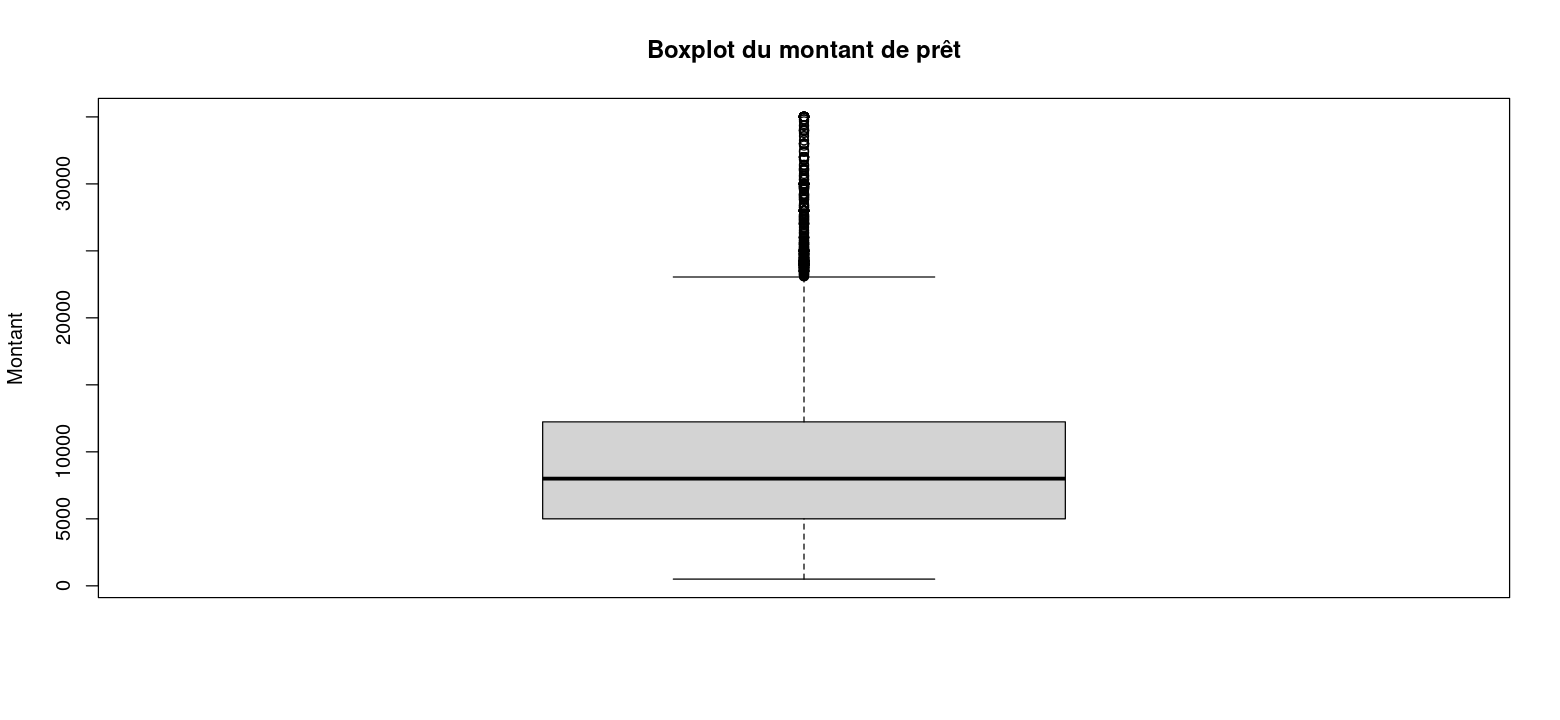

In [10]:
# Boîte à moustaches (boxplot)
boxplot(loan$loan_amnt, main = "Boxplot du montant de prêt", ylab = "Montant")

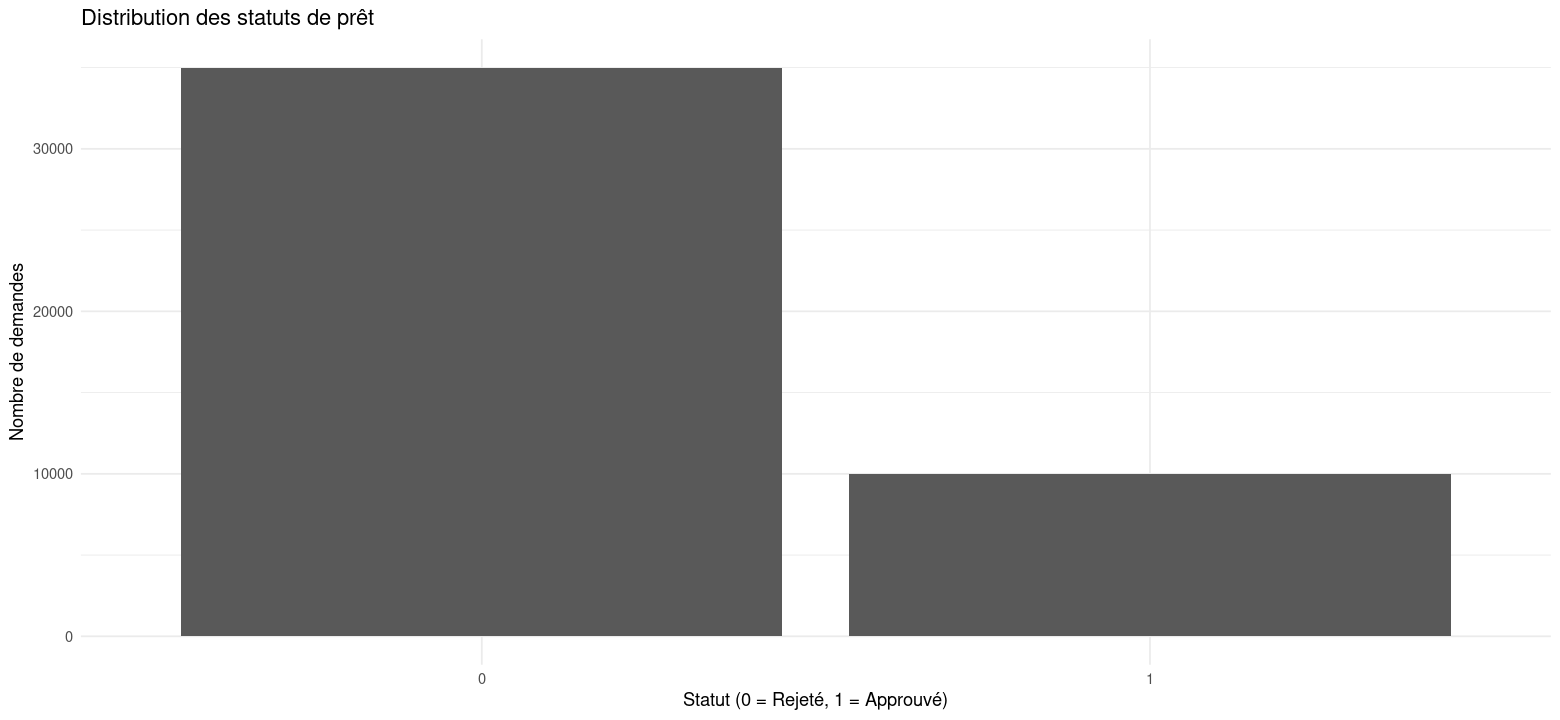

In [11]:
ggplot(loan, aes(x = factor(loan_status))) +
  geom_bar() +
  labs(title = "Distribution des statuts de prêt", 
       x = "Statut (0 = Rejeté, 1 = Approuvé)", 
       y = "Nombre de demandes") +
  theme_minimal()

On remarque un nombre plus élevé de prêts rejetés que de prêts approuvés, ce qui peut indiquer un déséquilibre entre les classes

No id variables; using all as measure variables



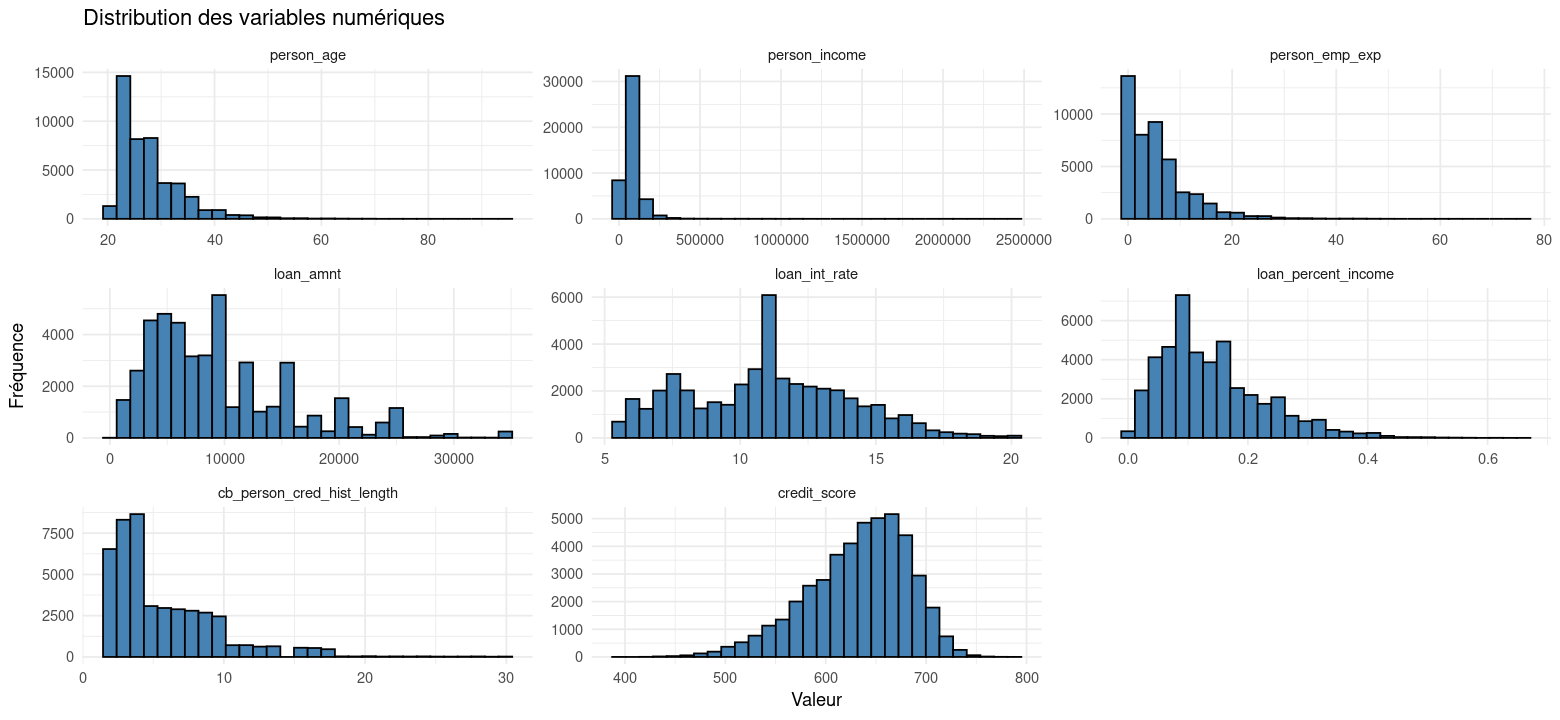

In [12]:
# Sélectionner uniquement les colonnes numériques
numeric_vars <- loan %>% select(where(is.numeric))
df_long <- melt(numeric_vars)
#melt(numeric_vars)
ggplot(df_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "black") +
  facet_wrap(~ variable, scales = "free", ncol = 3) +
  theme_minimal() +
  labs(title = "Distribution des variables numériques",
       x = "Valeur", y = "Fréquence")

In [ ]:
On voit que la variable person_income suit une décroissance exponentielle. Alors, on la normalise donc par une transformation logarithmique.

In [13]:
loan[, "person_income"] <- log(loan[, "person_income"])

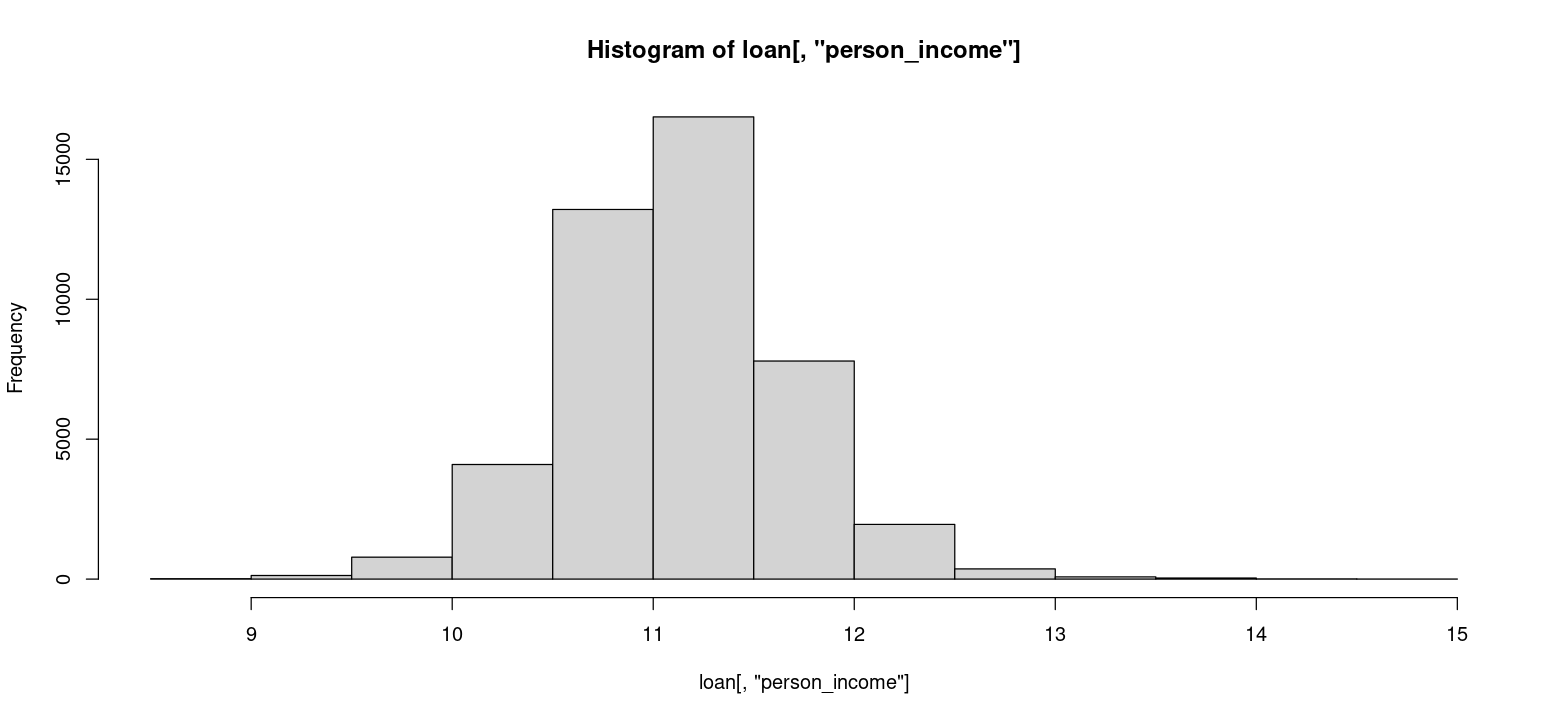

In [138]:
hist(loan[, "person_income"])

## 2 Analyse bivariée

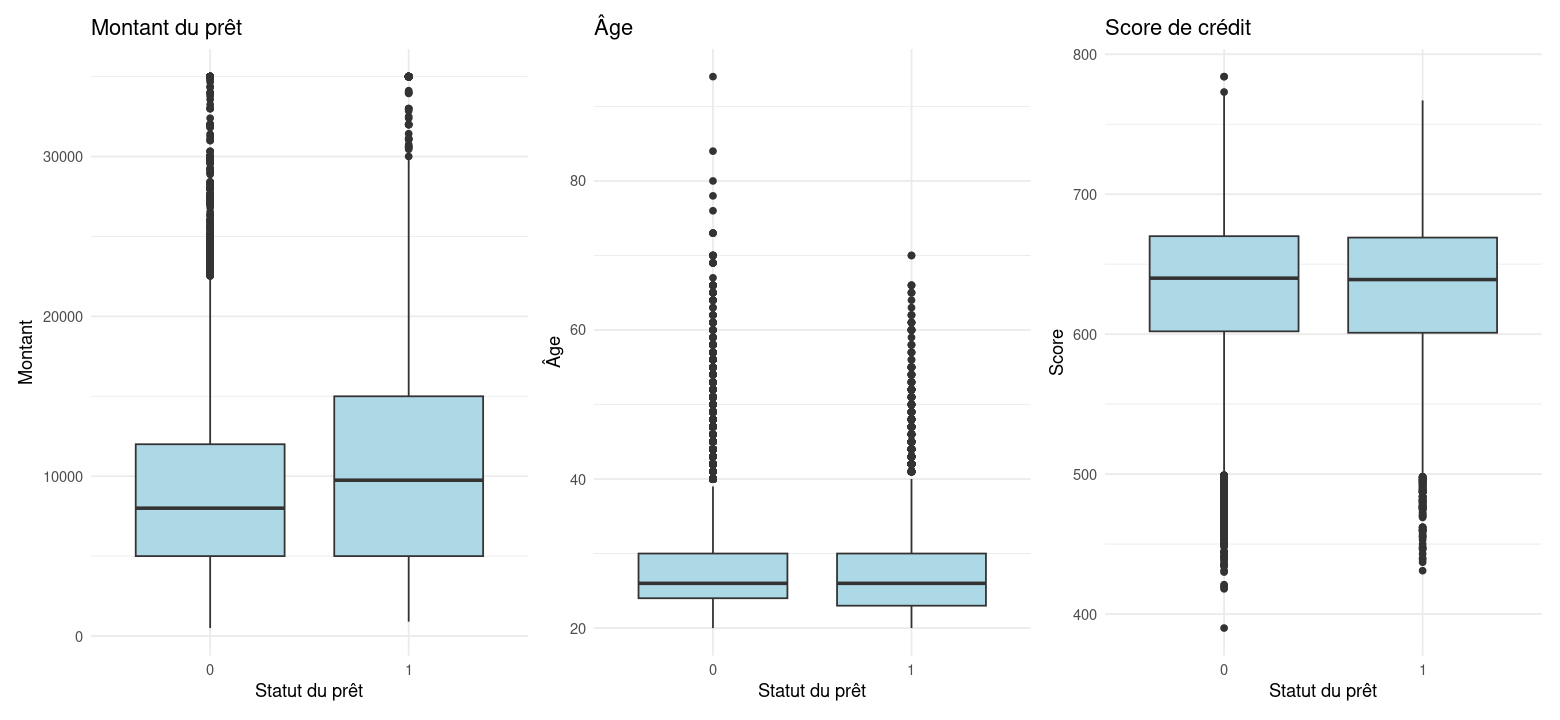

In [14]:
p1 <- ggplot(loan, aes(x = factor(loan_status), y = loan_amnt)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Montant du prêt", x = "Statut du prêt", y = "Montant") +
  theme_minimal()

p2 <- ggplot(loan, aes(x = factor(loan_status), y = person_age)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Âge", x = "Statut du prêt", y = "Âge") +
  theme_minimal()

p3 <- ggplot(loan, aes(x = factor(loan_status), y = credit_score)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Score de crédit", x = "Statut du prêt", y = "Score") +
  theme_minimal()

# Combine as subplot
(p1 | p2 | p3)  # 3 plots side by side 

On voit qu’il n’y a pas d’effet de la variable âge et du score de crédit sur le statut du prêt.

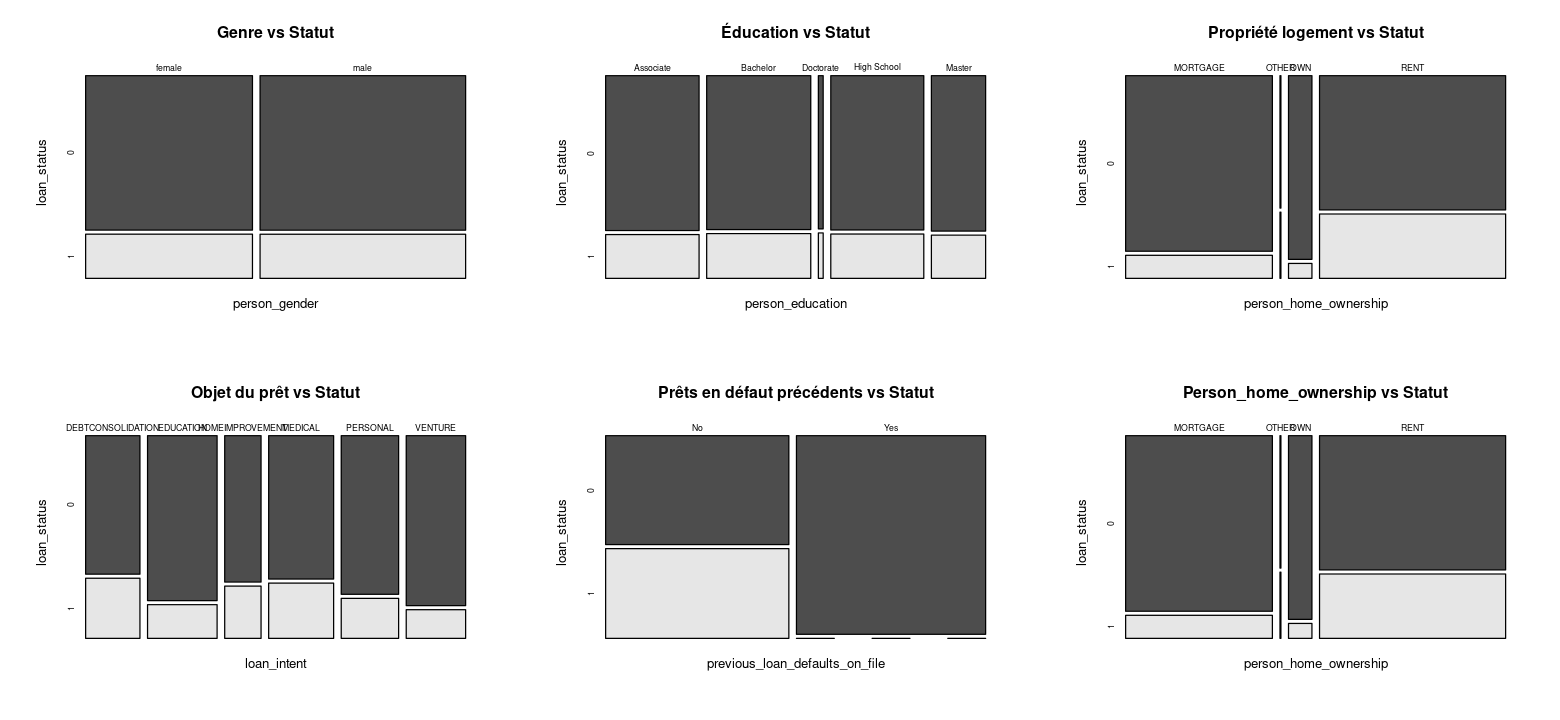

In [148]:
par(mfrow = c(2, 3)) 

mosaicplot(~ person_gender + loan_status, data = loan,
           main = "Genre vs Statut", col = TRUE)

mosaicplot(~ person_education + loan_status, data = loan,
           main = "Éducation vs Statut", col = TRUE)



mosaicplot(~ loan_intent + loan_status, data = loan,
           main = "Objet du prêt vs Statut", col = TRUE)

mosaicplot(~ previous_loan_defaults_on_file + loan_status, data = loan,
           main = "Prêts en défaut précédents vs Statut", col = TRUE)


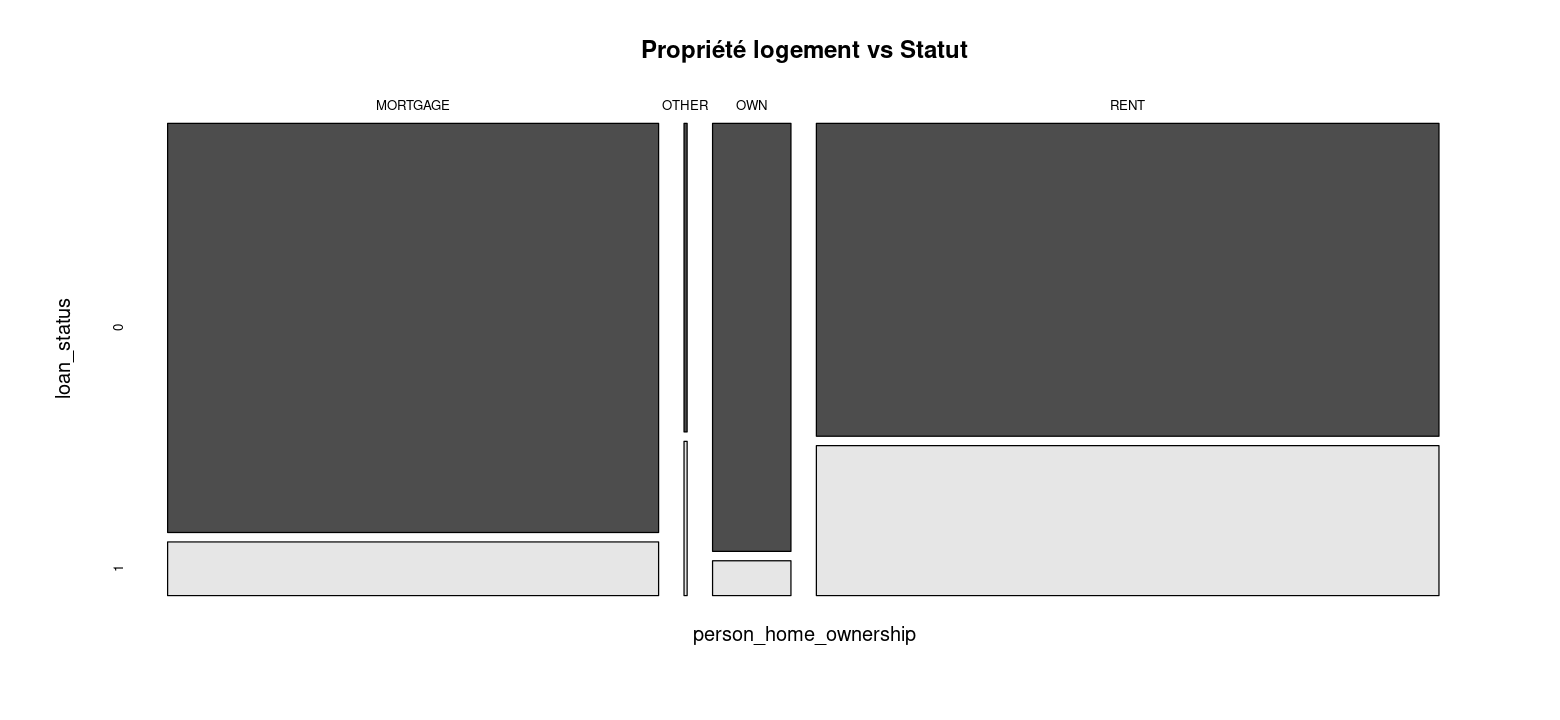

In [149]:
mosaicplot(~ person_home_ownership + loan_status, data = loan,
           main = "Propriété logement vs Statut", col = TRUE)

Il semble qu’il n’y ait pas d’effet des variables genre et éducation sur le statut du prêt. En revanche, les personnes qui n’ont pas remboursé leur précédent prêt à la banque ne sont pas autorisées à en contracter un nouveau.

Les candidats ayant des antécédents de défaut de paiement de prêt ont un taux de rejet nettement plus élevé que ceux qui n’ont pas connu de défaut de paiement.

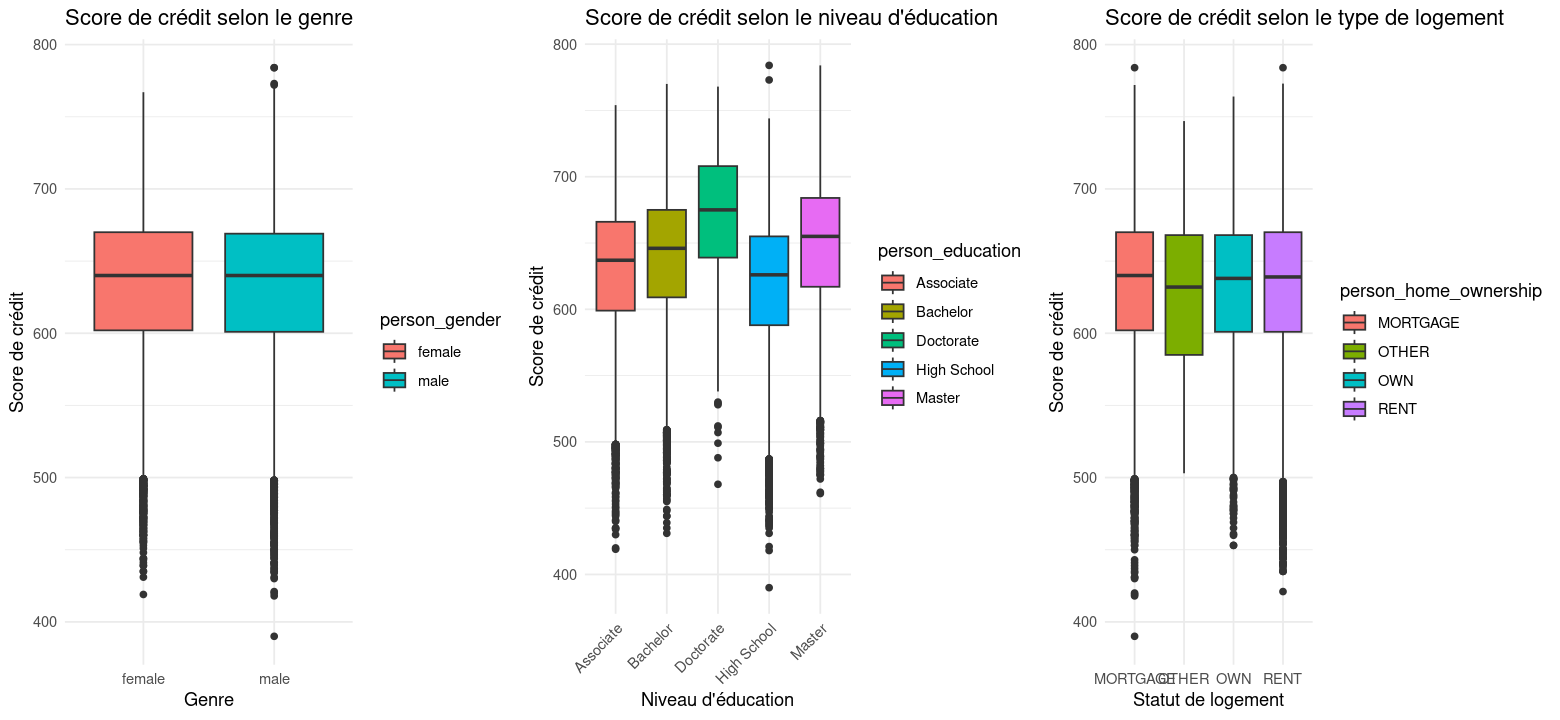

In [16]:


p1 <- ggplot(loan, aes(x = person_gender, y = credit_score, fill = person_gender)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le genre",
       x = "Genre", y = "Score de crédit") +
  theme_minimal()

p2 <- ggplot(loan, aes(x = person_education, y = credit_score, fill = person_education)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le niveau d'éducation",
       x = "Niveau d'éducation", y = "Score de crédit") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

p3 <- ggplot(loan, aes(x = person_home_ownership, y = credit_score, fill = person_home_ownership)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le type de logement",
       x = "Statut de logement", y = "Score de crédit") +
  theme_minimal()

# Combine side-by-side
grid.arrange(p1, p2, p3, ncol = 3)


Il semble qu’il n’y ait pas d’effet des variables genre sur le statut du prêt.

In [17]:
loan_quanti <- loan[,c(1,4,5,7,9,10,11,12)]
loan_quali <- loan[,-c(1,4,5,7,9,10,11,12)]

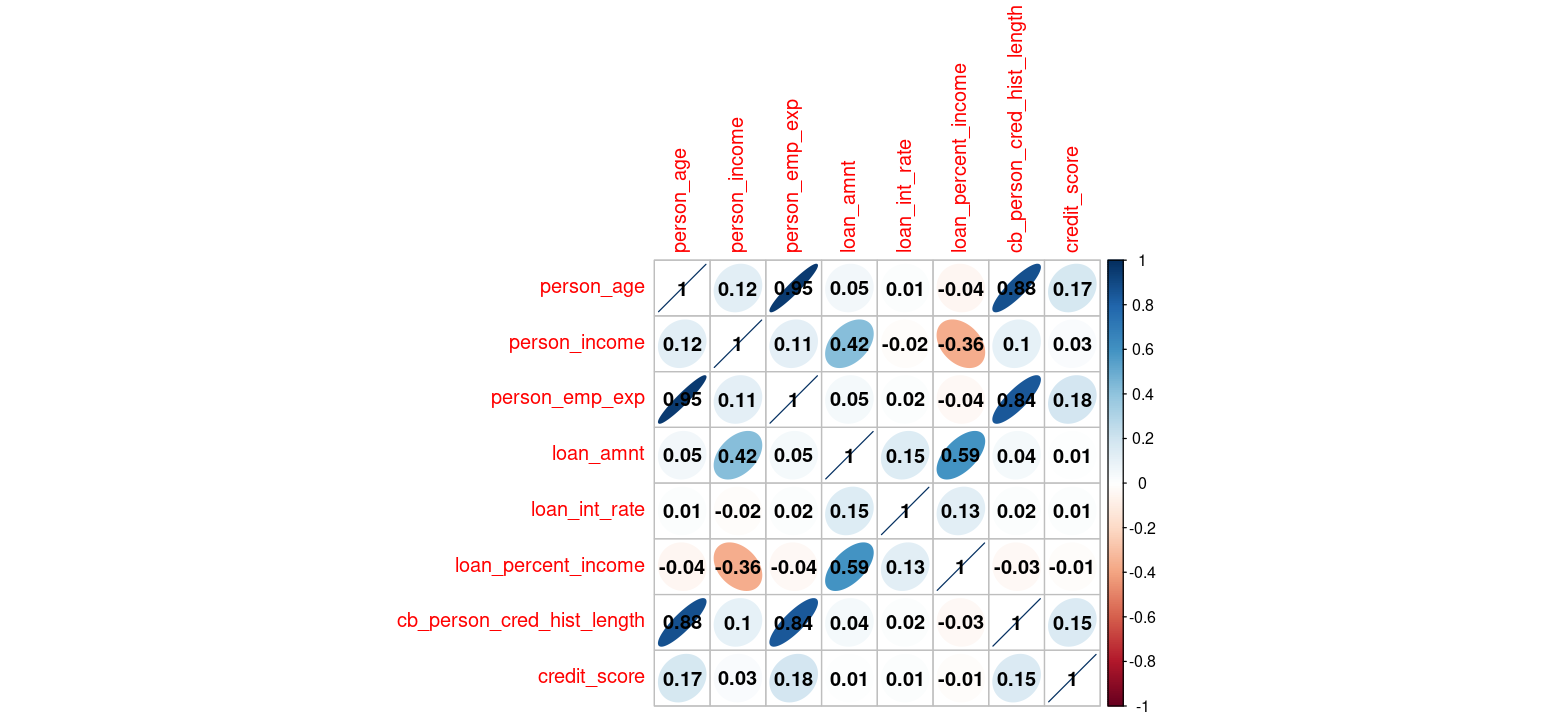

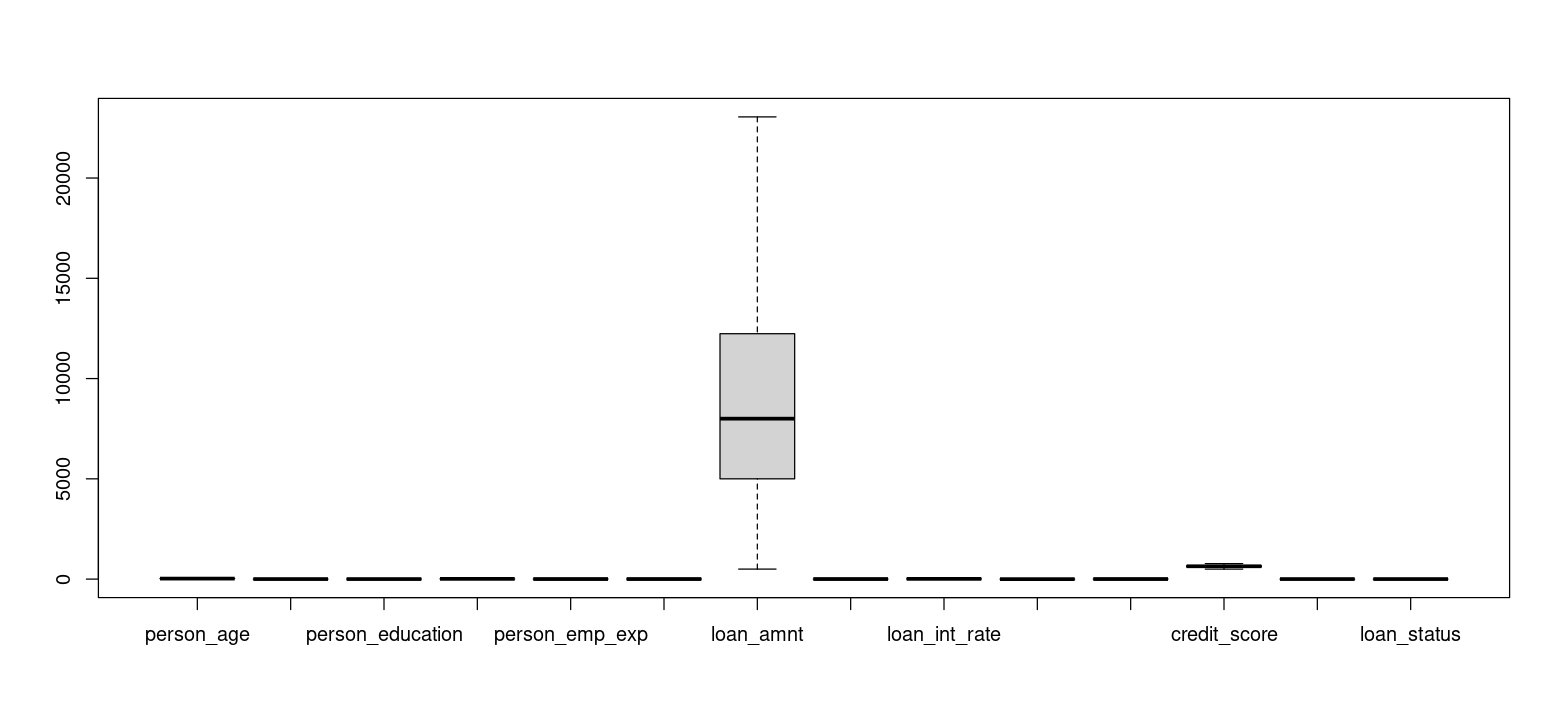

In [18]:

corrplot(cor(loan_quanti),method="ellipse", addCoef.col = "black")
boxplot(loan,outline = FALSE)
#ggpairs(loan_quanti)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


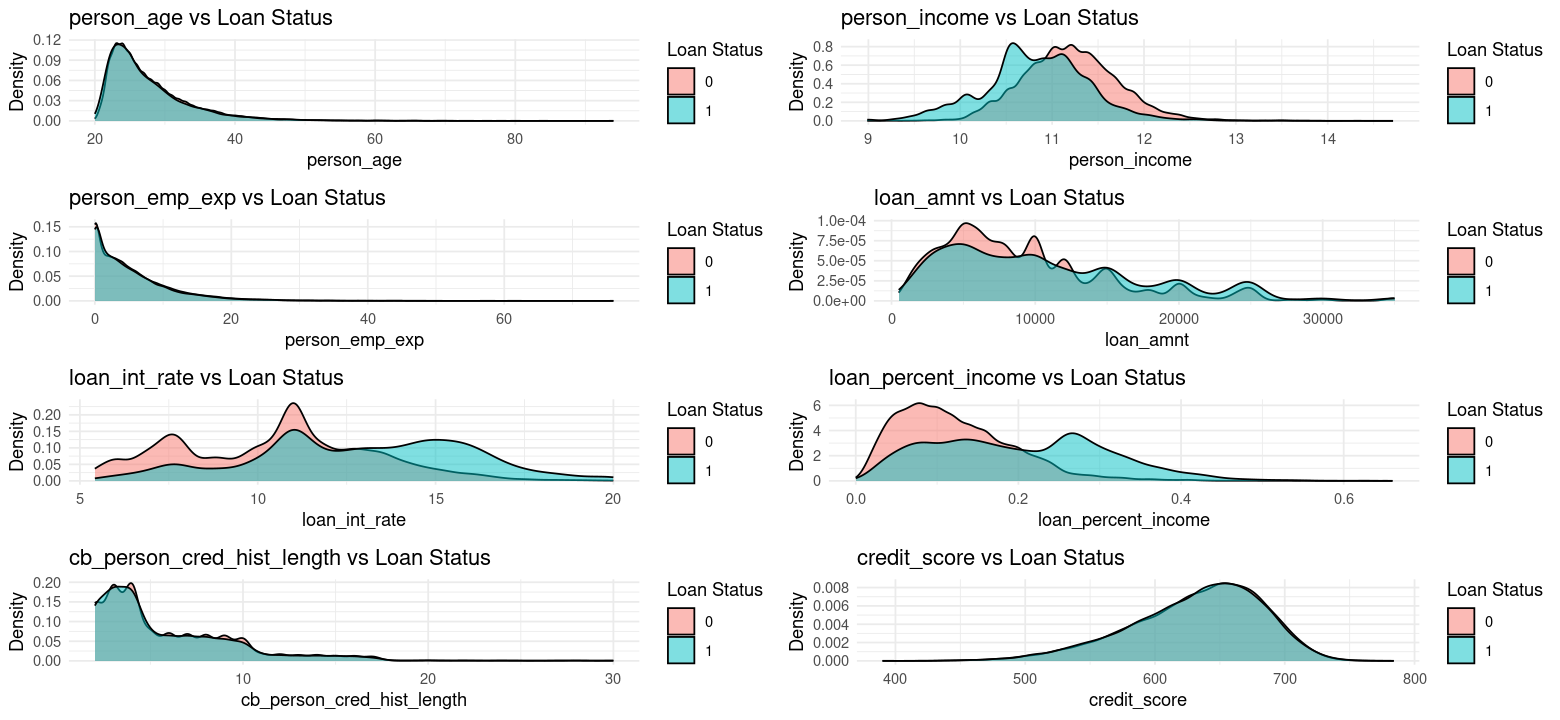

In [19]:
numerical_columns <- names(loan)[sapply(loan, is.numeric)]
plots <- lapply(numerical_columns, function(col_name) {
ggplot(loan, aes_string(x = col_name, fill = "factor(loan_status)")) +
  geom_density(alpha = 0.5) +
  labs(title = paste(col_name, "vs Loan Status"), x = col_name, y = "Density", fill = "Loan Status") +
  theme_minimal()
    
})

# Afficher en grille 4x2
do.call(grid.arrange, c(plots, ncol = 2))


# II Réduction linaire

## PCA

eigenvalue percentage of variance cumulative percentage of variance
comp 1 2.86205374 35.7756718              35.77567                        
comp 2 1.65218937 20.6523671              56.42804                        
comp 3 1.29964269 16.2455336              72.67357                        
comp 4 0.95620119 11.9525148              84.62609                        
comp 5 0.93872759 11.7340949              96.36018                        
comp 6 0.17441279  2.1801599              98.54034                        
comp 7 0.07326010  0.9157513              99.45609                        
comp 8 0.04351253  0.5439066             100.00000

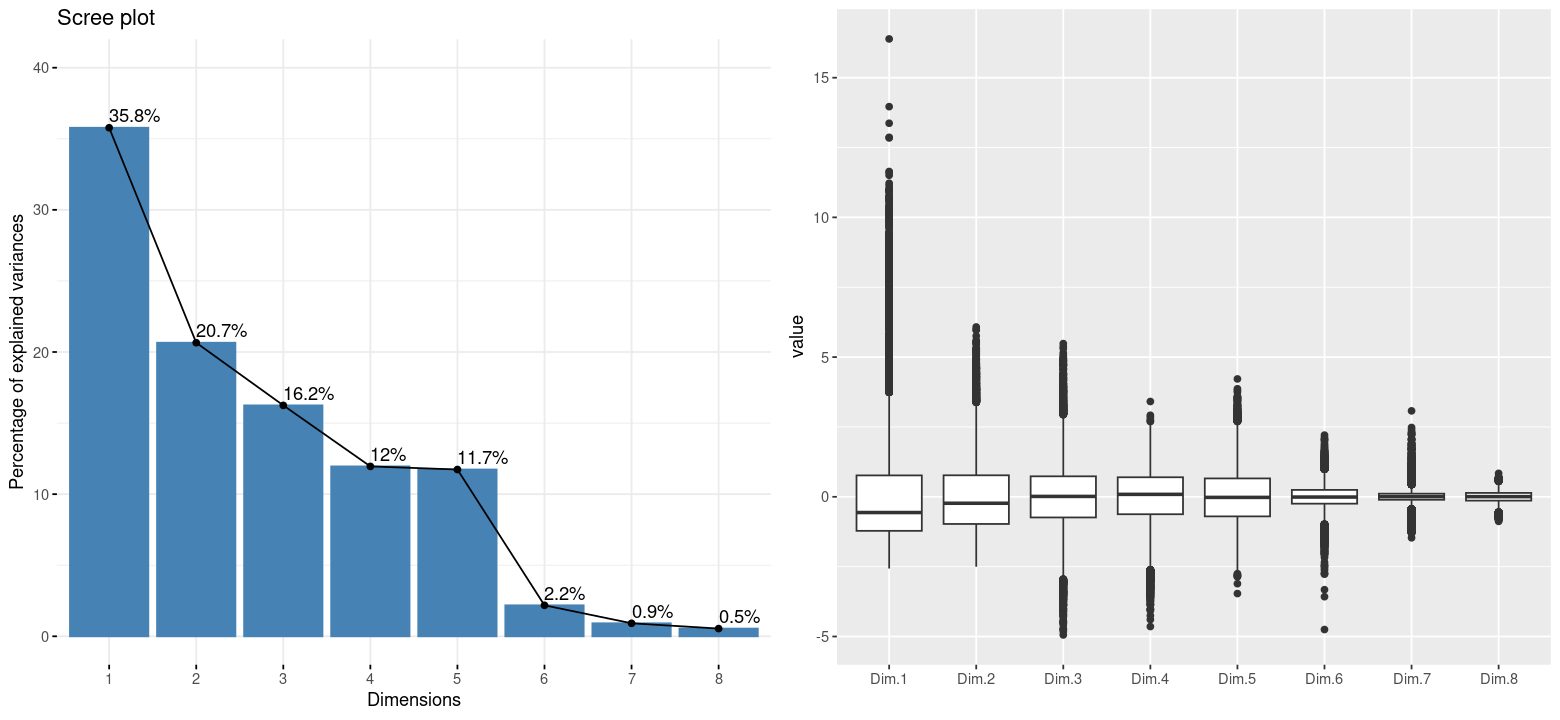

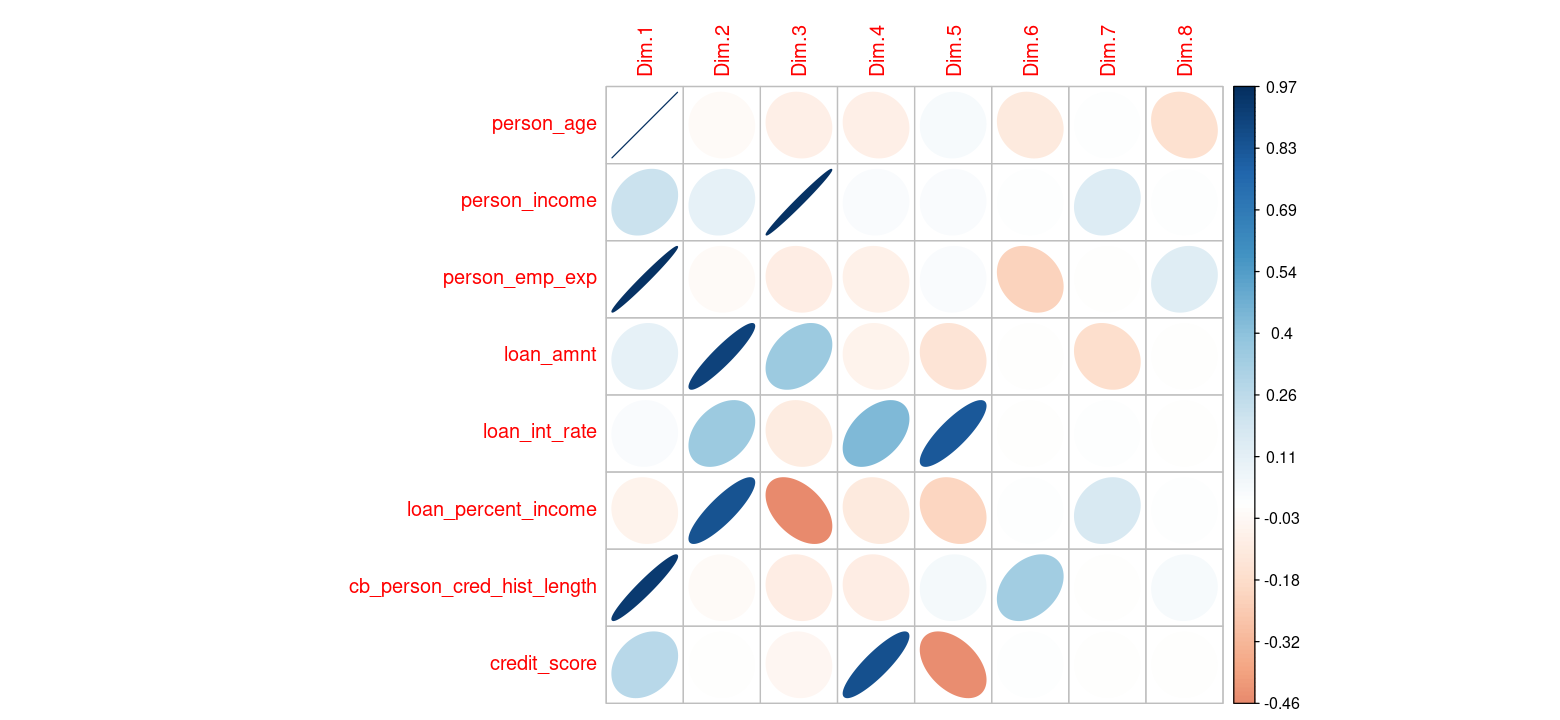

In [20]:
acp <- PCA(loan_quanti, scale.unit = TRUE,
           graph = FALSE,  ncp = 8)
# Eigenvalue decay
acp$eig
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)


corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

Dim1 est représentée par des variables comme l’âge, les années d’expérience et la longueur de l’historique de crédit ; on peut donc dire que cette dimension reflète l’âge relatif du client. Les variables loan_amnt et loan_percent_income sont corrélées avec la dimension 2. La dimension 3 est représentée par person_income.

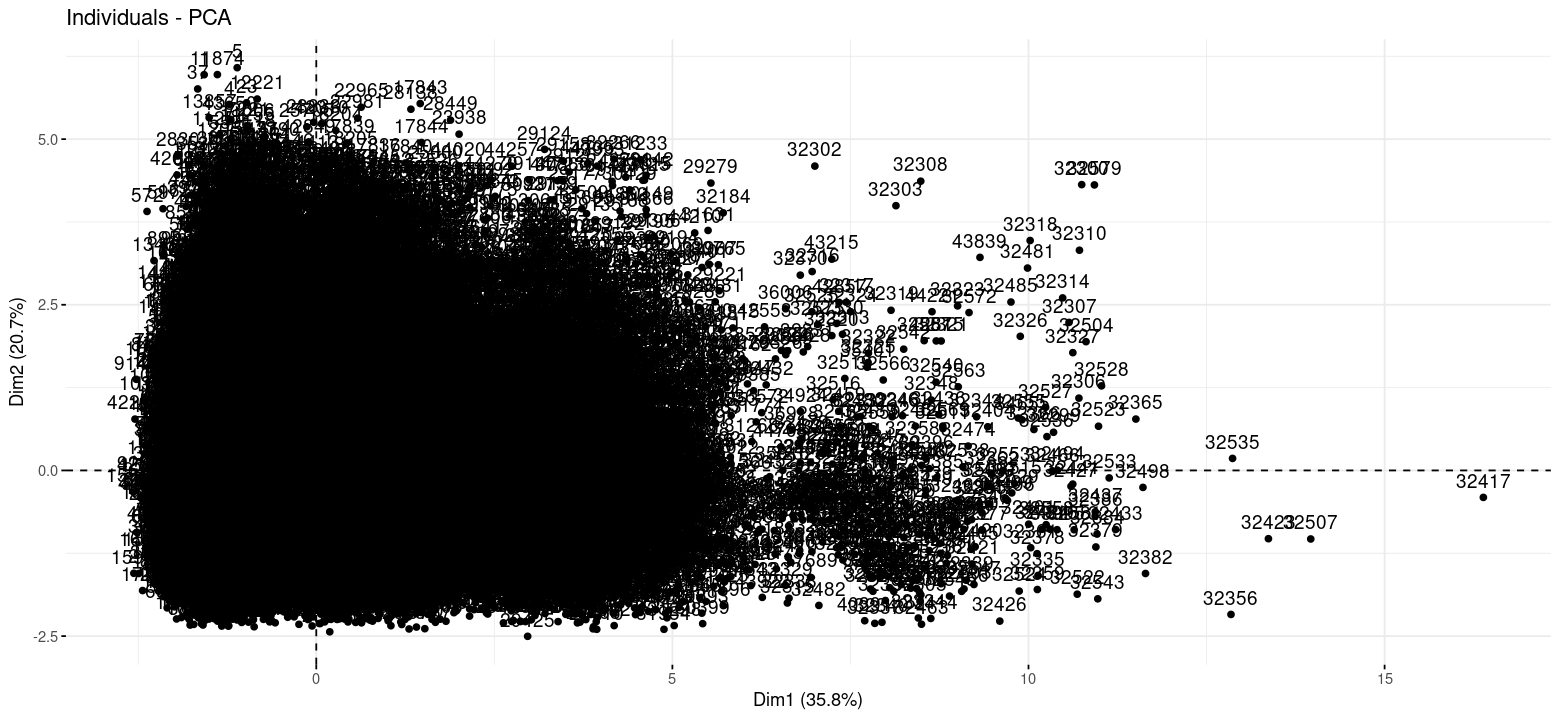

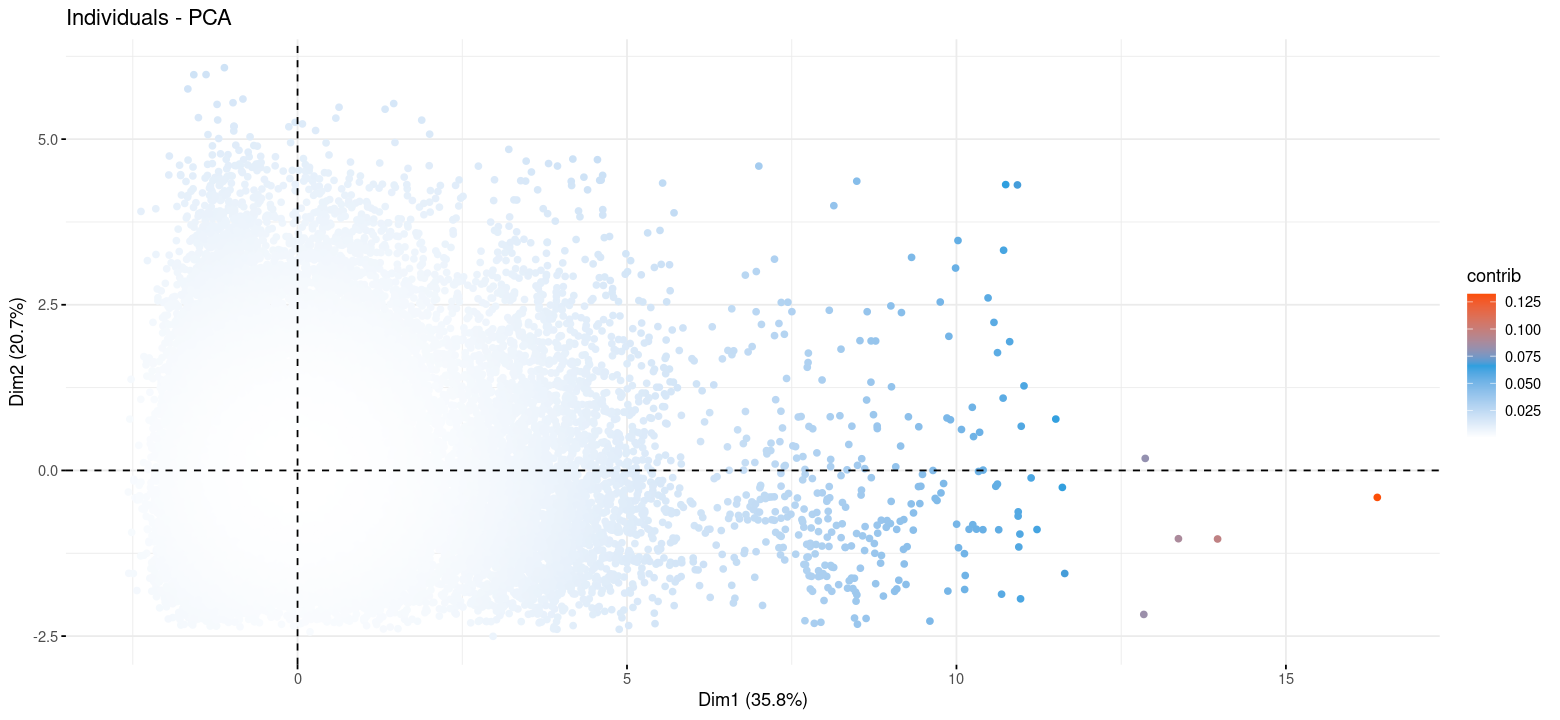

In [21]:
#fviz_pca_ind(acp,col.ind="contrib",label="none")
fviz_pca_ind(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
#fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
#fviz_pca_ind(acp, label="none", habillage=2)

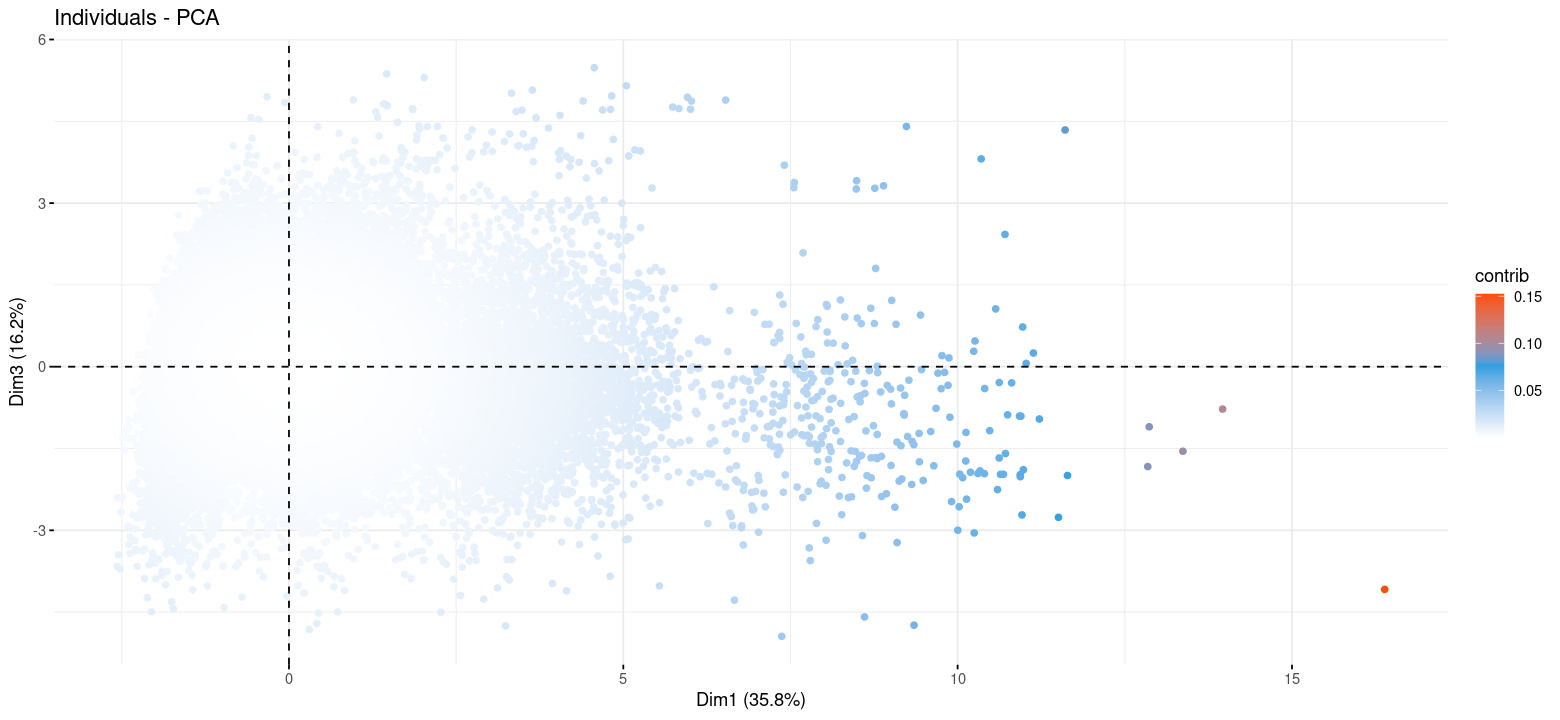

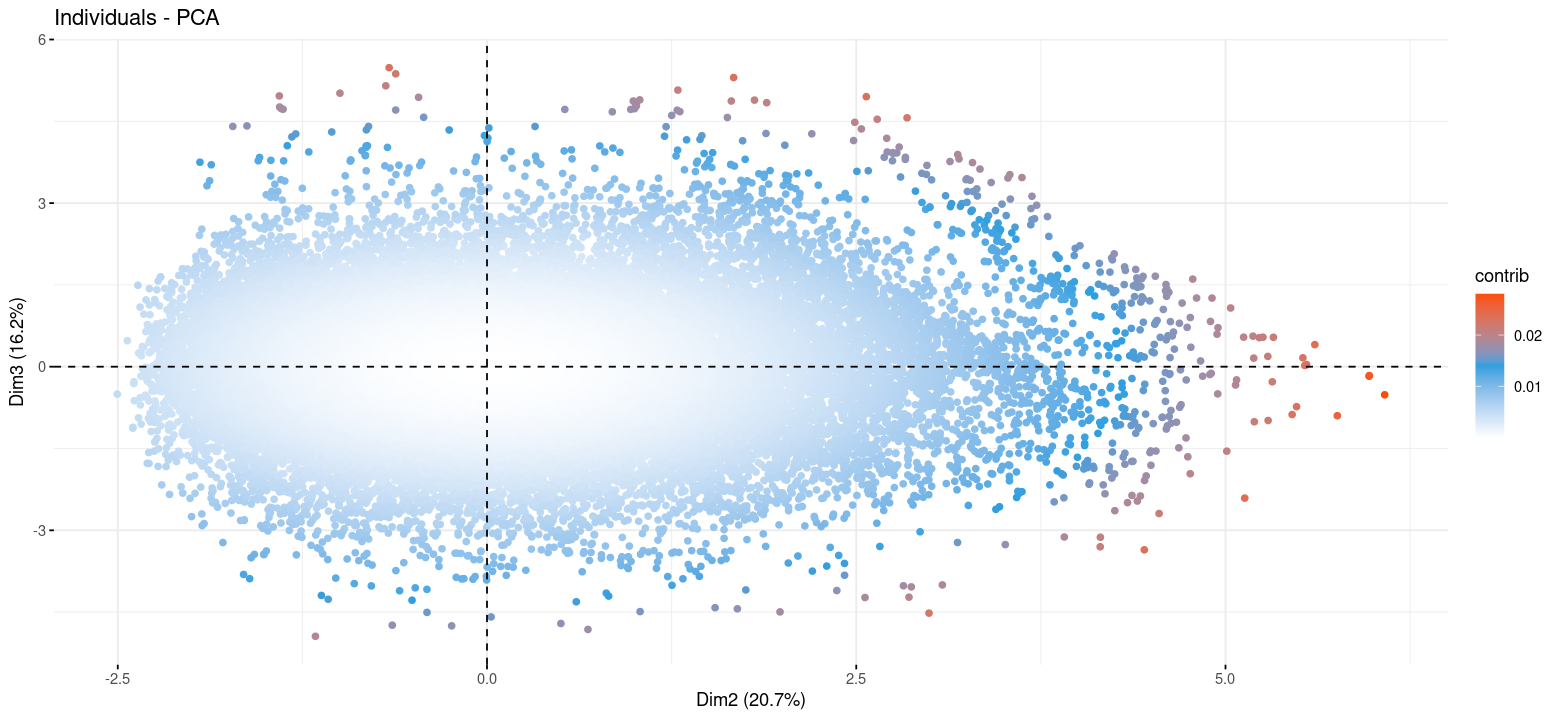

In [22]:
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(2,3))

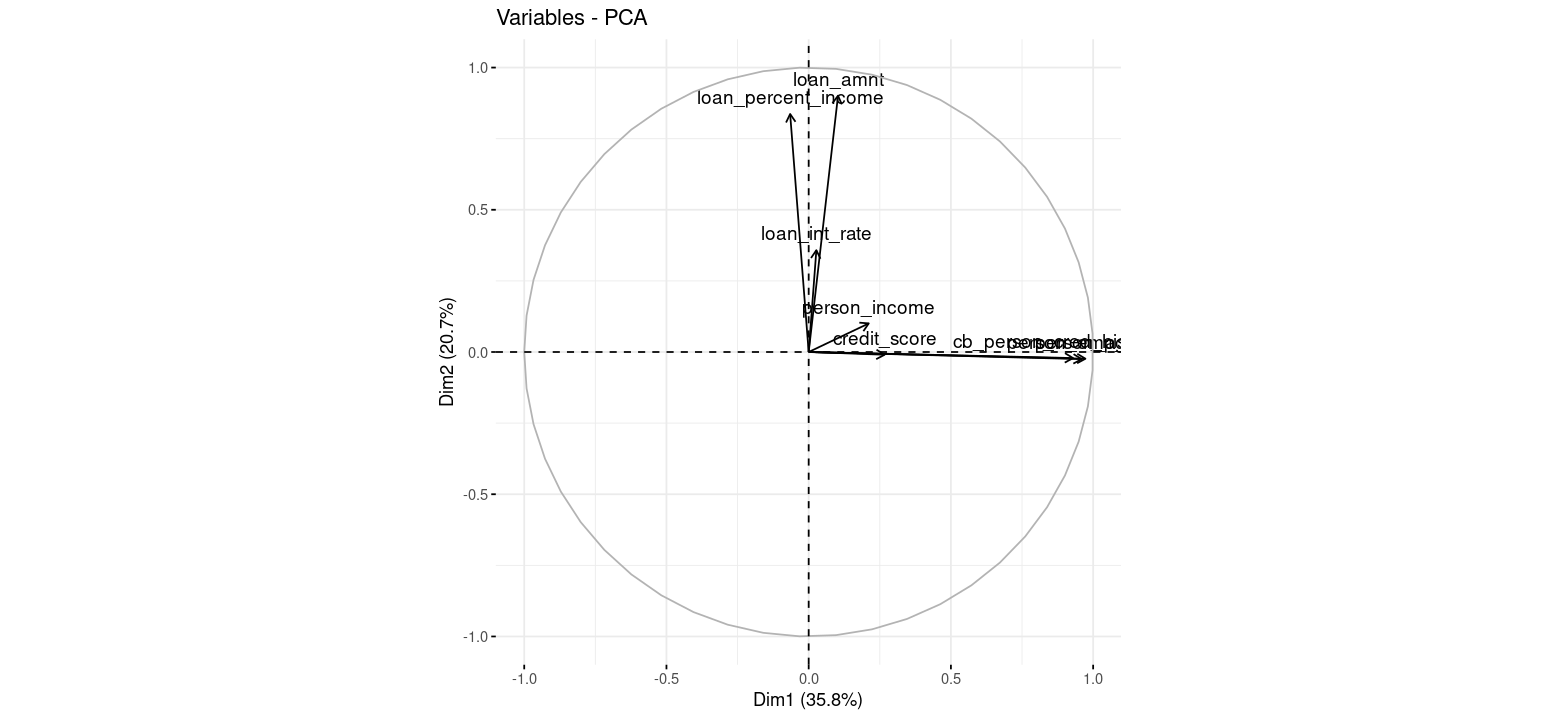

In [145]:
p1 <- fviz_pca_var(acp)                     # Dim 1 & 2
p2 <- fviz_pca_var(acp, axes = c(1, 3))     # Dim 1 & 3
p3 <- fviz_pca_var(acp, axes = c(2, 3))     # Dim 2 & 3

# Combine the plots in one row
grid.arrange(p1, p2, p3, ncol = 3)

#fviz_pca_var(acp,axes =c(1,4))
#fviz_pca_var(acp,axes =c(2,4))
#fviz_pca_var(acp,axes =c(3,4))

# MCA

# Étude des variable qualitatives

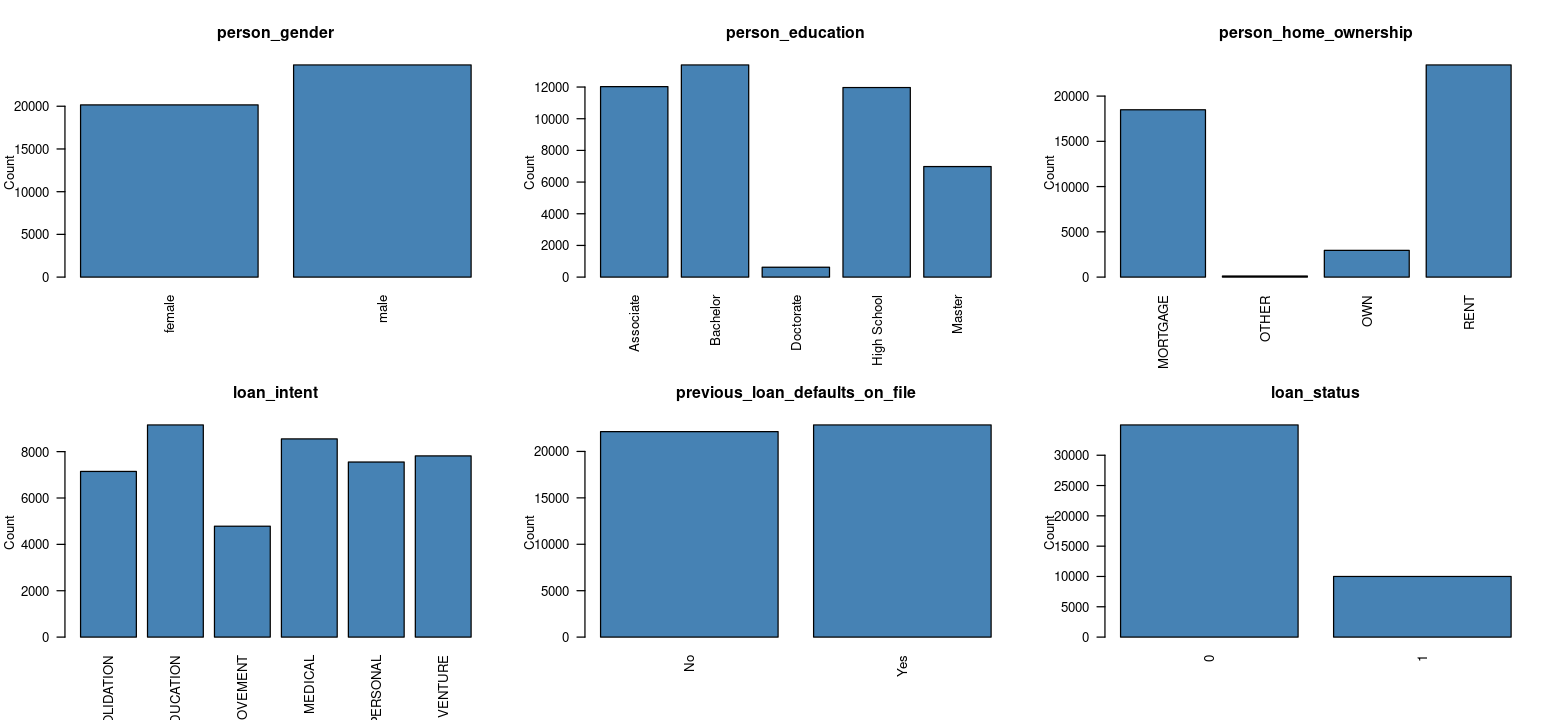

In [24]:
par(mfrow=c(2,3))
I = 6
for (i in 1:I) {
    plot(loan_quali[,i], main = colnames(loan_quali)[i],
         ylab = "Count", col="steelblue", las = 2)
    }


In [25]:
res.mca <- MCA(loan_quali, quali.sup = 6, graph = FALSE) #POUR LES VARIABLES QUALITATIVES

On garde 7 dims (1/p)

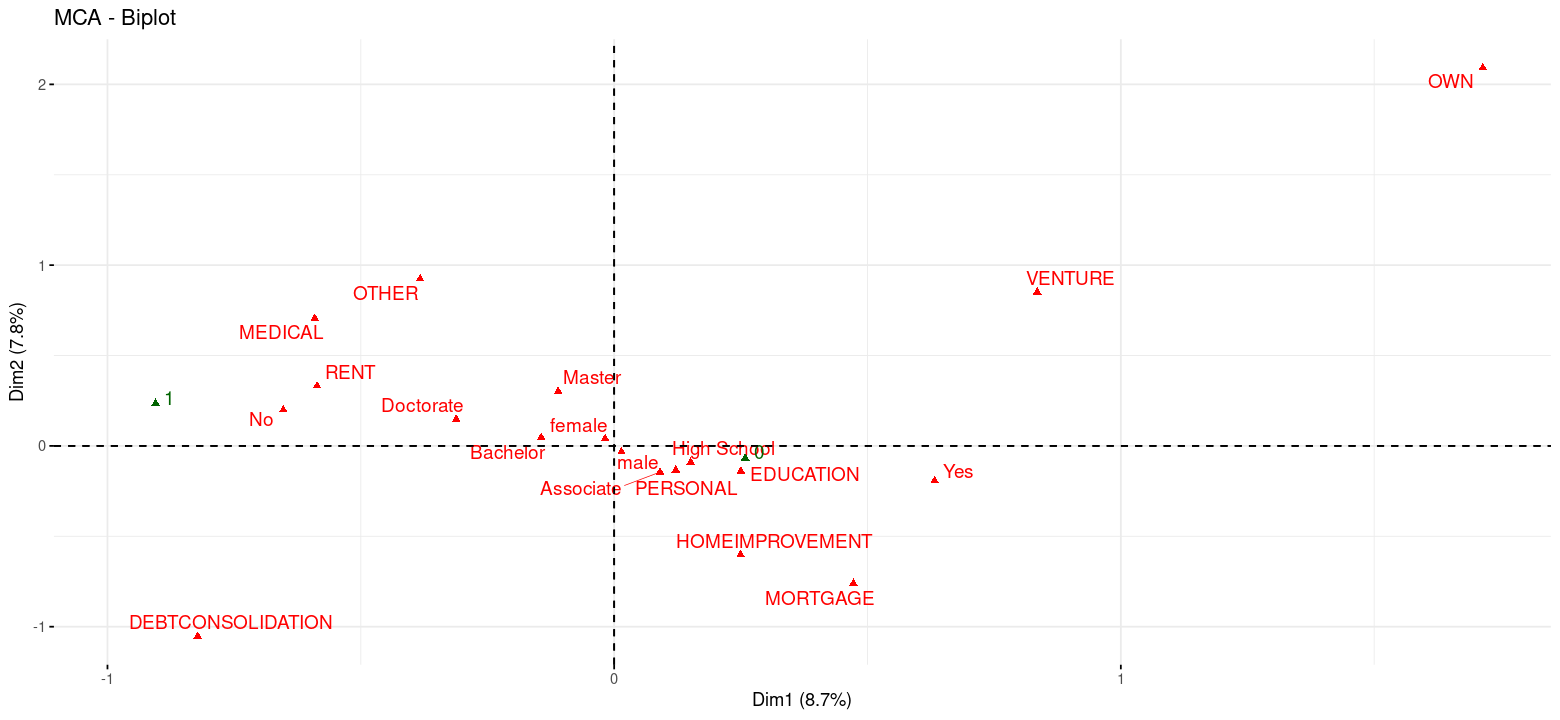

In [26]:
fviz_mca_biplot(res.mca, 
                invisible = "ind", 
                repel = TRUE,     # empêche les textes de se chevaucher
                ggtheme = theme_minimal())

Les personnes empruntant pour acheter ou rénover une maison ont tendance à avoir un historique de défaut de paiement ("defaulter = yes"), tandis que celles sans défaut de paiement ("defaulter = no") ont plutôt tendance à utiliser leur prêt pour louer un logement ou pour des dépenses de santé.

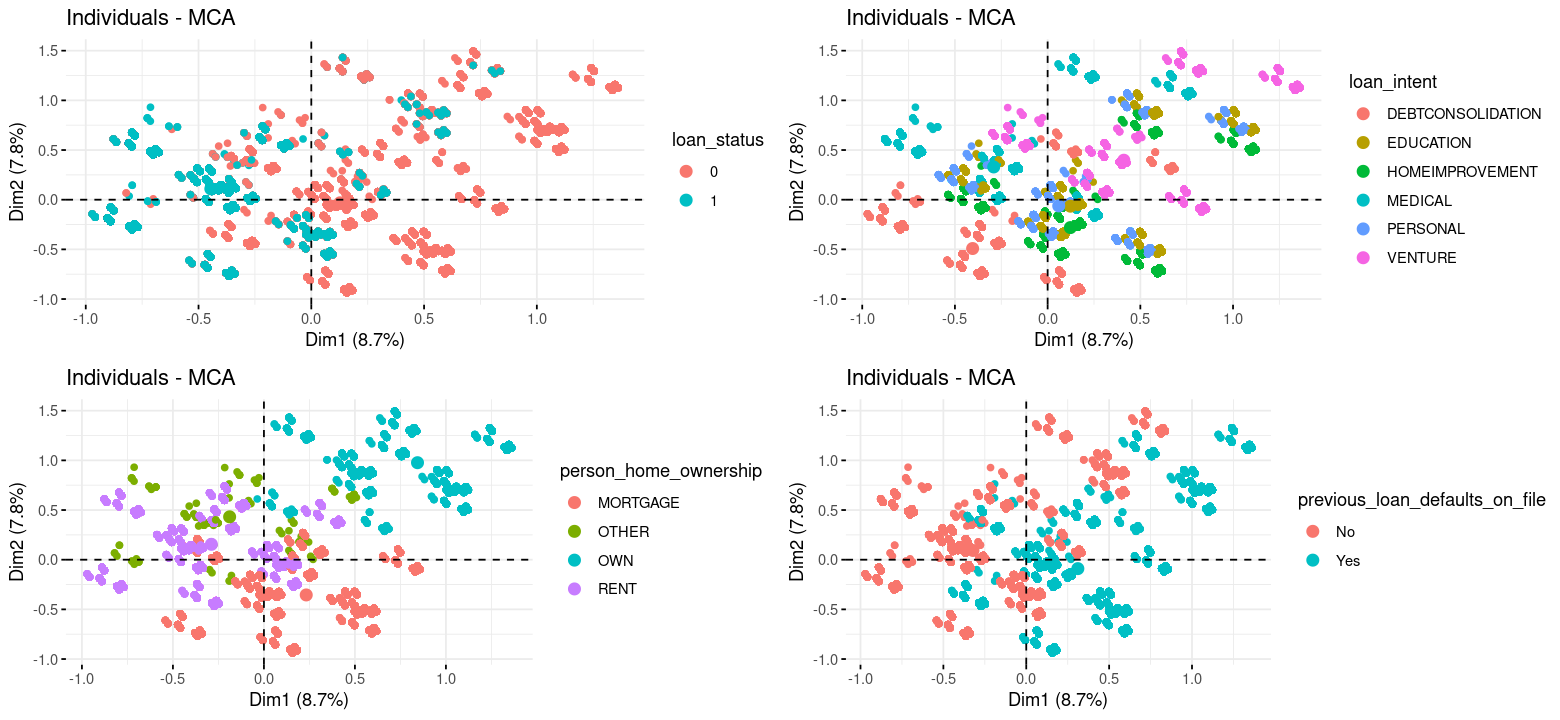

In [27]:
p1 <- fviz_mca_ind(res.mca, label = "none", habillage = "loan_status")
p2 <- fviz_mca_ind(res.mca, label = "none", habillage = "loan_intent")
p3 <- fviz_mca_ind(res.mca, label = "none", habillage = "person_home_ownership")
p4 <- fviz_mca_ind(res.mca, label = "none", habillage = "previous_loan_defaults_on_file")

# Combine 4 plots in a 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2)


Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


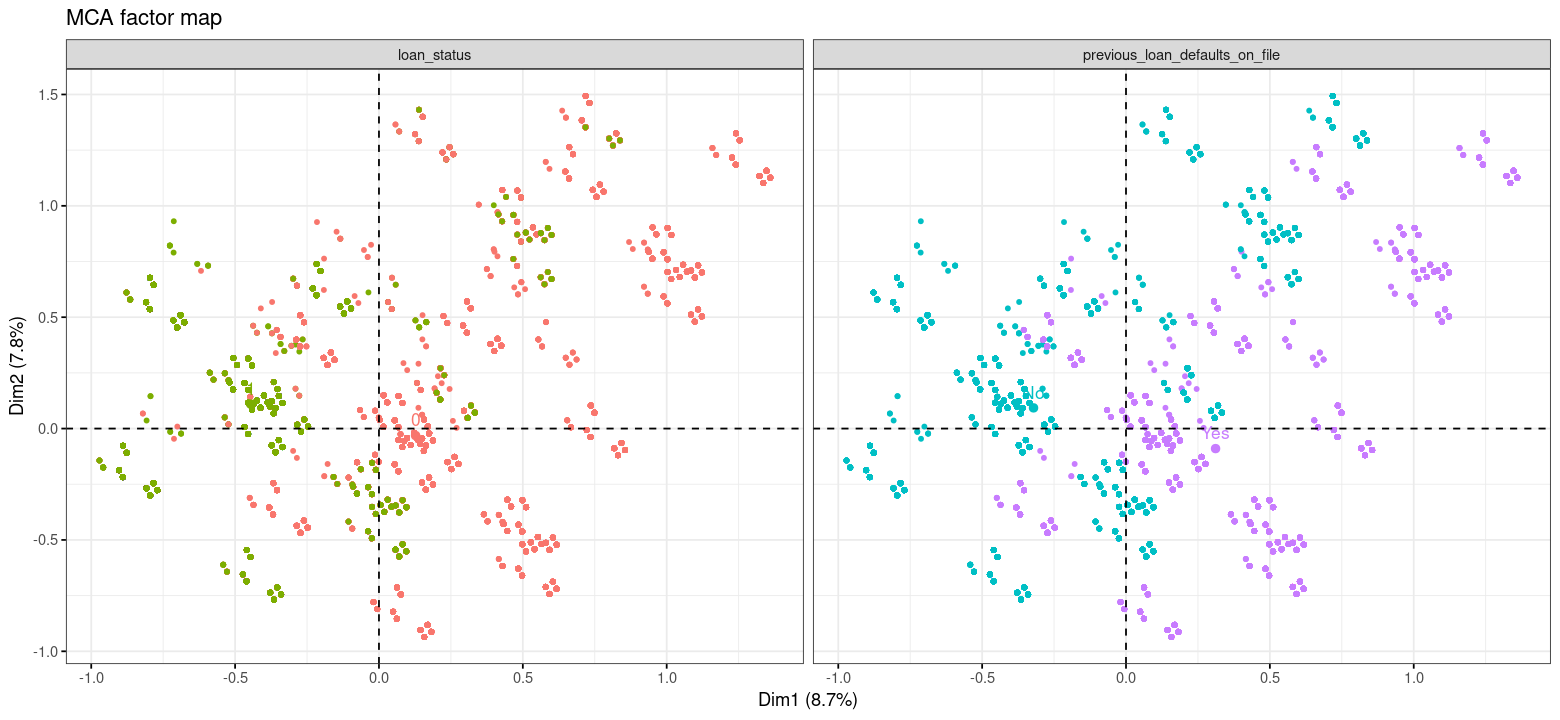

In [28]:
fviz_ellipses(res.mca, c("loan_status", "previous_loan_defaults_on_file"),
              geom = "point")

### Quality of representation

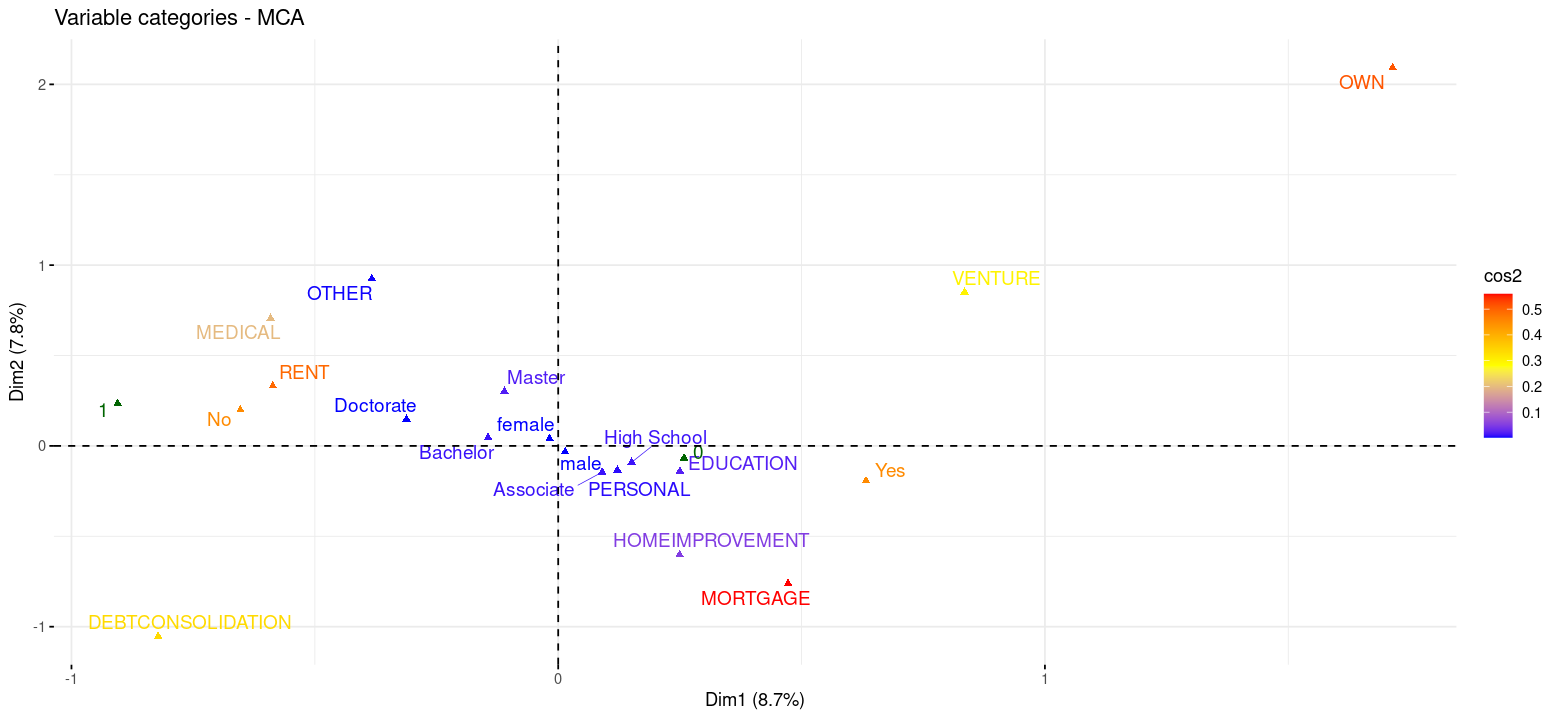

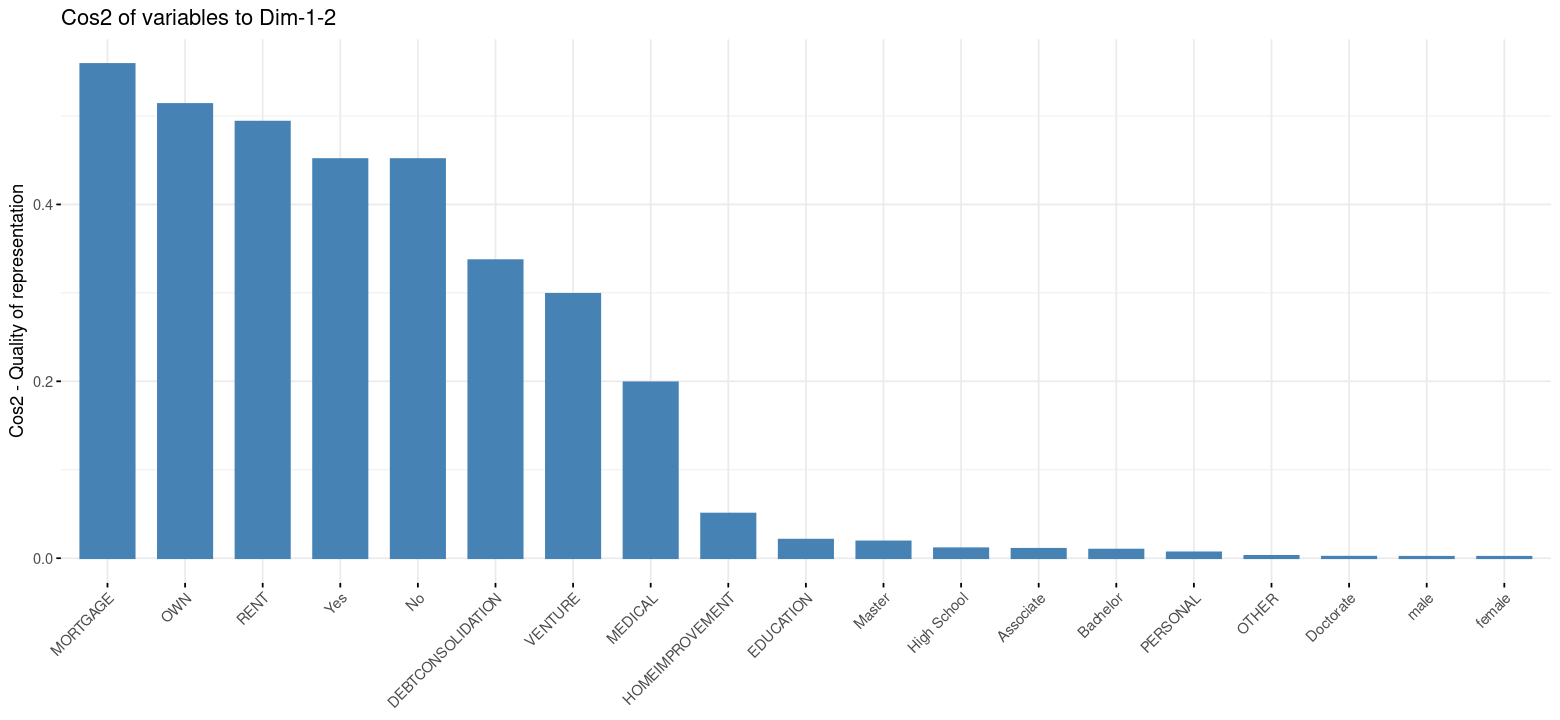

In [29]:
fviz_mca_var(res.mca, col.var = "cos2",
             gradient.cols = c("blue", "yellow", "red"), 
             repel = TRUE )


# Cos2 of variable categories on Dim.1 and Dim.2
fviz_cos2(res.mca, choice = "var", axes = 1:2)

### Contribution to the dimensions

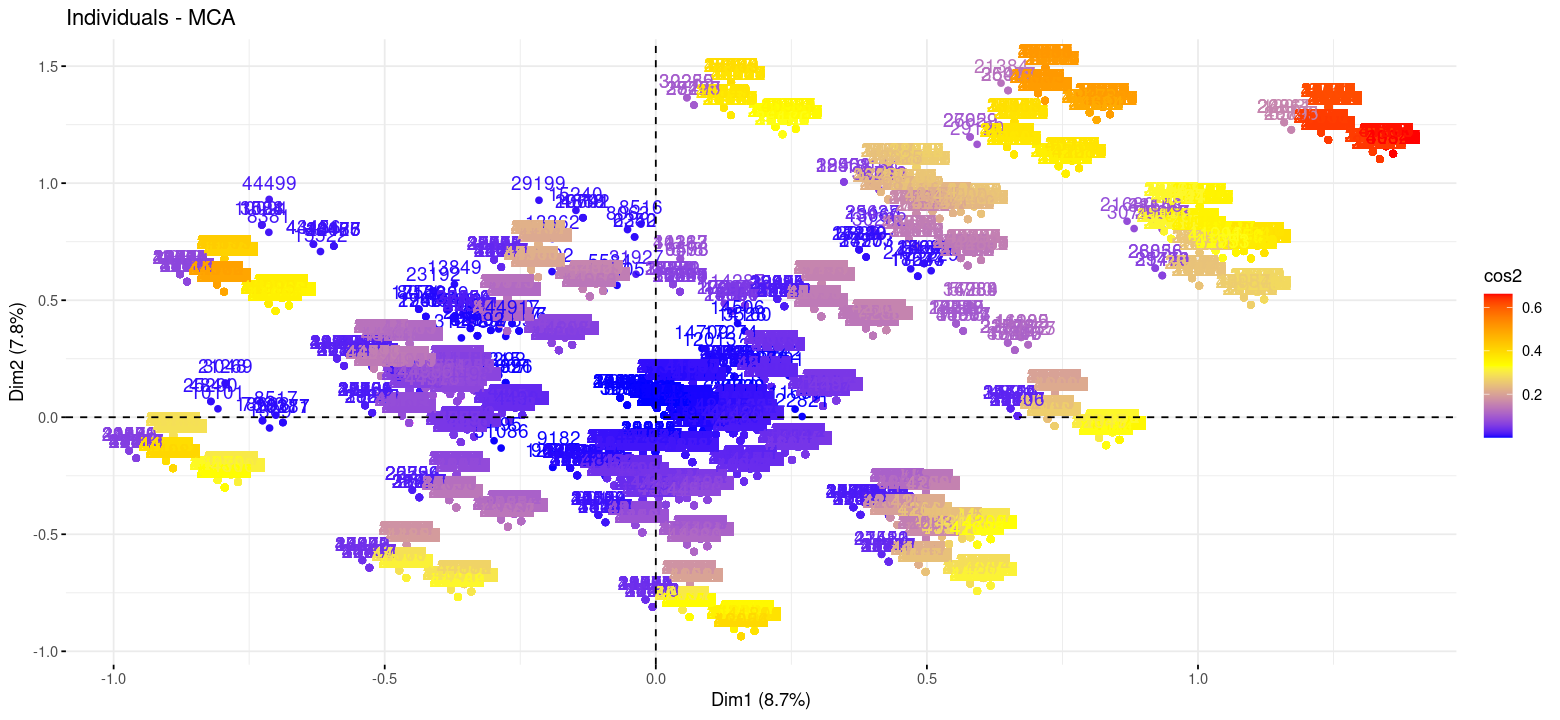

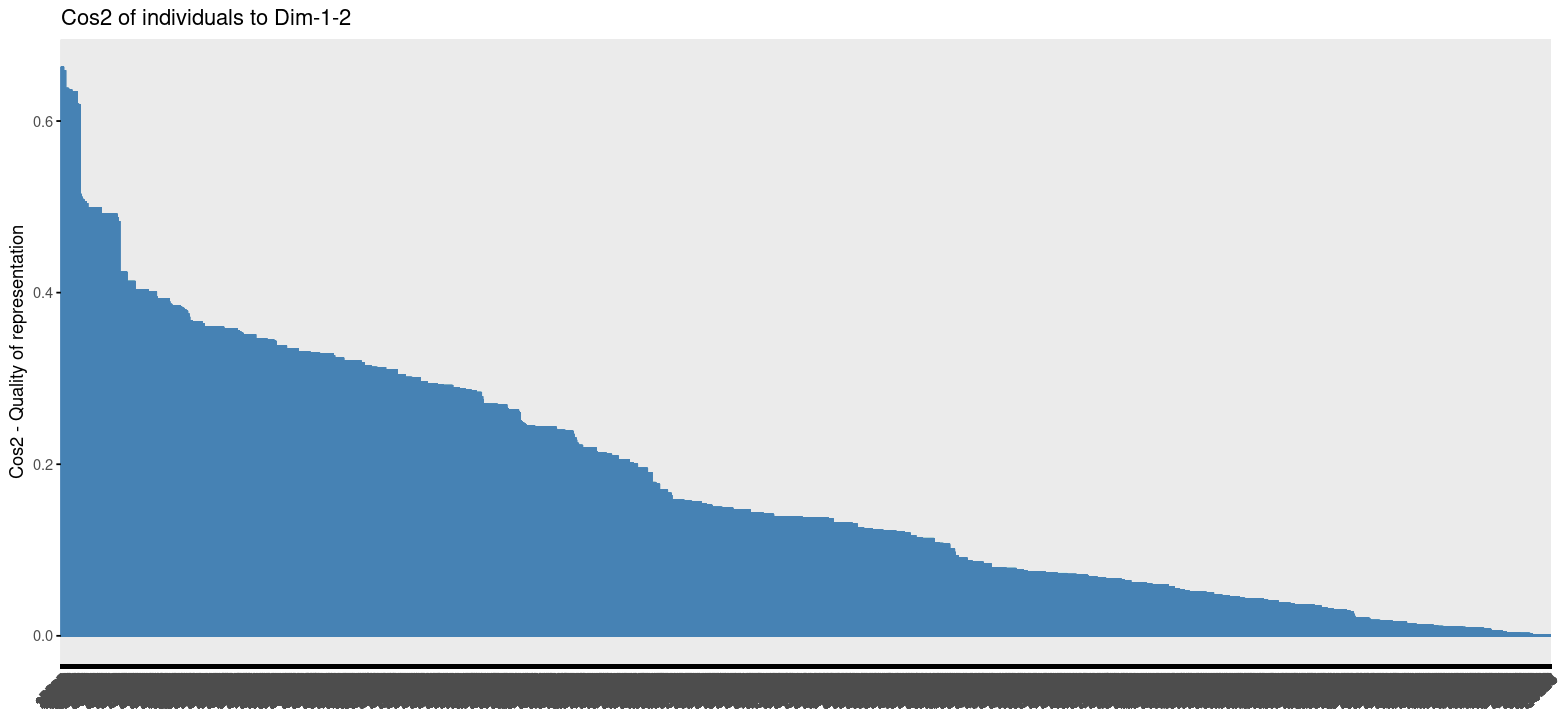

In [30]:
## TO BE COMPLETED ##
# Color by cos2 values: quality on the individual map
fviz_mca_ind(res.mca, col.ind = "cos2",
             gradient.cols = c("blue", "yellow", "red"))


# Cos2 of individuals on Dim.1 and Dim.2
fviz_cos2(res.mca, choice="ind", axes=1:2)

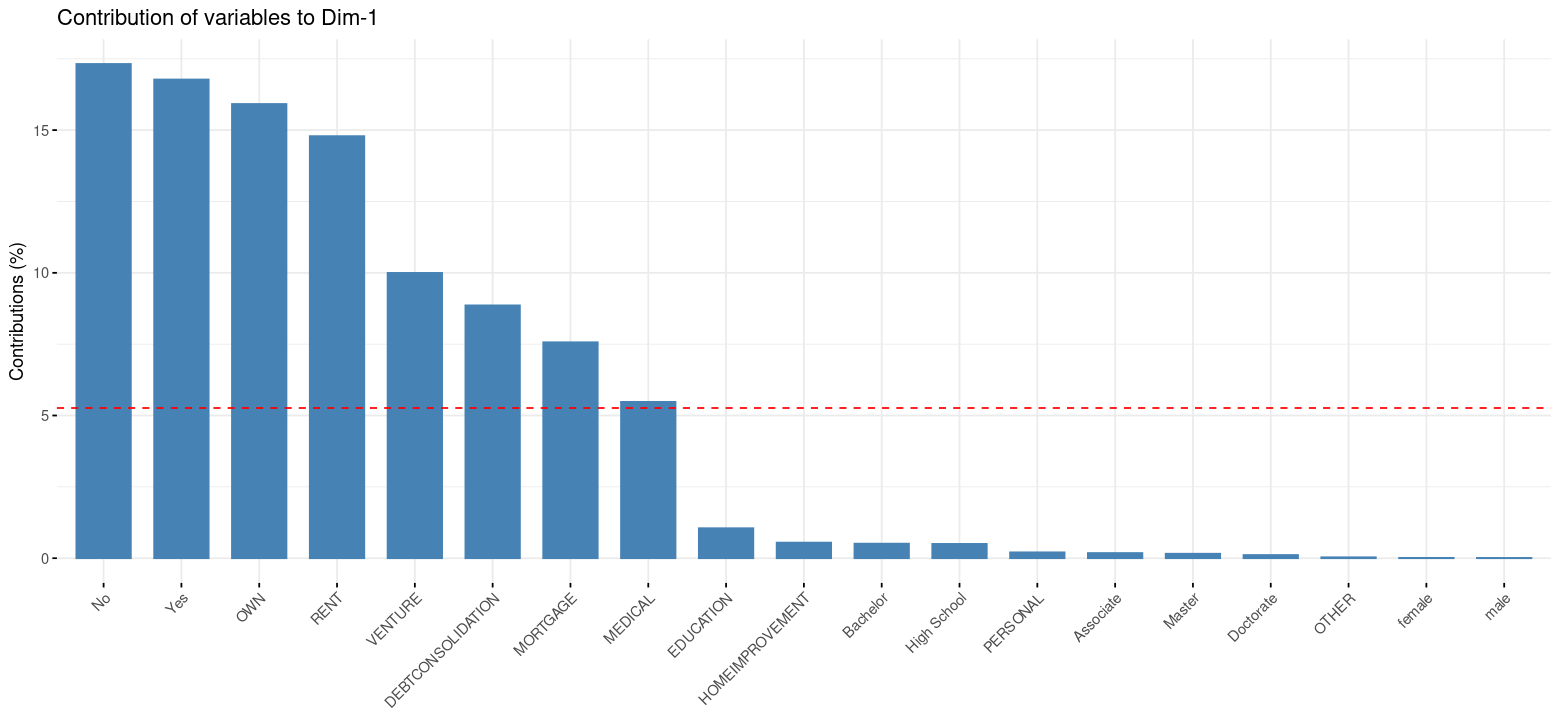

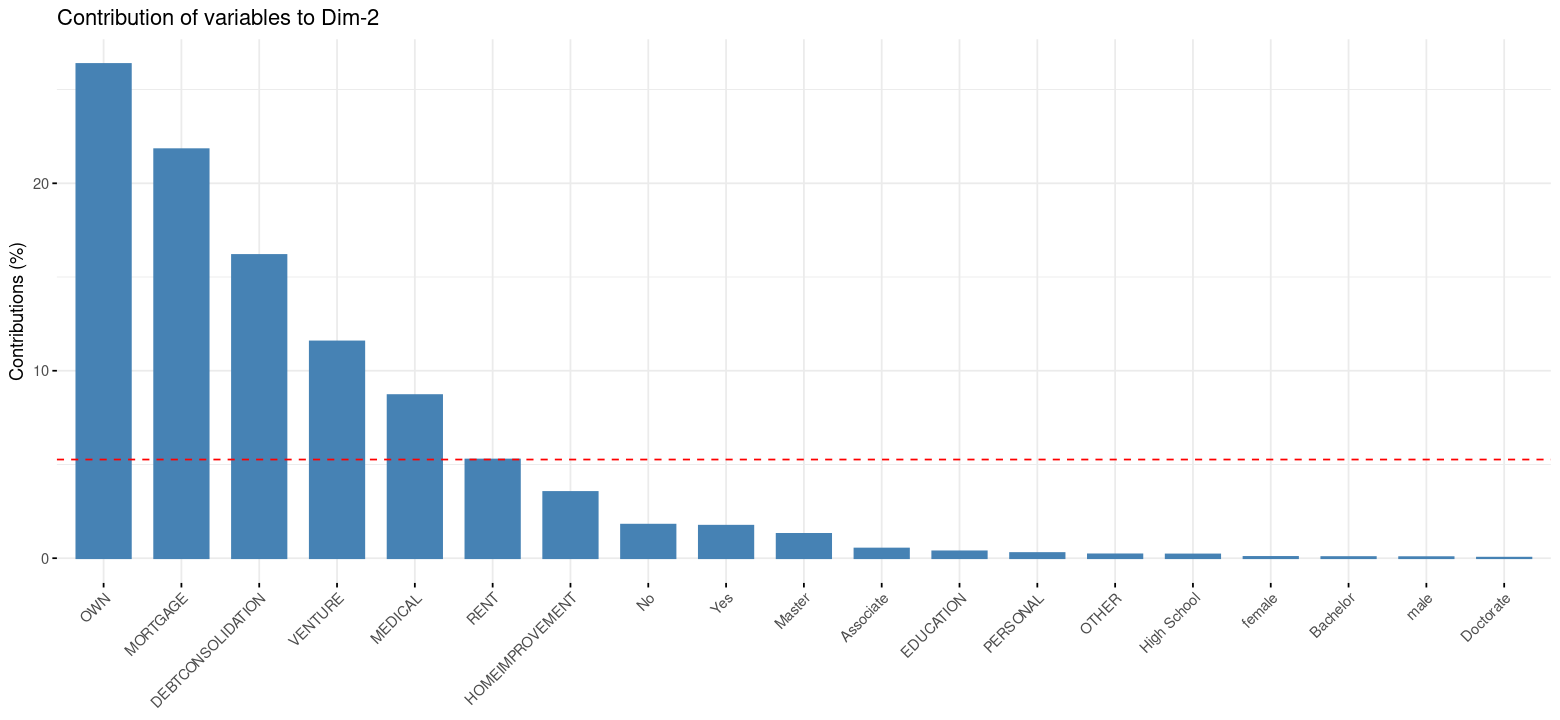

In [31]:
## TO BE COMPLETED ##
# Contributions to dimension 1
fviz_contrib(res.mca, choice="var", axes=1, top=20)

# Contributions to dimension 2
fviz_contrib(res.mca, choice="var", axes=2, top=20)

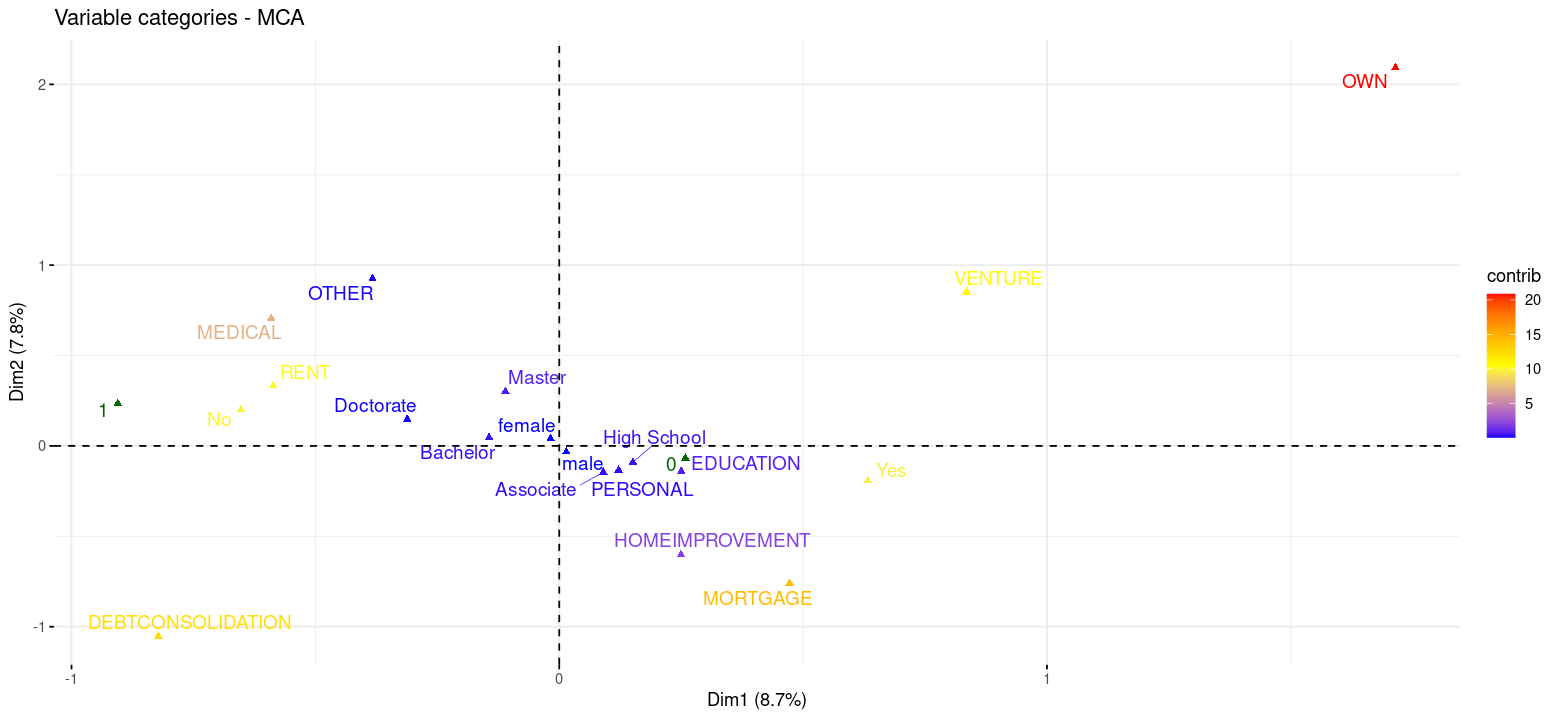

In [32]:
fviz_mca_var(res.mca, col.var = "contrib",
             gradient.cols = c("blue", "yellow", "red"), 
             repel = TRUE)

In [33]:
res.mca.sup.quanti = MCA(loan, ,quanti.sup = c(1,4,5,7,9,10,11,12), graph = FALSE) #POUR LES VARIABLES QUALITATIVES

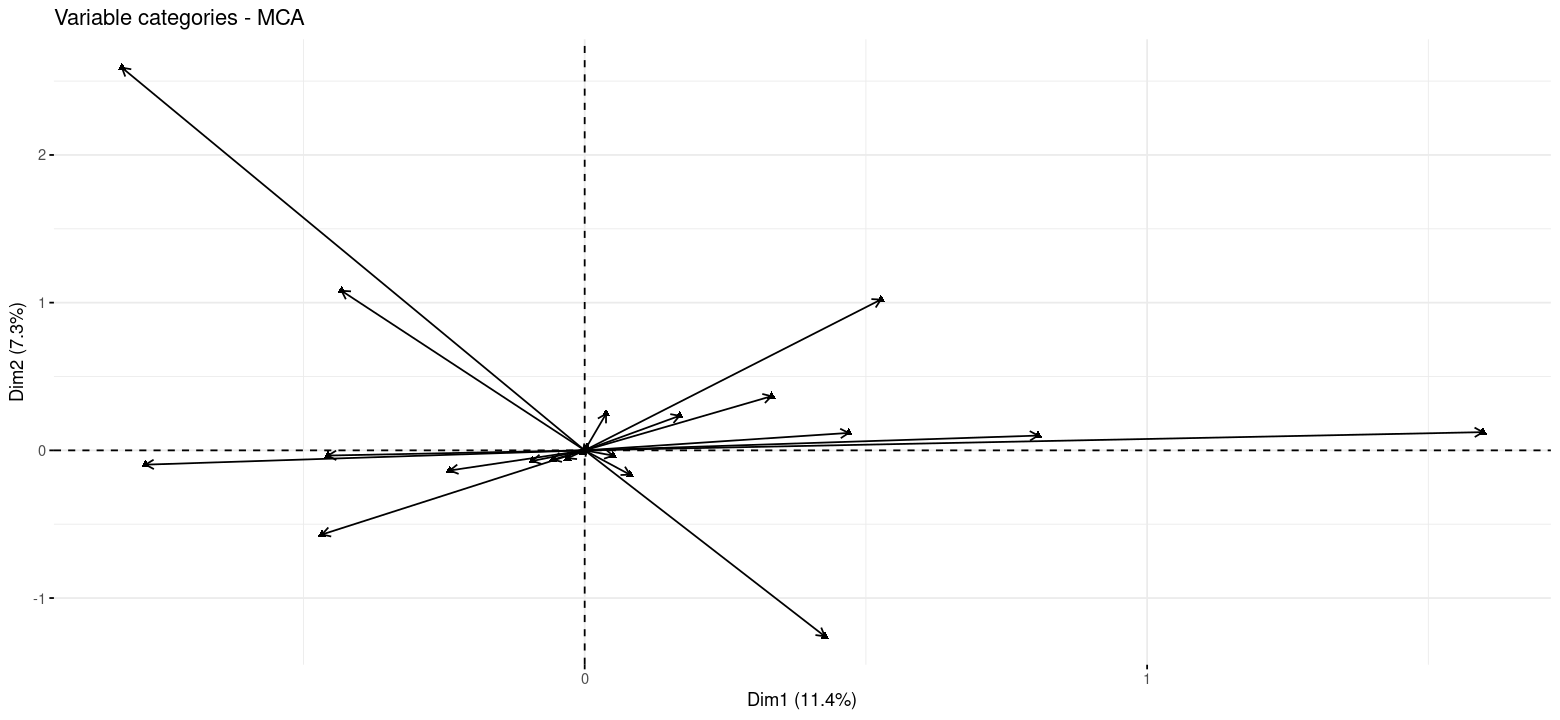

In [34]:
fviz_mca_var(res.mca.sup.quanti,
             repel = TRUE,
             col.var = "black",  # modalités actives en noir
             col.quanti.sup = "blue",  # variables quantitatives en bleu
             geom = c("point", "arrow"),  # flèches pour les quanti
             ggtheme = theme_minimal())

In [35]:
res.mca.sup.quanti$quanti.sup$coord

Dim 1         Dim 2        Dim 3       
person_age                 -0.0012833740 -0.011760007  0.123321838
person_income              -0.2990877161 -0.209299152  0.148382278
person_emp_exp             -0.0001126960 -0.006305331  0.111372318
loan_amnt                   0.0433198718 -0.051159474  0.104227624
loan_int_rate               0.2918389606  0.061661672  0.013359886
loan_percent_income         0.3202875292  0.123244706 -0.007002522
cb_person_cred_hist_length  0.0003751877 -0.005156714  0.105718739
credit_score                0.0852251891  0.036265782  0.106139441
                           Dim 4         Dim 5       
person_age                 -0.0236983703  0.010952328
person_income               0.0056417121  0.029172477
person_emp_exp             -0.0227692464  0.007892332
loan_amnt                   0.0154544115 -0.015739805
loan_int_rate               0.0145807214 -0.030053298
loan_percent_income         0.0191518267 -0.039984301
cb_person_cred_hist_length -0.0228729335  0.006468360
credit_score               -0.0002809229  0.120267343

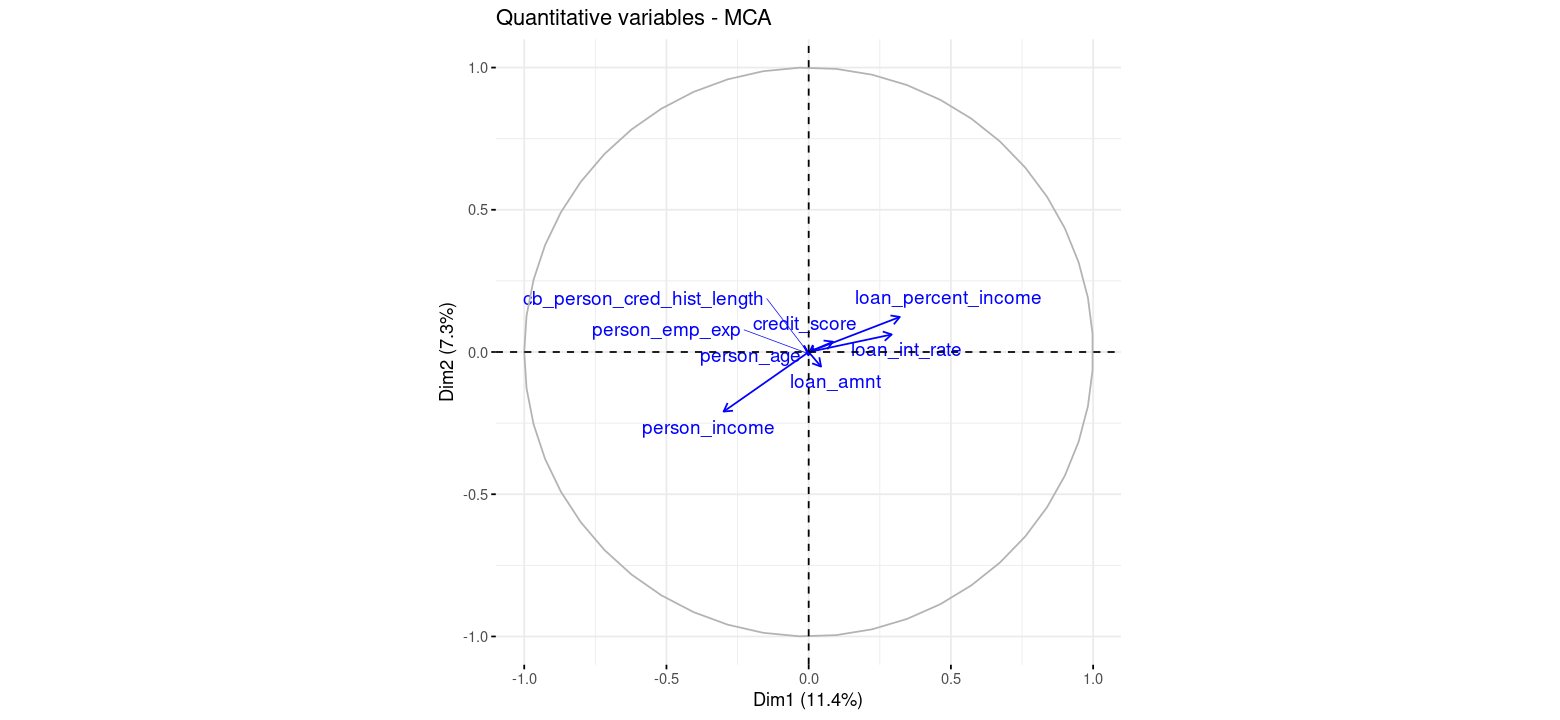

In [36]:
fviz_mca_var(res.mca.sup.quanti, 
             choice = "quanti.sup", 
             repel = TRUE,
             col.var = "blue",
             ggtheme = theme_minimal())

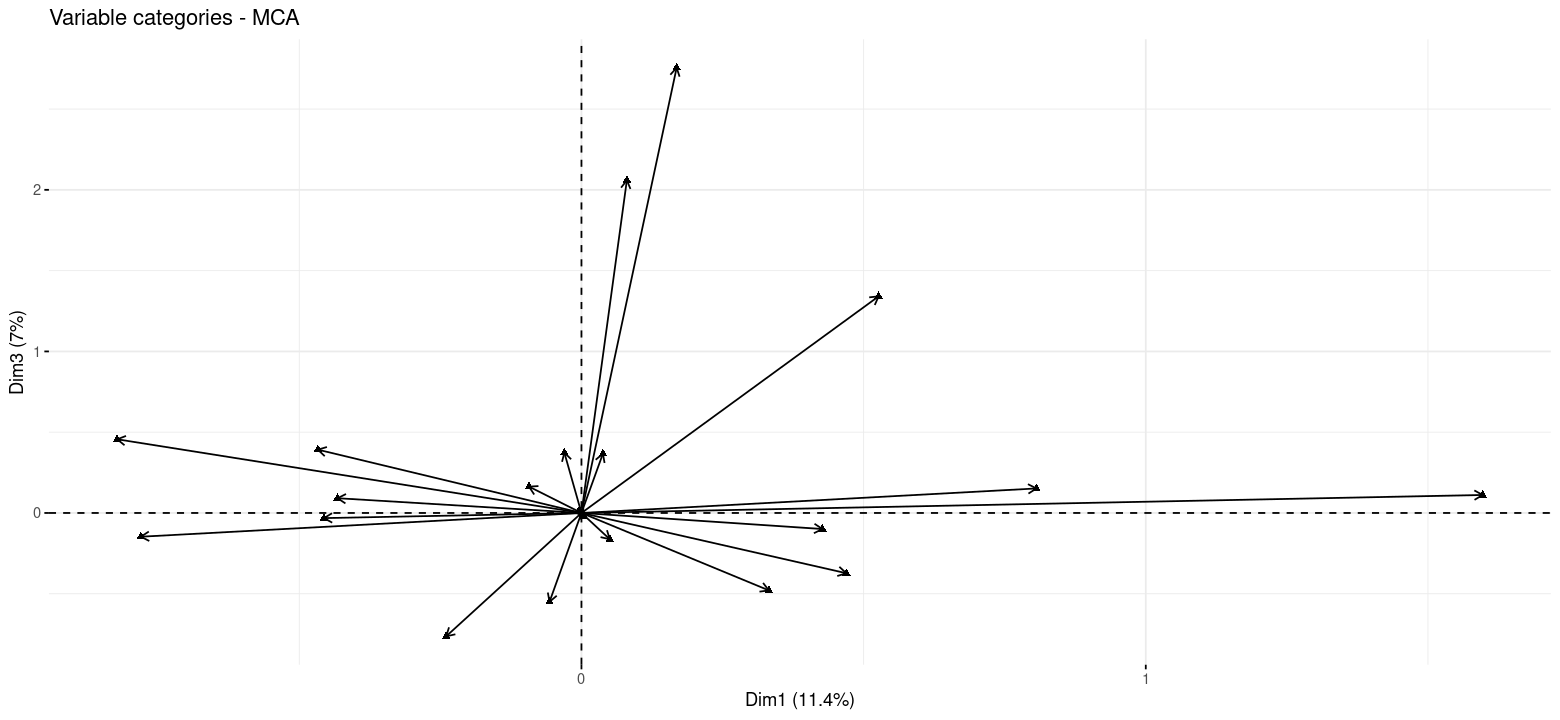

In [37]:
fviz_mca_var(res.mca.sup.quanti, axes = c(1, 3),
             col.var = "black",
             col.quanti.sup = "blue",
             geom = c("point", "arrow"),
             repel = TRUE)

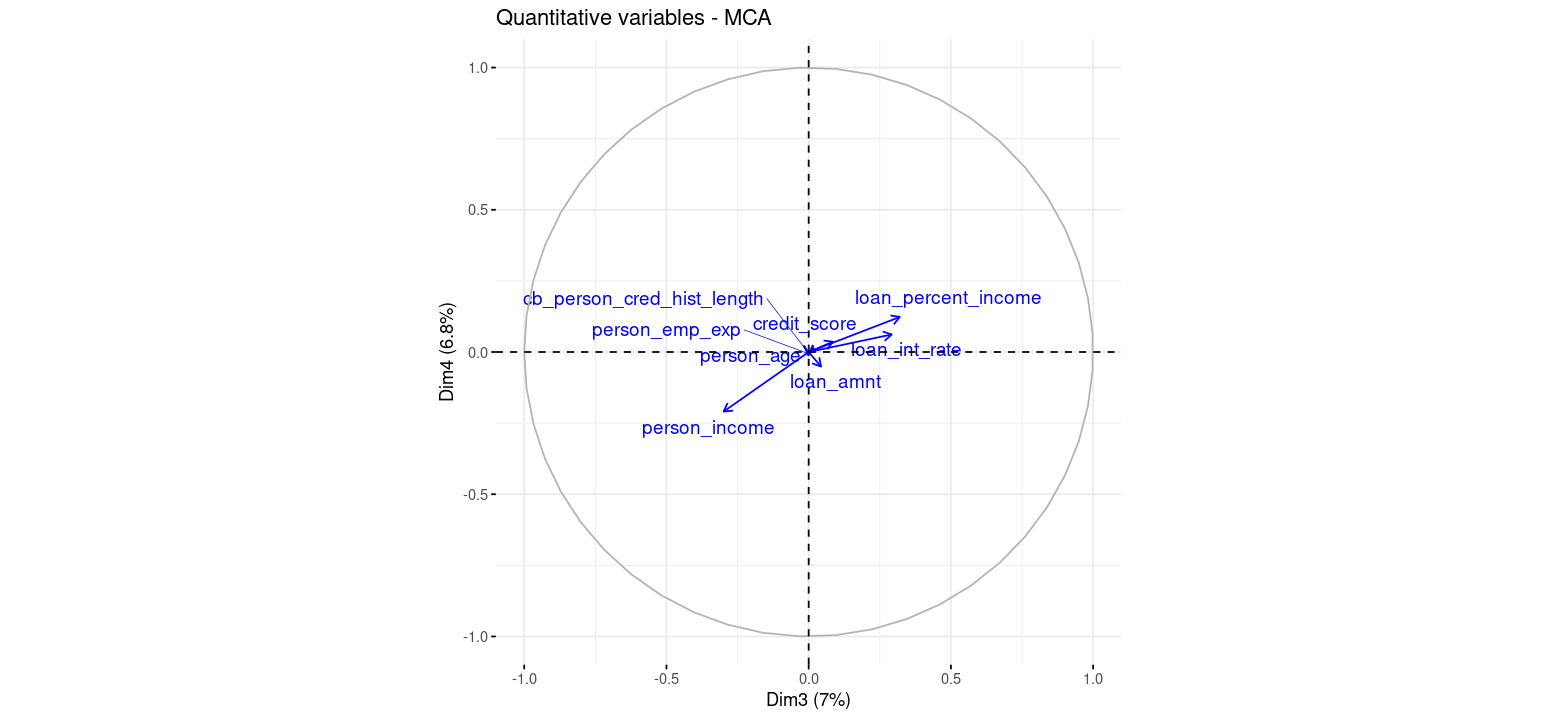

In [38]:
fviz_mca_var(res.mca.sup.quanti, axes = c(3,4),
             choice = "quanti.sup", 
             repel = TRUE,
             col.var = "blue",
             ggtheme = theme_minimal())

In [39]:
res.mca.sup = MCA(loan, ,quanti.sup = c(1,4,5,7,9,10,11,12), quali.sup = c(13,14), graph = FALSE) #POUR LES VARIABLES QUALITATIVES


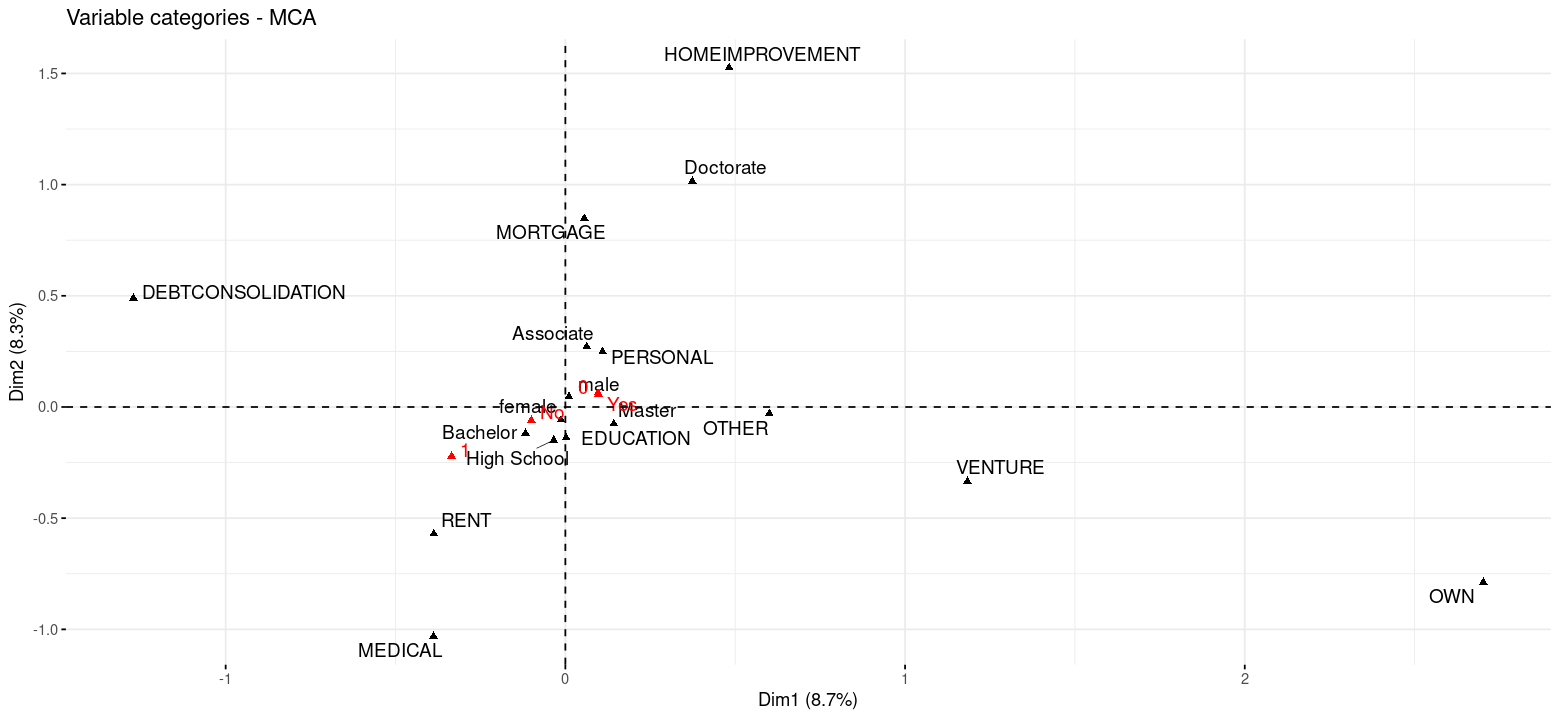

In [40]:
fviz_mca_var(res.mca.sup,
             col.var = "black",             # modalités actives
             col.quali.sup = "red",         # modalités supplémentaires
             repel = TRUE,
             ggtheme = theme_minimal())

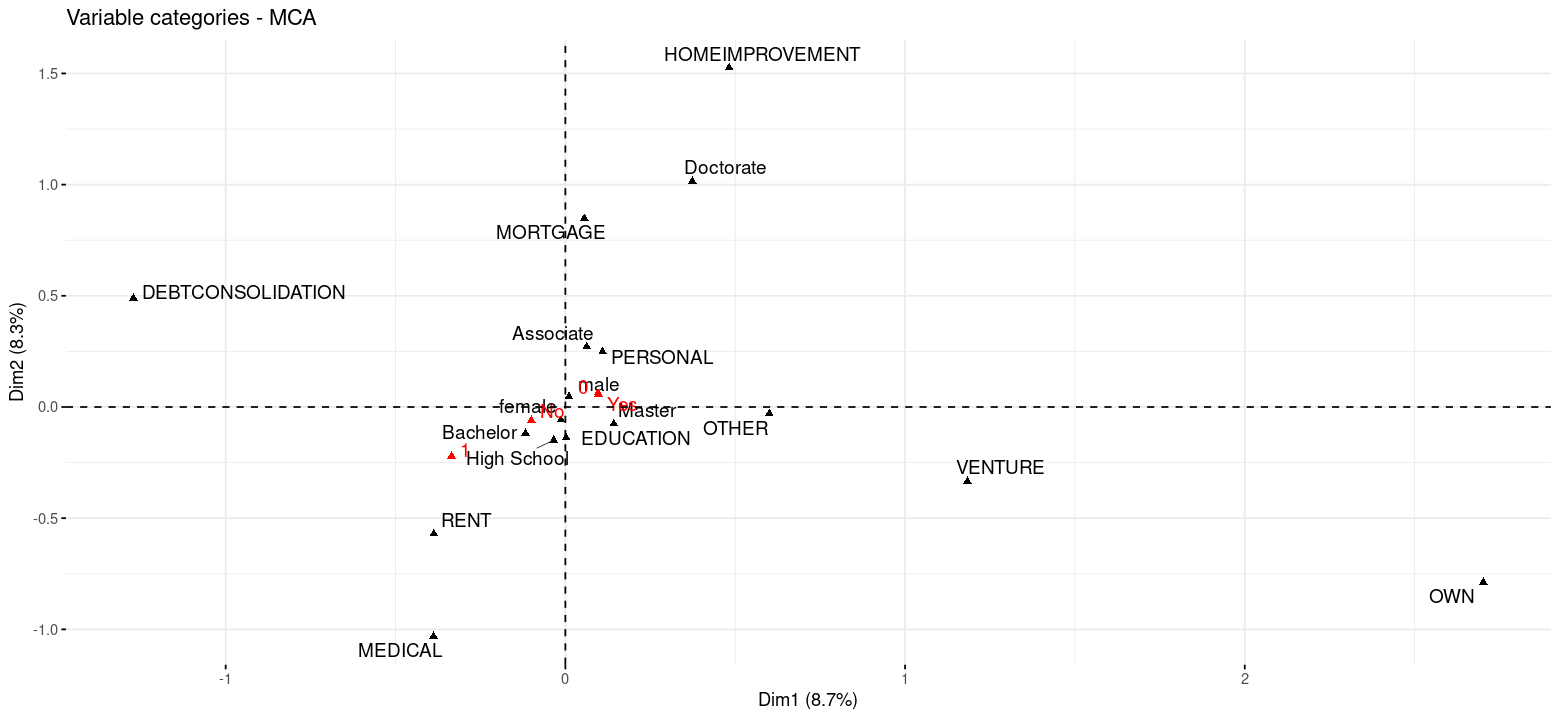

In [41]:
fviz_mca_var(res.mca.sup,
             col.var = "black",             # modalités actives
             col.quali.sup = "red",         # modalités supplémentaires en rouge
             repel = TRUE,
             ggtheme = theme_minimal())

# MFA


In [45]:
str(loan)

'data.frame':	44993 obs. of  14 variables:
 $ person_age                    : num  22 21 25 23 24 21 26 24 24 21 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ person_emp_exp                : int  0 0 3 0 1 0 1 5 3 0 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_intent                   : Factor w/ 6 levels "DEBTCONSOLIDATION",..: 5 2 4 4 4 6 2 4 5 6 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ cb_person_cred_hist_length    : num  3 2 3 2 4 2 3 4 2 3 ...
 $ credit_score     

In [76]:
age_breaks <- c(0, 23, 25, 28, 35, 94)
age_labels <- c("very young", "young", "adult", "middle-aged", "old")

# Tạo factor mới trên cơ sở cột age
loan$age1 <- cut(
  loan$person_age,
  breaks = age_breaks,
  labels = age_labels,
  right = TRUE,      # ]a, b]
  include.lowest = FALSE
)

# 2. Định nghĩa các khoảng và nhãn cho kinh nghiệm làm việc
exp_breaks <- c(-1, 2, 4, 7, 13, 76)
exp_labels <- c("very small", "small", "quite small", "medium", "long")

loan$emp_exp1 <- cut(
  loan$person_emp_exp,
  breaks = exp_breaks,
  labels = exp_labels,
  right = TRUE,
  include.lowest = FALSE
)
hist_breaks <- c(-1, 2, 3, 4, 7, 11, 30)
hist_labels <- c("very short", "short", "quite short", "medium", "long", "very long")

loan$cred_hist1 <- cut(
  loan$cb_person_cred_hist_length,
  breaks = hist_breaks,
  labels = hist_labels,
  right = TRUE,
  include.lowest = FALSE
)

# 2. Định nghĩa khoảng và nhãn cho điểm tín dụng
score_breaks <- c(0, 550, 600, 625, 650, 675, 784)
score_labels <- c("very low", "low", "quite low", "medium", "high", "insane")

loan$score1 <- cut(
  loan$credit_score,
  breaks = score_breaks,
  labels = score_labels,
  right = TRUE,
  include.lowest = FALSE
)
str(loan)



'data.frame':	44993 obs. of  18 variables:
 $ person_age                    : num  22 21 25 23 24 21 26 24 24 21 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ person_emp_exp                : int  0 0 3 0 1 0 1 5 3 0 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_intent                   : Factor w/ 6 levels "DEBTCONSOLIDATION",..: 5 2 4 4 4 6 2 4 5 6 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ cb_person_cred_hist_length    : num  3 2 3 2 4 2 3 4 2 3 ...
 $ credit_score     

   person_age    person_gender     person_education person_income   
 Min.   :20.00   female:20157   Associate  :12026   Min.   : 8.987  
 1st Qu.:24.00   male  :24836   Bachelor   :13396   1st Qu.:10.762  
 Median :26.00                  Doctorate  :  621   Median :11.113  
 Mean   :27.75                  High School:11970   Mean   :11.122  
 3rd Qu.:30.00                  Master     : 6980   3rd Qu.:11.470  
 Max.   :94.00                                      Max.   :14.711  
 person_emp_exp   person_home_ownership   loan_amnt    
 Min.   : 0.000   MORTGAGE:18485        Min.   :  500  
 1st Qu.: 1.000   OTHER   :  117        1st Qu.: 5000  
 Median : 4.000   OWN     : 2951        Median : 8000  
 Mean   : 5.395   RENT    :23440        Mean   : 9583  
 3rd Qu.: 8.000                         3rd Qu.:12237  
 Max.   :76.000                         Max.   :35000  
            loan_intent   loan_int_rate   loan_percent_income
 DEBTCONSOLIDATION:7145   Min.   : 5.42   Min.   :0.0000     
 

In [212]:
#str(loan)
loan_mfa = data.frame(loan[,c(15,2,3,16)],loan[,c(4,7,9,10)],loan[,c(13,17,18,14)],loan[,c(8,6)])
str(loan_mfa)

'data.frame':	44993 obs. of  14 variables:
 $ age1                          : Factor w/ 5 levels "very young","young",..: 1 1 2 1 2 1 3 2 2 1 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ emp_exp1                      : Factor w/ 5 levels "very small","small",..: 1 1 2 1 1 1 1 3 2 1 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ previous_loan_defaults_on_file: Factor w/ 2 levels "No","Yes": 1 2 1 1 1 1 1 1 1 1 ...
 $ cred_hist1                    : Factor w/ 6 levels "very short","short",..: 2 1 2 1 3 1 2 3 1 2 ...
 $ score1                 

In [114]:
#help(MFA)

In [214]:

res.mfa <- MFA(
  loan_mfa,
  group      = c(4, 4, 4, 2),    # vẫn 13 biến chia thành 4 nhóm
  type       = c("n", "s", "n", "n"),
  name.group = c("Personals", "Financials", "Credit", "Detail"),
  graph      = FALSE
)

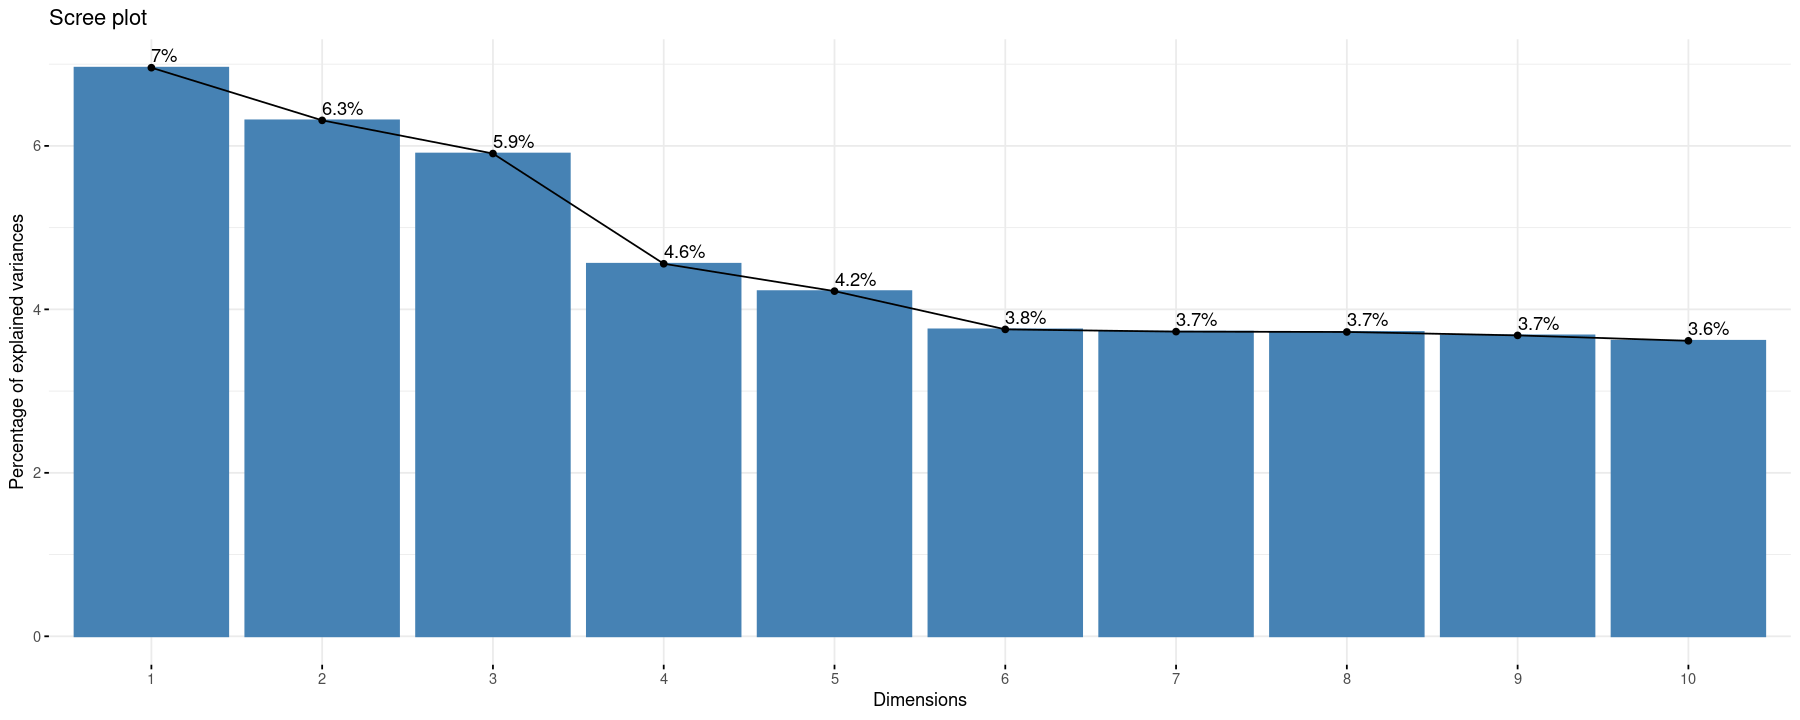

In [215]:
fviz_screeplot(res.mfa, addlabels = TRUE)

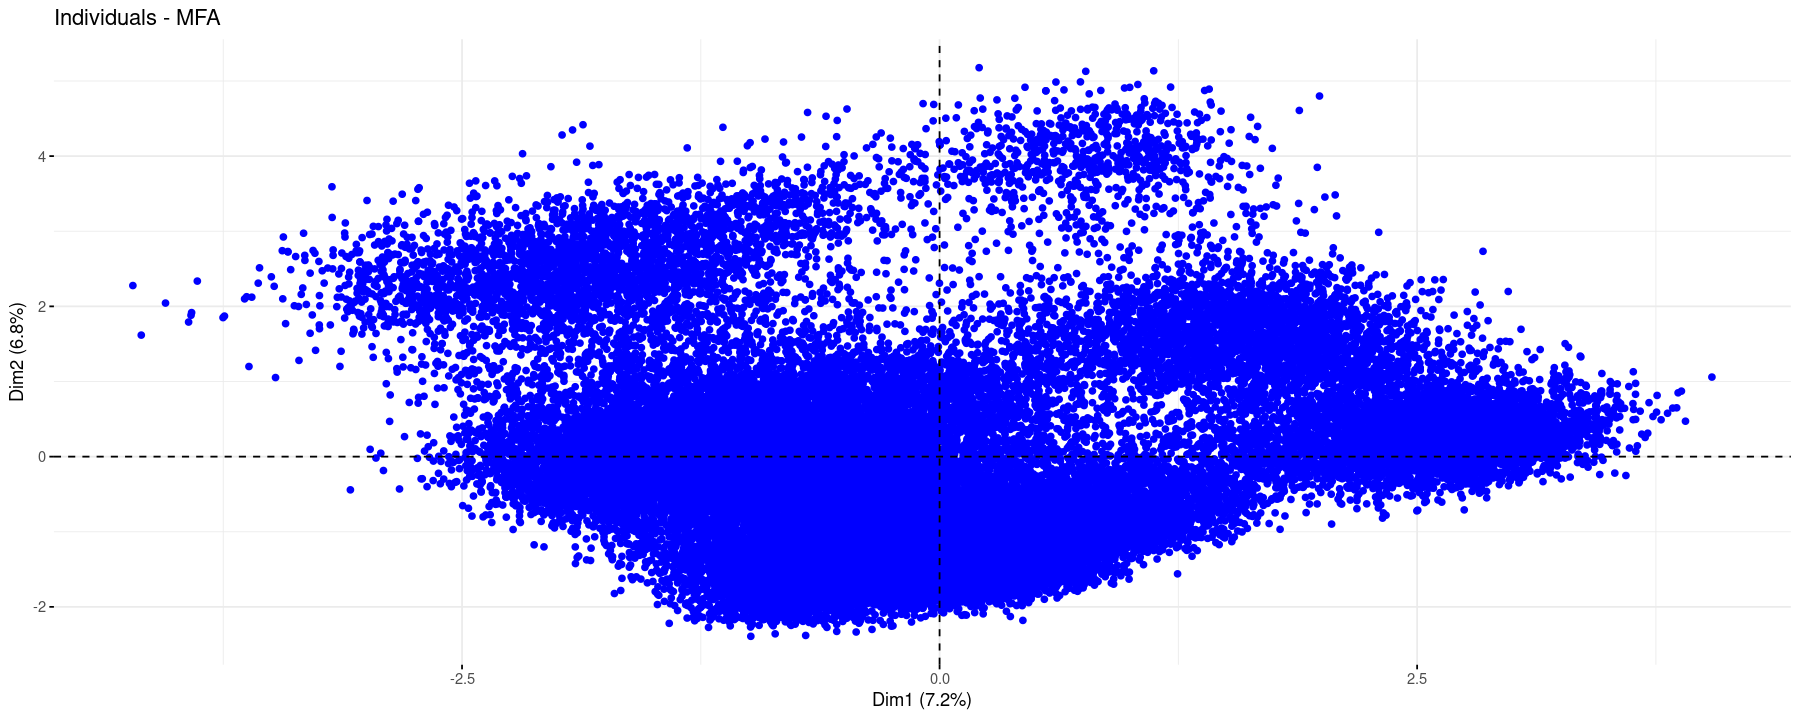

In [193]:
#fviz_mfa_ind(res.mfa, label = "none")
fviz_mfa_ind(res.mfa, label = "none", repel = TRUE)

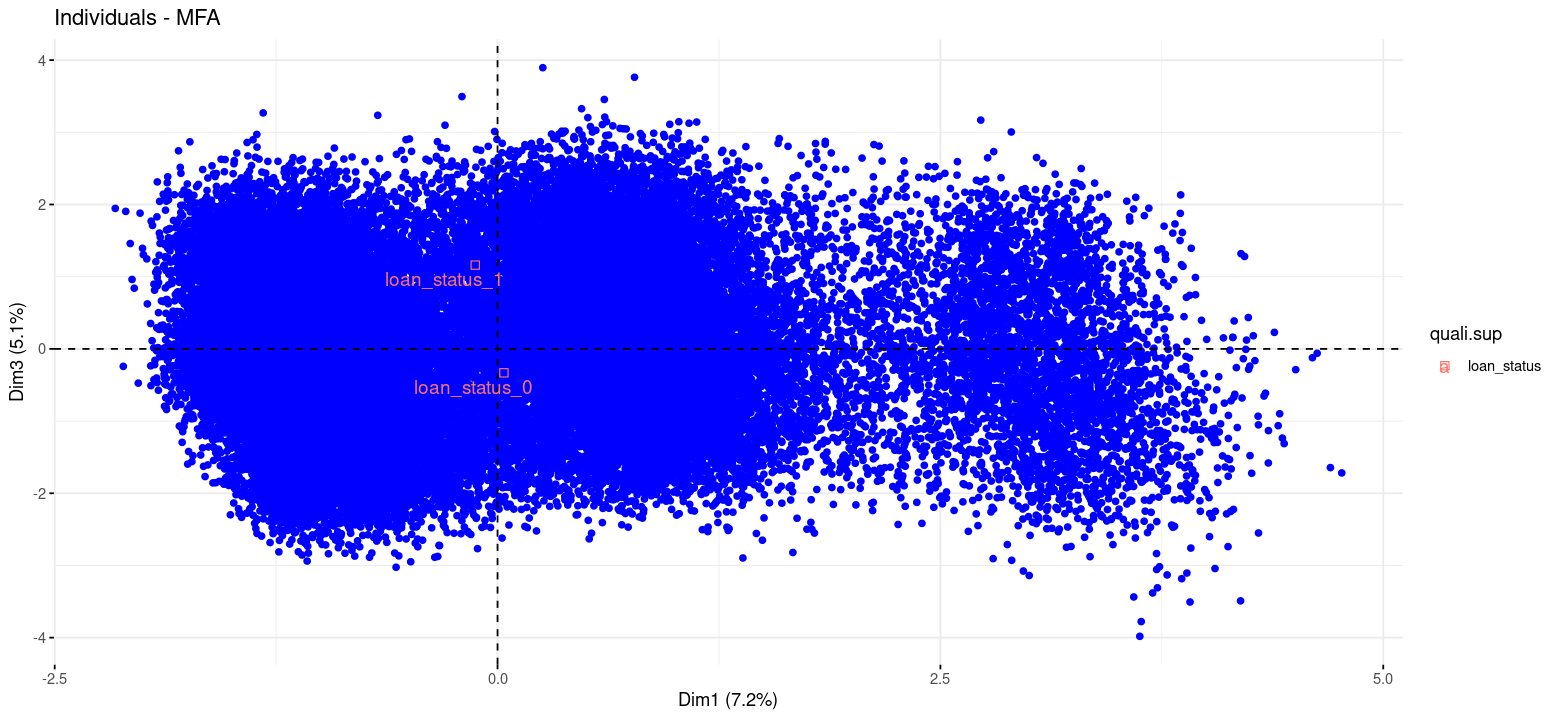

In [122]:
fviz_mfa_ind(res.mfa, label = "none",axes = c(1,3), repel = TRUE)

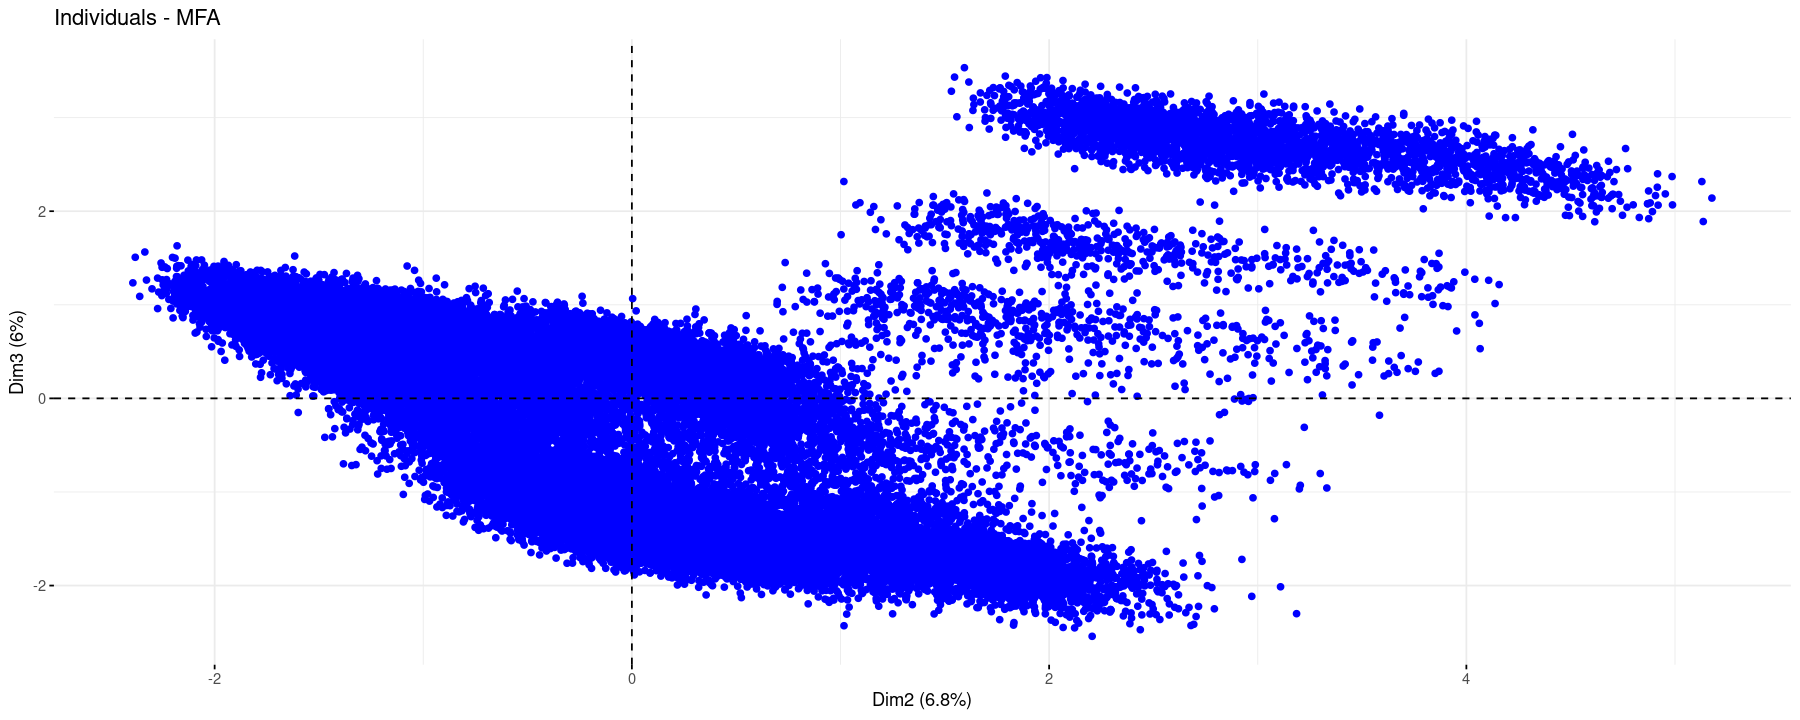

In [194]:
fviz_mfa_ind(res.mfa, label = "none",axes = c(2,3), repel = TRUE)

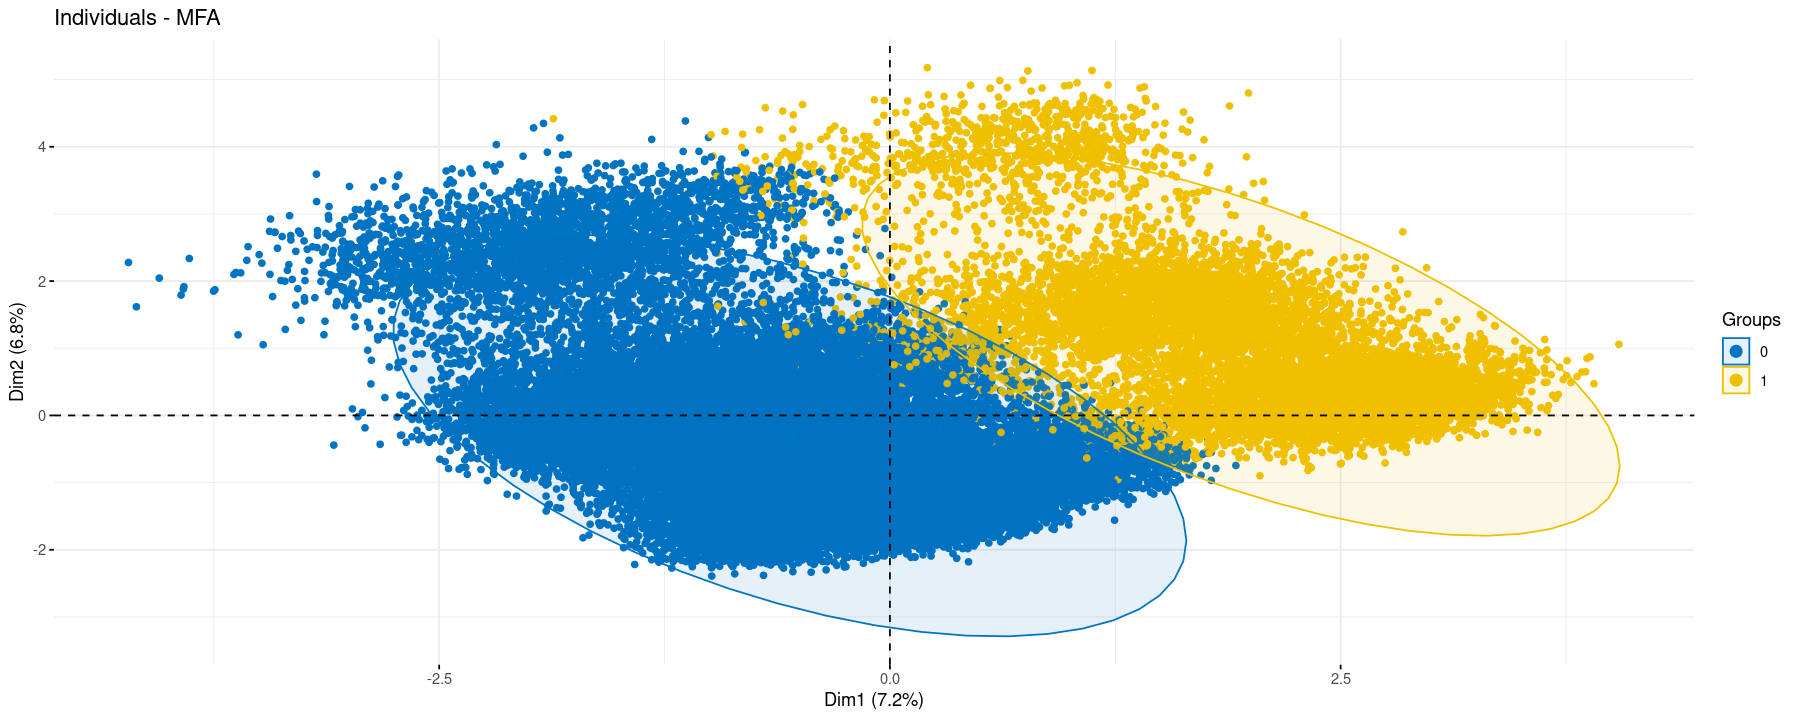

In [195]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$loan_status,
             addEllipses = TRUE,
             palette = "jco")

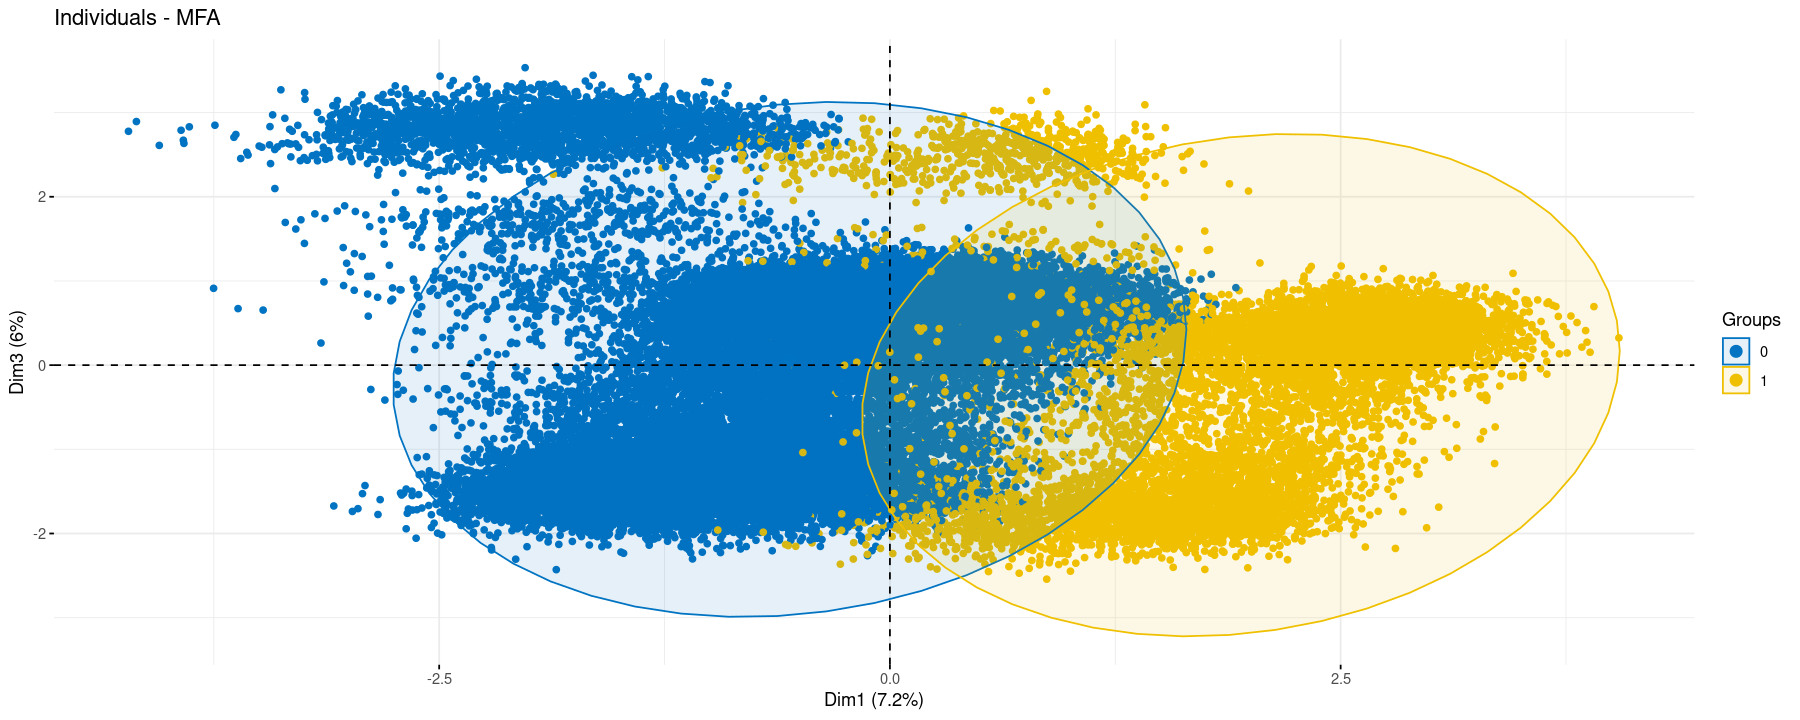

In [196]:
fviz_mfa_ind(res.mfa,
             label = "none",axes = c(1,3),
             habillage = loan_quali$loan_status,
             addEllipses = TRUE,
             palette = "jco")

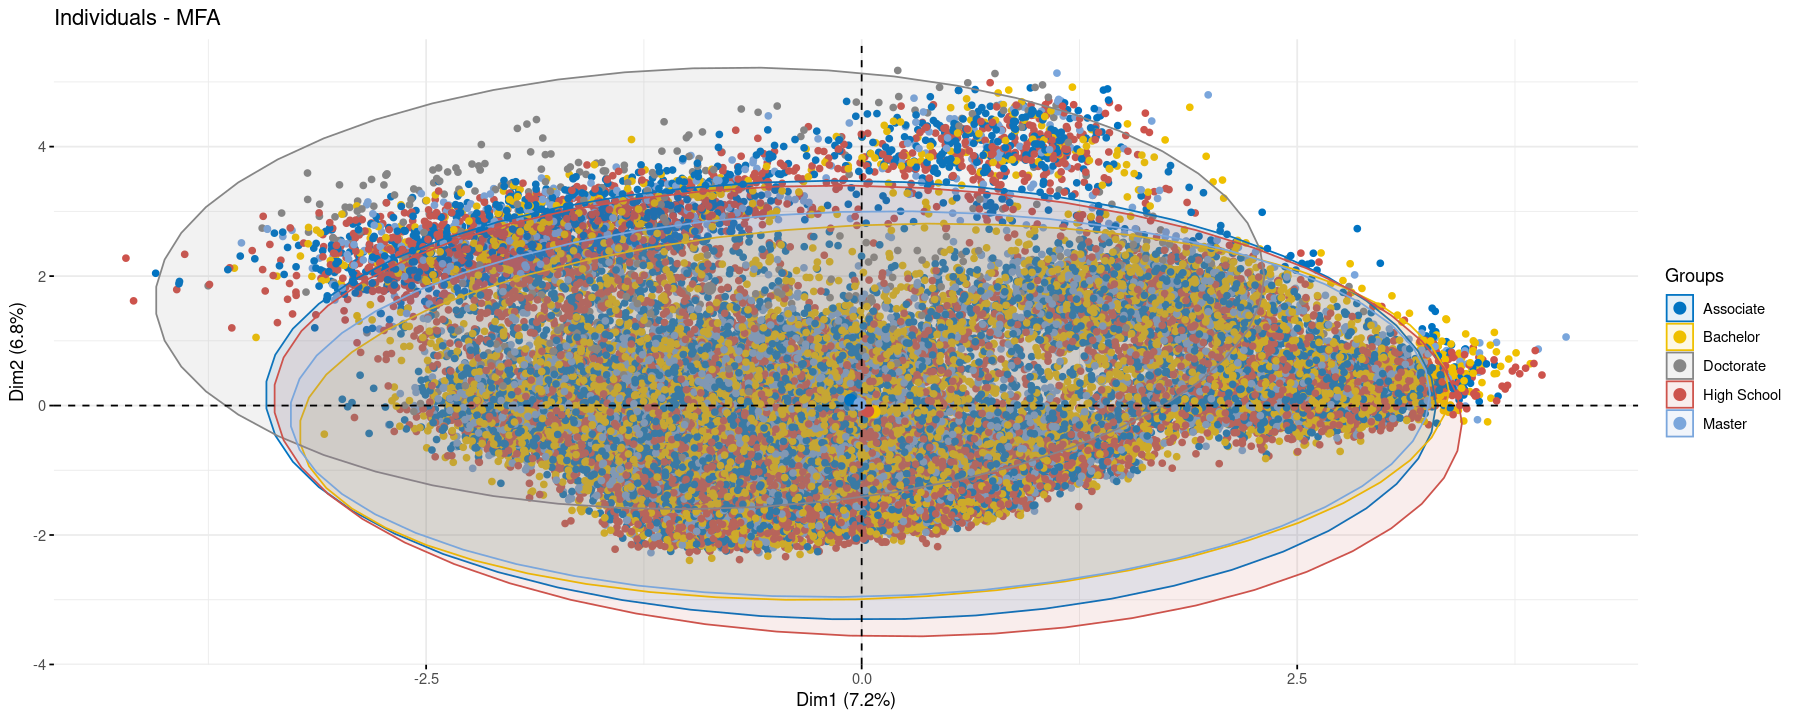

In [197]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$person_education,
             addEllipses = TRUE,
             palette = "jco")

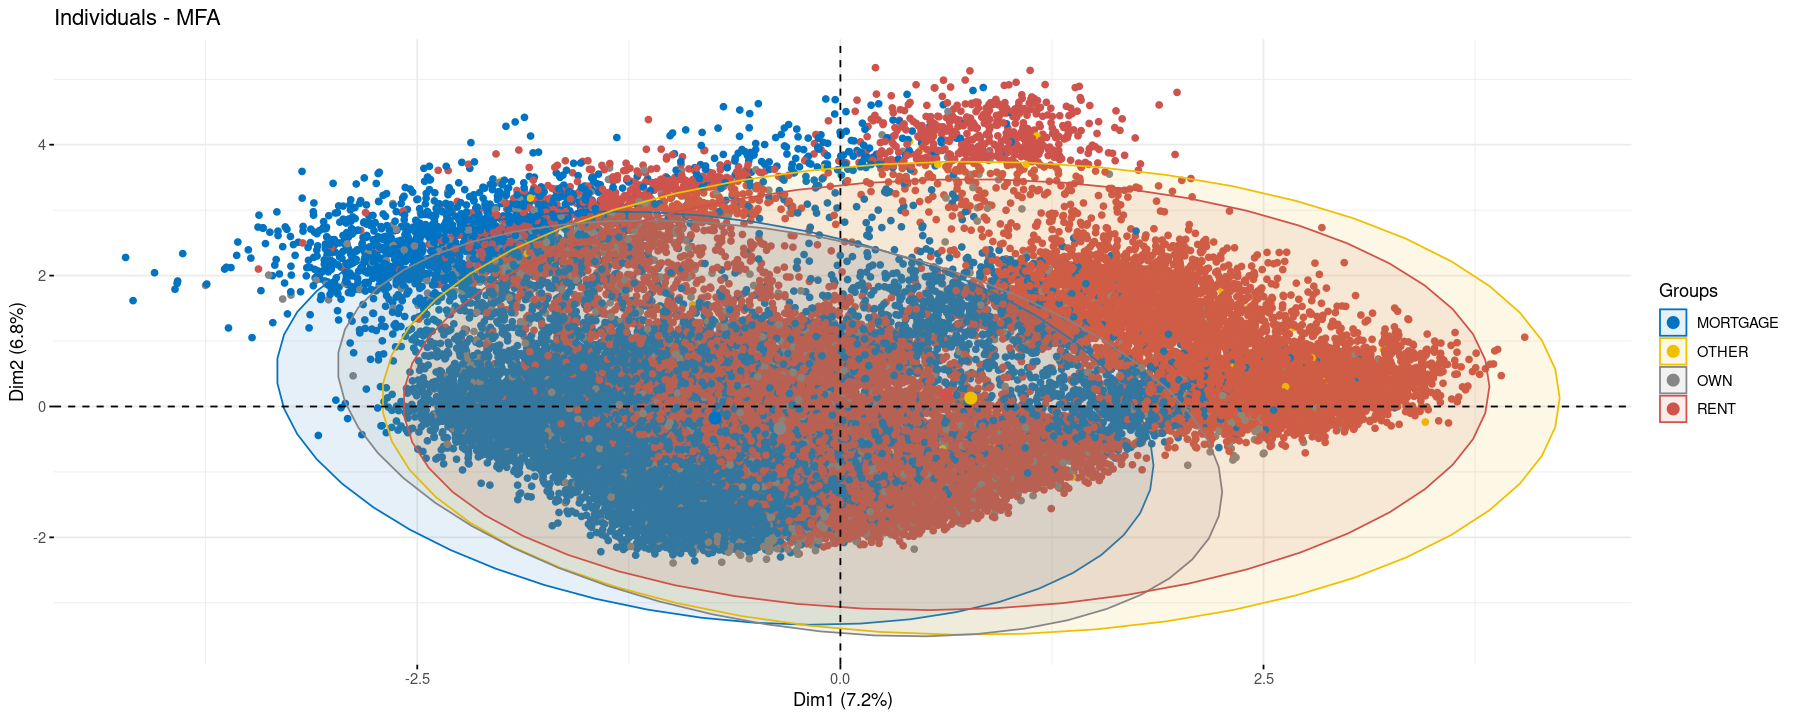

In [198]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$person_home_ownership,
             addEllipses = TRUE,
             palette = "jco")

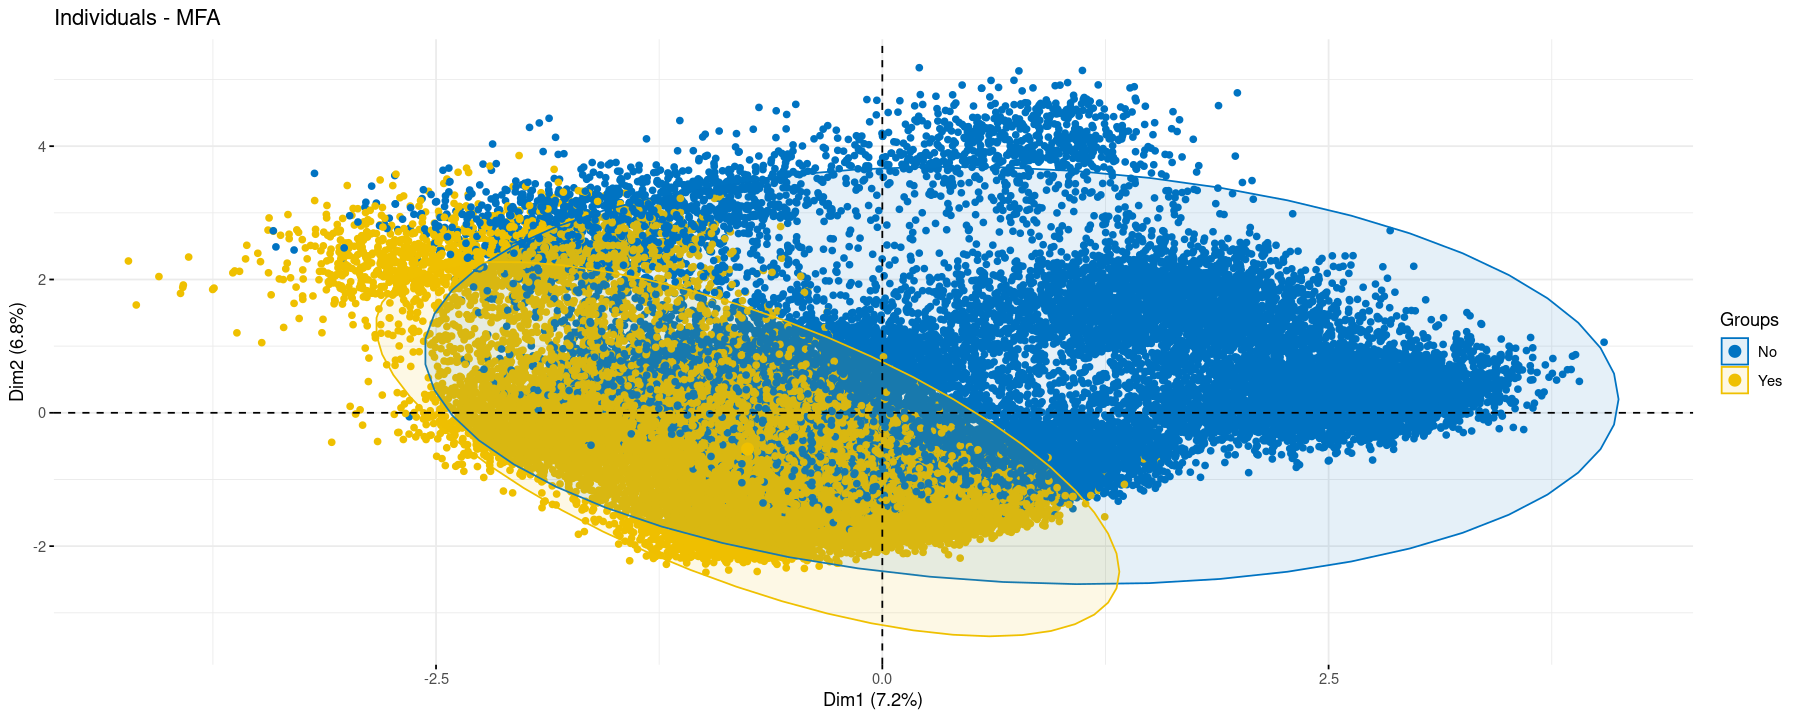

In [199]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$previous_loan_defaults_on_file,
             addEllipses = TRUE,
             palette = "jco")

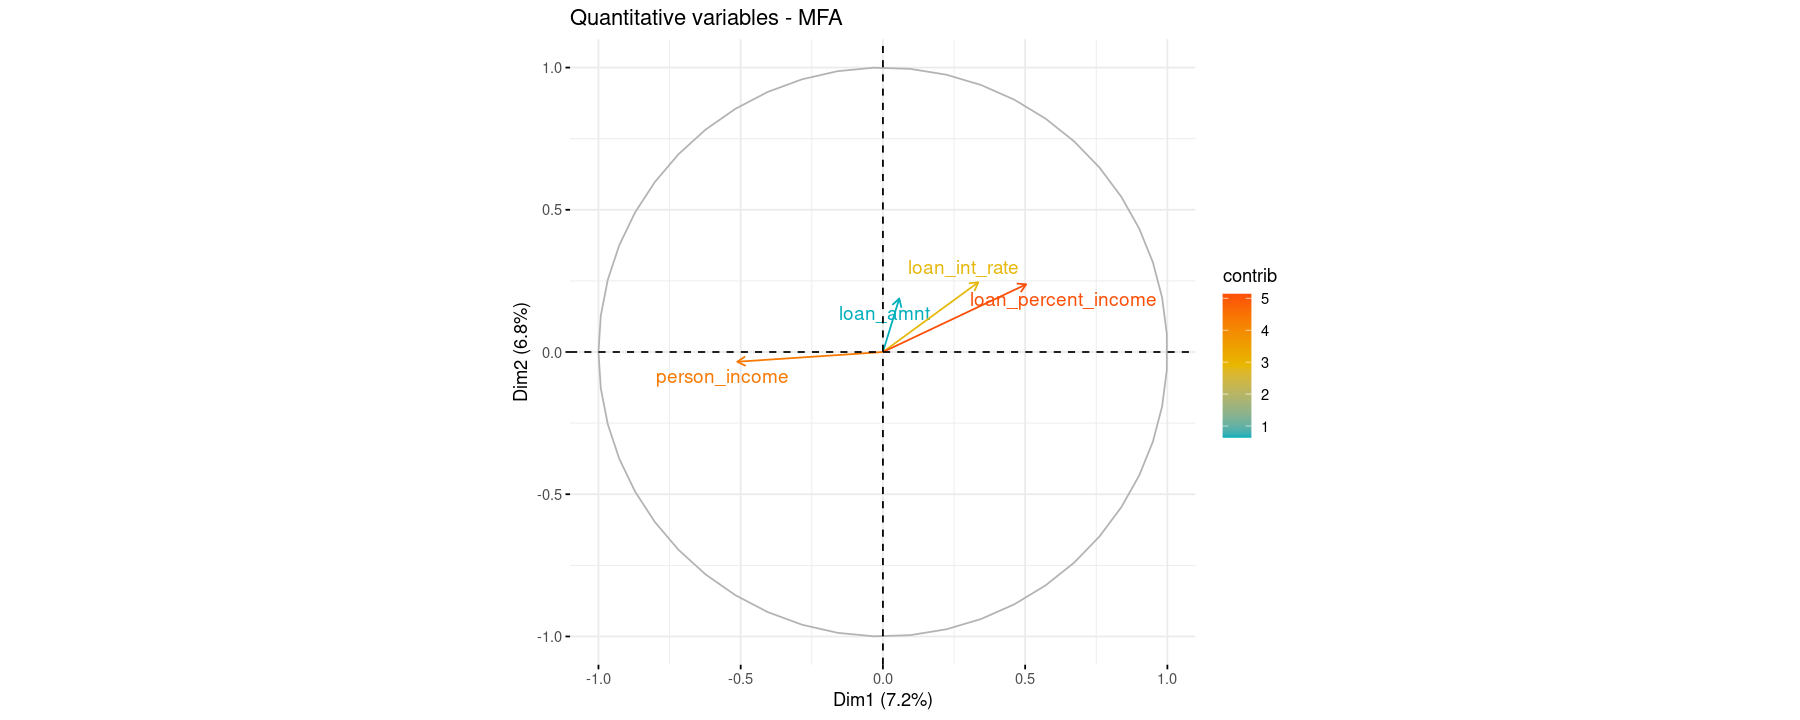

In [200]:
fviz_mfa_var(res.mfa, "quanti.var", repel = TRUE,
             col.var = "contrib", gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

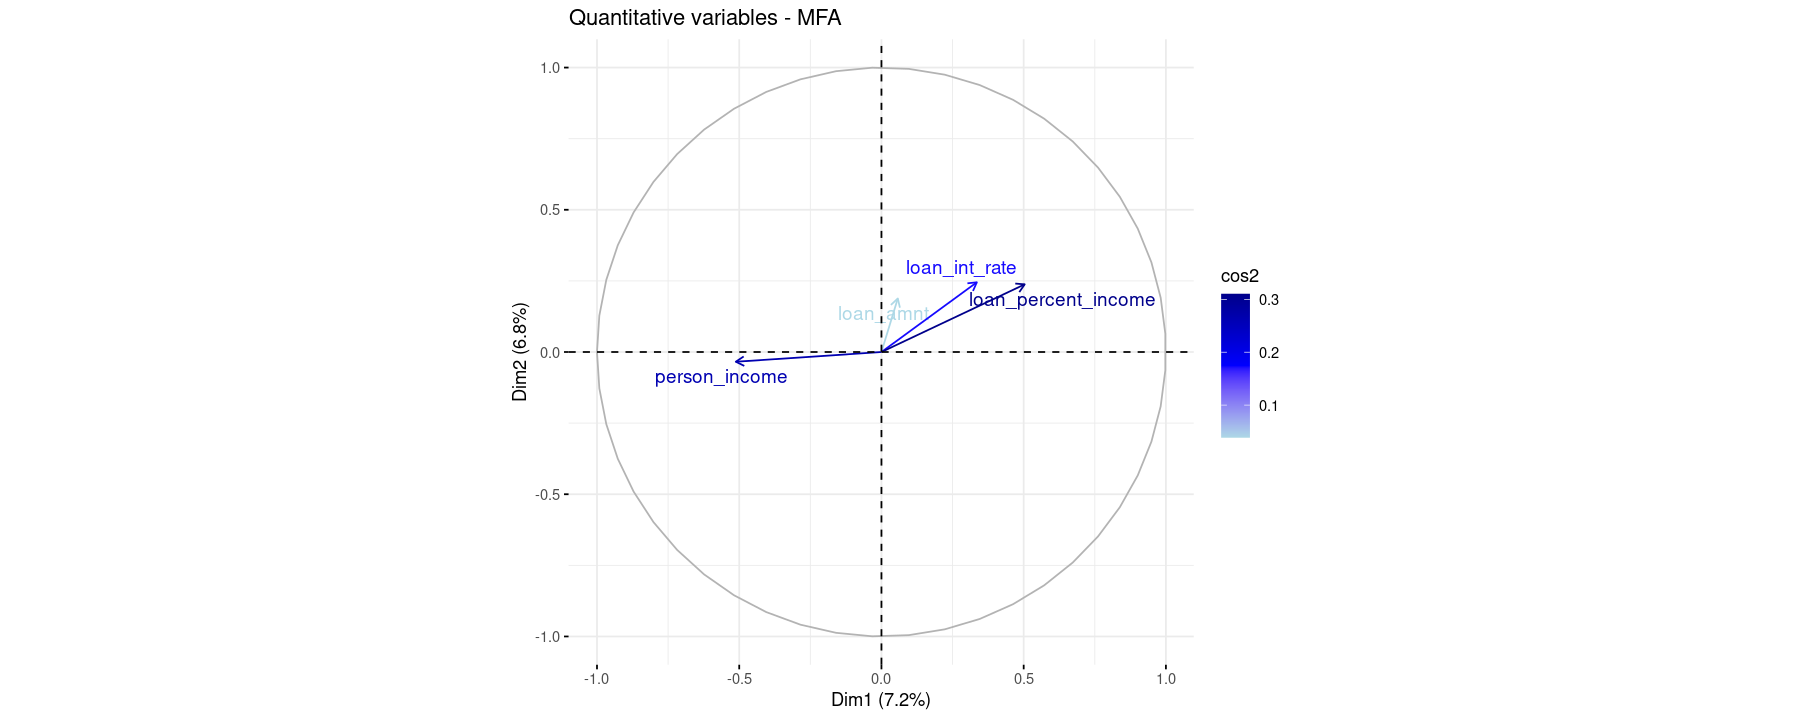

In [201]:
fviz_mfa_var(res.mfa,repel = TRUE,
             col.var = "cos2", gradient.cols = c("lightblue", "blue", "darkblue"))

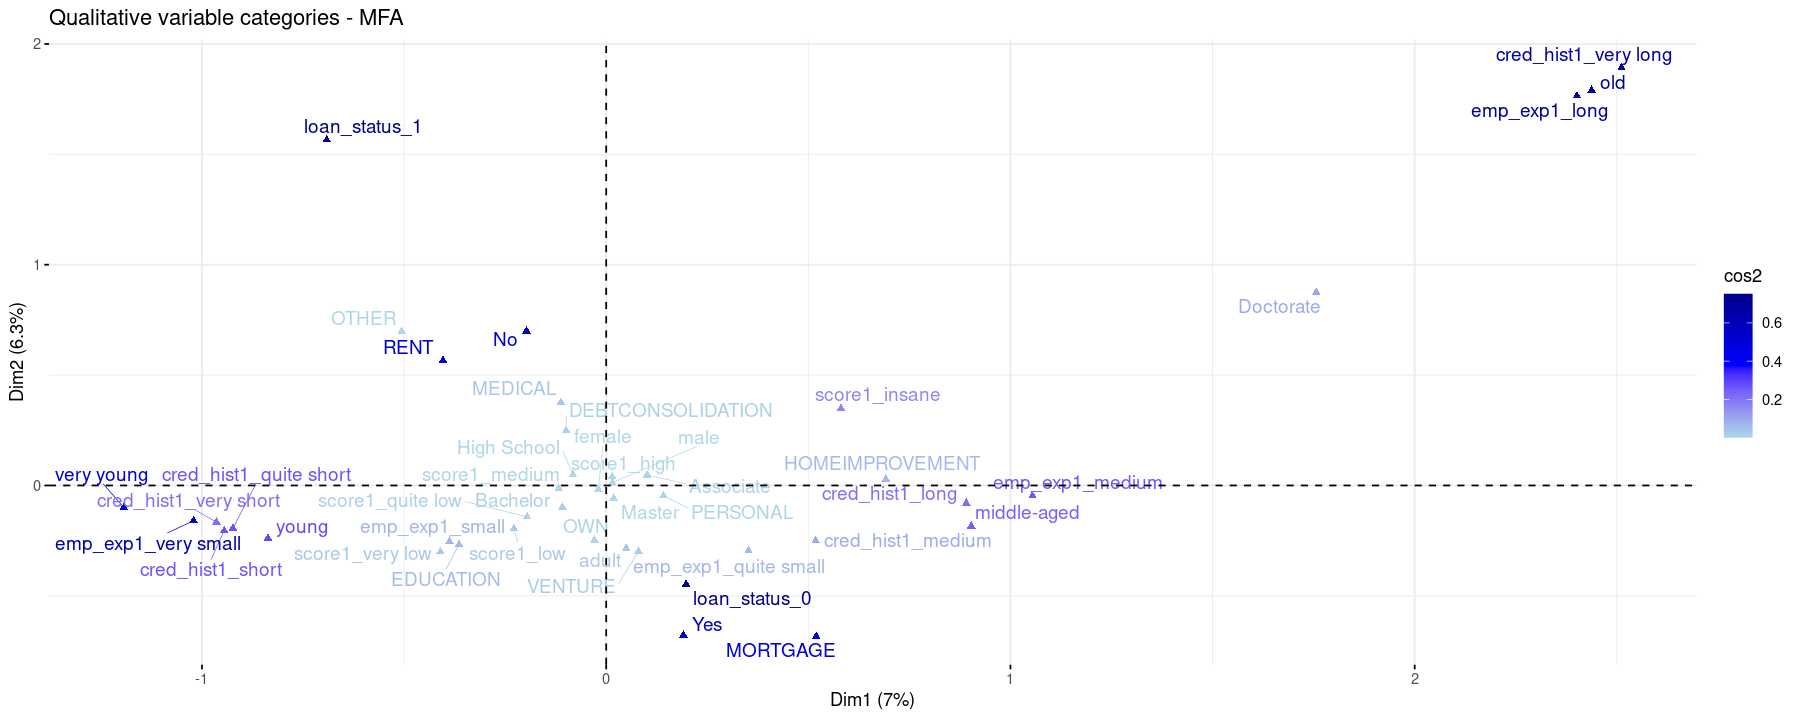

In [216]:
fviz_mfa_var(res.mfa, "quali.var",repel = TRUE,
             col.var = "cos2", gradient.cols = c("lightblue", "blue", "darkblue"))

Les personnes ayant une hypothèque ou un défaut de paiement sont plutôt refusées par la banque. Celles qui sont locataires ont tendance à ne pas avoir de défaut de paiement.

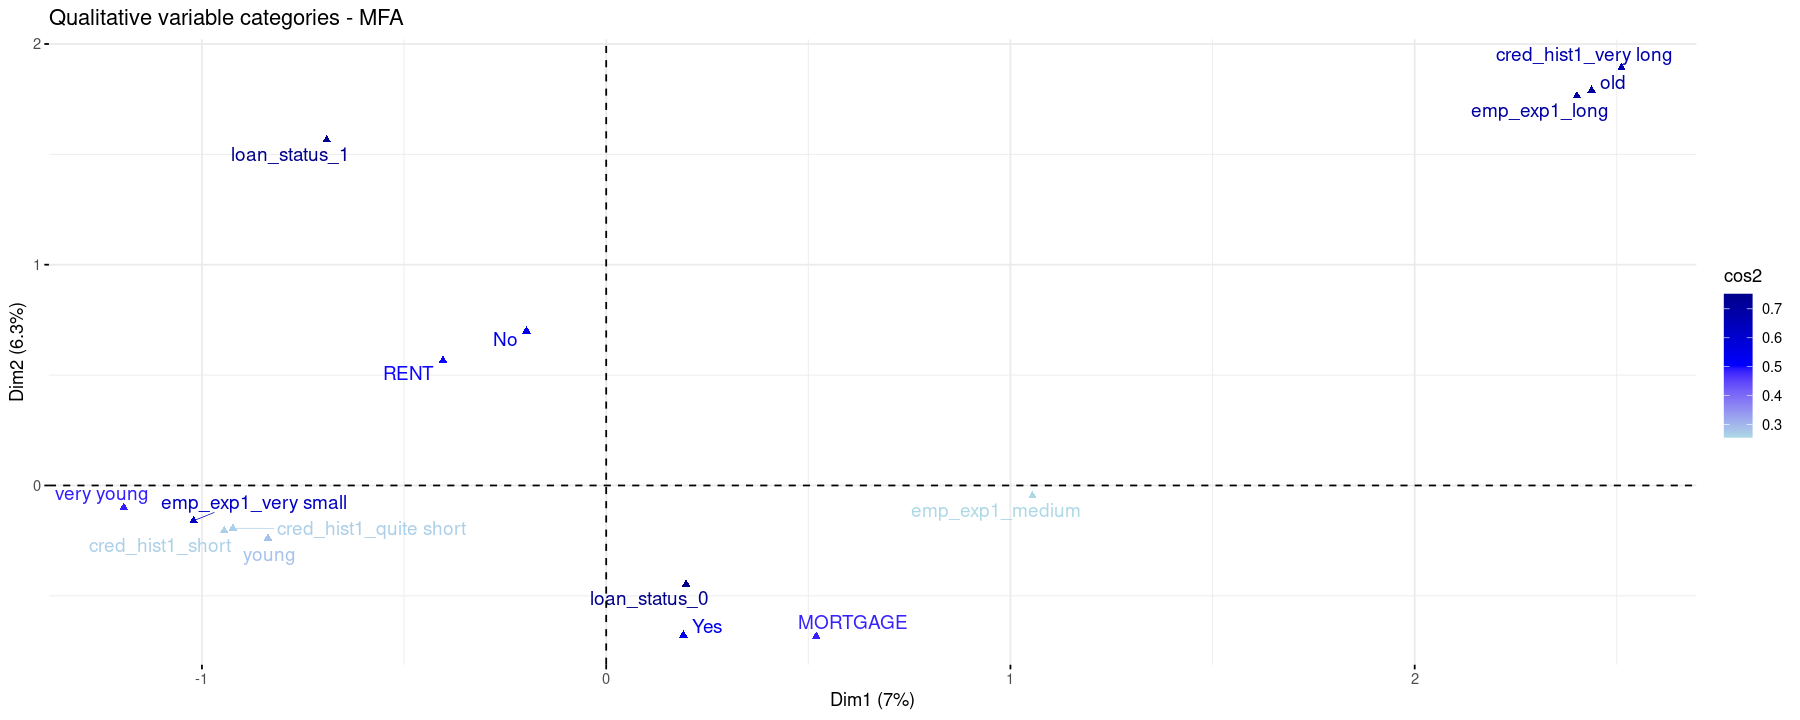

In [219]:
fviz_mfa_var(res.mfa, "quali.var",repel = TRUE,select.var = list(cos2 = 15),
             col.var = "cos2", gradient.cols = c("lightblue", "blue", "darkblue"))

On trouve que dim2 permet de distinguer loan_status, de plus, les personnes qui possèdent leurs maison ou mortgage, qui ont un objectif d'emprunt pour l'education, ont un chance important pour avoir un emprunt. Les personnes qui ont un objectif de médicament, ou payent leur loyer ont une chance plus faibe pour avoir un emprunt.  

In [210]:
loan_mfa1 <- data.frame(loan_quanti, loan_quali)
res.mfa <- MFA(
  loan_mfa1,
  group = c(8, 6),     # Nombre de variables par groupe
  type = c("s", "n"),# "s" = quanti, "n" = quali
  name.group = c("Group_quanti", "Group_quali"), 
  graph = FALSE
)

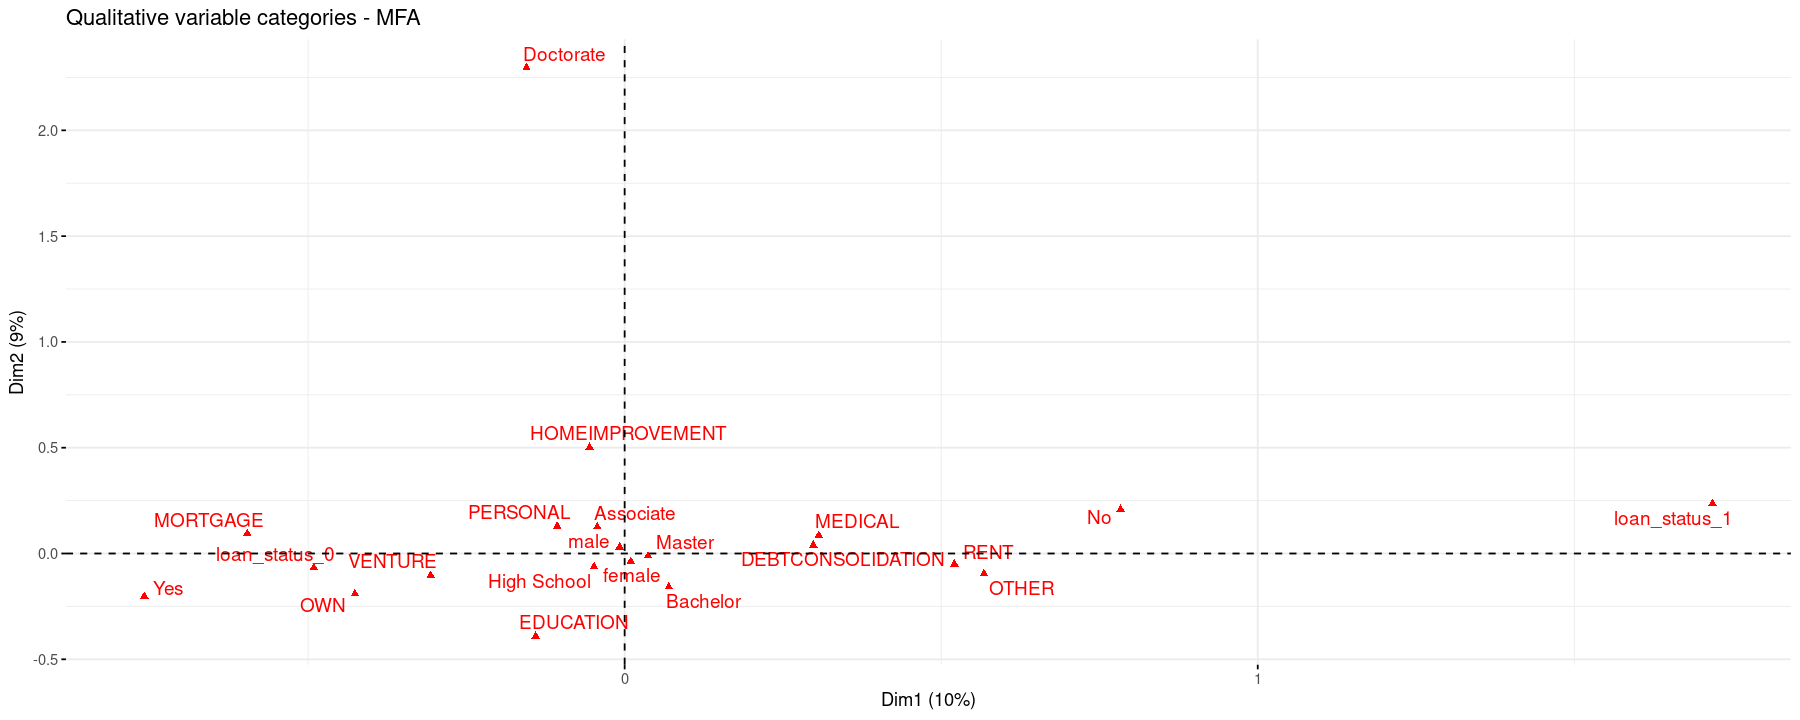

In [211]:
fviz_mfa_var(res.mfa, "quali.var", repel = TRUE, gradient.cols = c("lightblue", "blue", "darkblue"))

In [168]:
str(loan) 
person_income, loan_amnt, loan_int_rate, loan_percent_income
son_gender, person_education, person_home_ownership

Mục đích và kết quả khoản vay:
loan_intent, previous_loan_defaults_on_file, loan_status

'data.frame':	44993 obs. of  18 variables:
 $ person_age                    : num  22 21 25 23 24 21 26 24 24 21 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ person_emp_exp                : int  0 0 3 0 1 0 1 5 3 0 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_intent                   : Factor w/ 6 levels "DEBTCONSOLIDATION",..: 5 2 4 4 4 6 2 4 5 6 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ cb_person_cred_hist_length    : num  3 2 3 2 4 2 3 4 2 3 ...
 $ credit_score     

In [172]:
loan_mfa = data.frame(loan[,c(1,11,5)],loan[,c(4,7,9,10)],loan[12],loan[,c(2,3,6)],loan[,c(8,13)],loan[14])
str(loan_mfa)
res.mfa <- MFA(
  loan_mfa,
  group = c(3, 4, 1,3,2,1),     # Nombre de variables par groupe
  type = c("s", "s" ,"s","n","n","n"),# "s" = quanti, "n" = quali
  name.group = c("Age", "Income","Credit score","gender","Intent","loan_status"),  # noms des groupes
    num.group.sup  = 6,  
  graph = FALSE
)

'data.frame':	44993 obs. of  14 variables:
 $ person_age                    : num  22 21 25 23 24 21 26 24 24 21 ...
 $ cb_person_cred_hist_length    : num  3 2 3 2 4 2 3 4 2 3 ...
 $ person_emp_exp                : int  0 0 3 0 1 0 1 5 3 0 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ credit_score                  : int  561 504 635 675 586 532 701 585 544 640 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ loan_intent                   : Fac

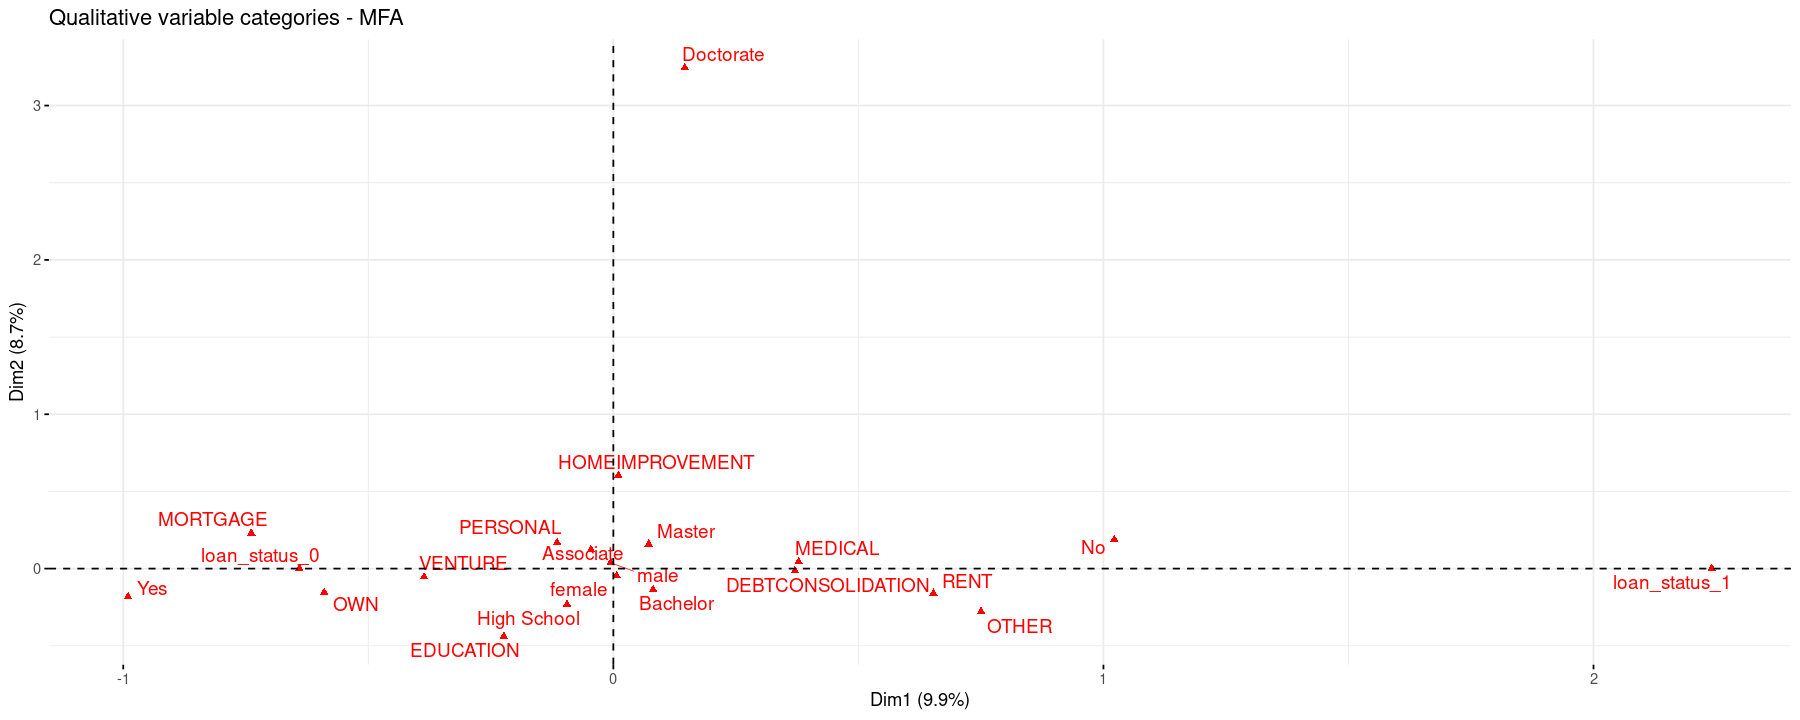

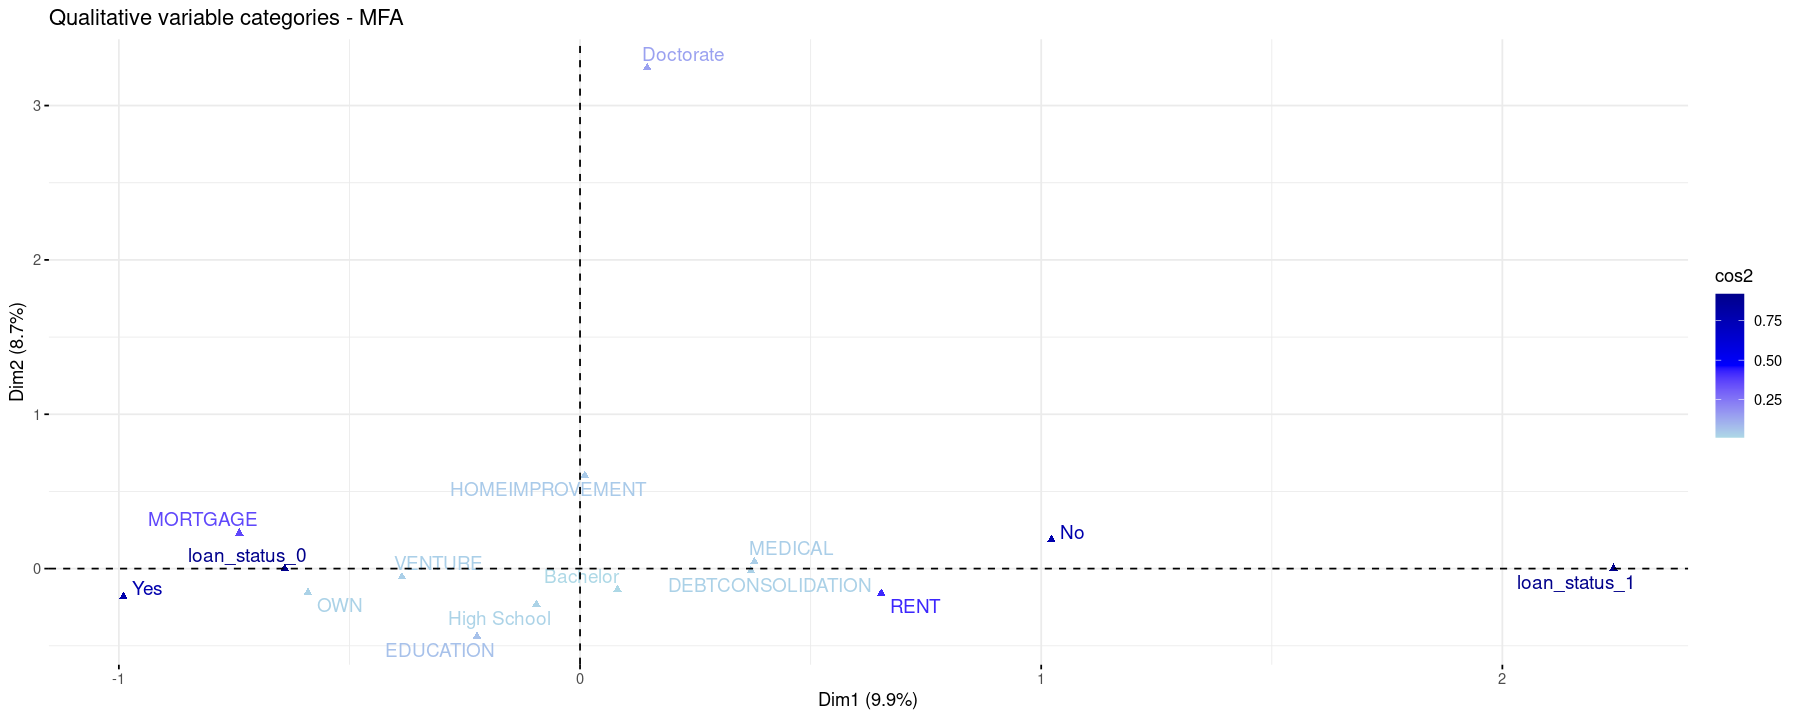

In [174]:
fviz_mfa_var(res.mfa, "quali.var", repel = TRUE, gradient.cols = c("lightblue", "blue", "darkblue"))
fviz_mfa_var(res.mfa, "quali.var",repel = TRUE,select.var = list(cos2 = 15),
             col.var = "cos2", gradient.cols = c("lightblue", "blue", "darkblue"))

In [175]:
str(loan)

'data.frame':	44993 obs. of  18 variables:
 $ person_age                    : num  22 21 25 23 24 21 26 24 24 21 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ person_emp_exp                : int  0 0 3 0 1 0 1 5 3 0 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_intent                   : Factor w/ 6 levels "DEBTCONSOLIDATION",..: 5 2 4 4 4 6 2 4 5 6 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ cb_person_cred_hist_length    : num  3 2 3 2 4 2 3 4 2 3 ...
 $ credit_score     

In [178]:
loan_mfa = data.frame(loan[,c(15,2,3,16,6)],loan[,c(4,7,9,10)],loan[,c(17,18,13)],loan[8],loan[14])
str(loan_mfa)
res.mfa <- MFA(
  loan_mfa,
  group = c(5, 4,3,1,1),     # Nombre de variables par groupe
  type = c("n", "s" ,"n","n","n"),# "s" = quanti, "n" = quali
  name.group = c("Age", "Income","Credit score","gender","loan_status"),  # noms des groupes
    num.group.sup  = 5,  
  graph = FALSE
)

'data.frame':	44993 obs. of  14 variables:
 $ age1                          : Factor w/ 5 levels "very young","young",..: 1 1 2 1 2 1 3 2 2 1 ...
 $ person_gender                 : Factor w/ 2 levels "female","male": 1 1 1 1 2 1 1 1 1 1 ...
 $ person_education              : Factor w/ 5 levels "Associate","Bachelor",..: 5 4 4 2 5 4 2 4 1 4 ...
 $ emp_exp1                      : Factor w/ 5 levels "very small","small",..: 1 1 2 1 1 1 1 3 2 1 ...
 $ person_home_ownership         : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 3 1 4 4 3 4 4 4 3 ...
 $ person_income                 : num  11.18 9.42 9.43 11.29 11.1 ...
 $ loan_amnt                     : num  35000 1000 5500 35000 35000 2500 35000 35000 35000 1600 ...
 $ loan_int_rate                 : num  16 11.1 12.9 15.2 14.3 ...
 $ loan_percent_income           : num  0.49 0.08 0.44 0.44 0.53 0.19 0.37 0.37 0.35 0.13 ...
 $ cred_hist1                    : Factor w/ 6 levels "very short","short",..: 2 1 2 1 3 1 2 3 1 2 ...
 $ score1      

In [ ]:
fviz_mfa_var(res.mfa, "quali.var", repel = TRUE, gradient.cols = c("lightblue", "blue", "darkblue"))

# Clustering

## K-means

In [153]:
p1 = fviz_nbclust(loan_quanti, FUNcluster=stats::kmeans, method="wss") +
    ggtitle("WSS score")

grid.arrange(p1,p2,ncol=2)
# fviz_nbclust(...)

In [154]:
set.seed(123)
Kmax<- 5
reskmeanscl<-matrix(0,nrow=nrow(loan_quanti),ncol=Kmax-1)
Iintra<-NULL
for (k in 2:Kmax){
resaux<-kmeans(loan_quanti,k)
reskmeanscl[,k-1]<-resaux$cluster
Iintra<-c(Iintra,resaux$tot.withinss) #tot.withinss est l’inertie intra-classe totale
17
}
df<-data.frame(K=2:5,Iintra=Iintra)
Intrac <- ggplot(df,aes(x=K,y=Iintra)) + geom_line()+geom_point()+
xlab("NbClust") +ylab("Inertie intraclasse")


In [155]:
R2<-NULL
for (k in 2:Kmax){
resaux<-kmeans(loan_quanti,k)
reskmeanscl[,k-1]<-resaux$cluster
R2<-c(R2,resaux$betweenss/resaux$totss)
}
daux<-data.frame(NbClust=2:Kmax,R2=R2)
R2c <- ggplot(daux,aes(x=NbClust,y=R2))+geom_line()+geom_point()

In [158]:
CH <- NULL
for (k in 2:Kmax){
CH<-c(CH,index.G1(loan_quanti,reskmeanscl[,k-1]))
}
daux<-data.frame(NbClust=2:Kmax,CH=CH)
CHc <- ggplot(daux,aes(x=NbClust,y=CH))+geom_line()+geom_point()

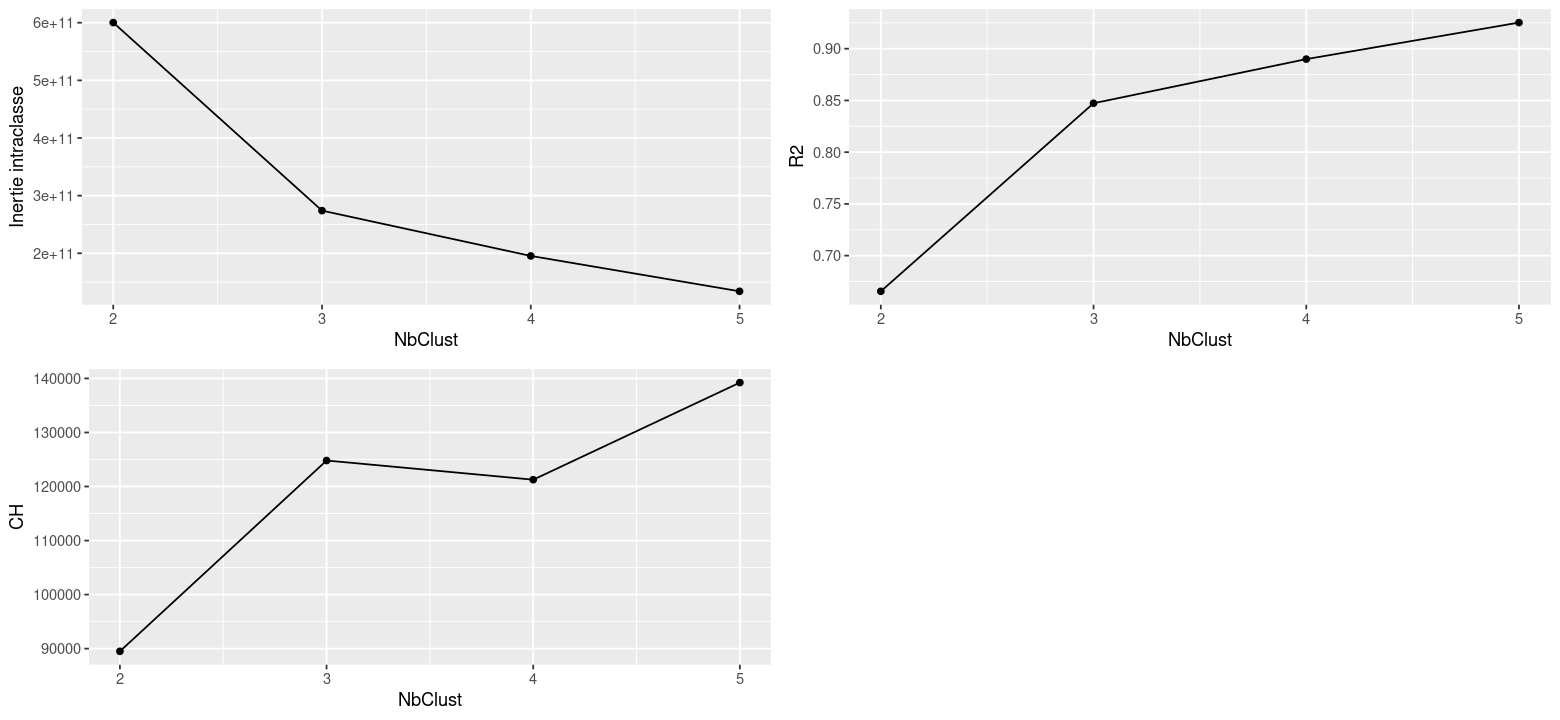

In [157]:
grid.arrange(Intrac,R2c,CHc, ncol = 2,nrow = 2)

In [159]:
reskmeans = kmeans(loan_quanti, centers=3) 

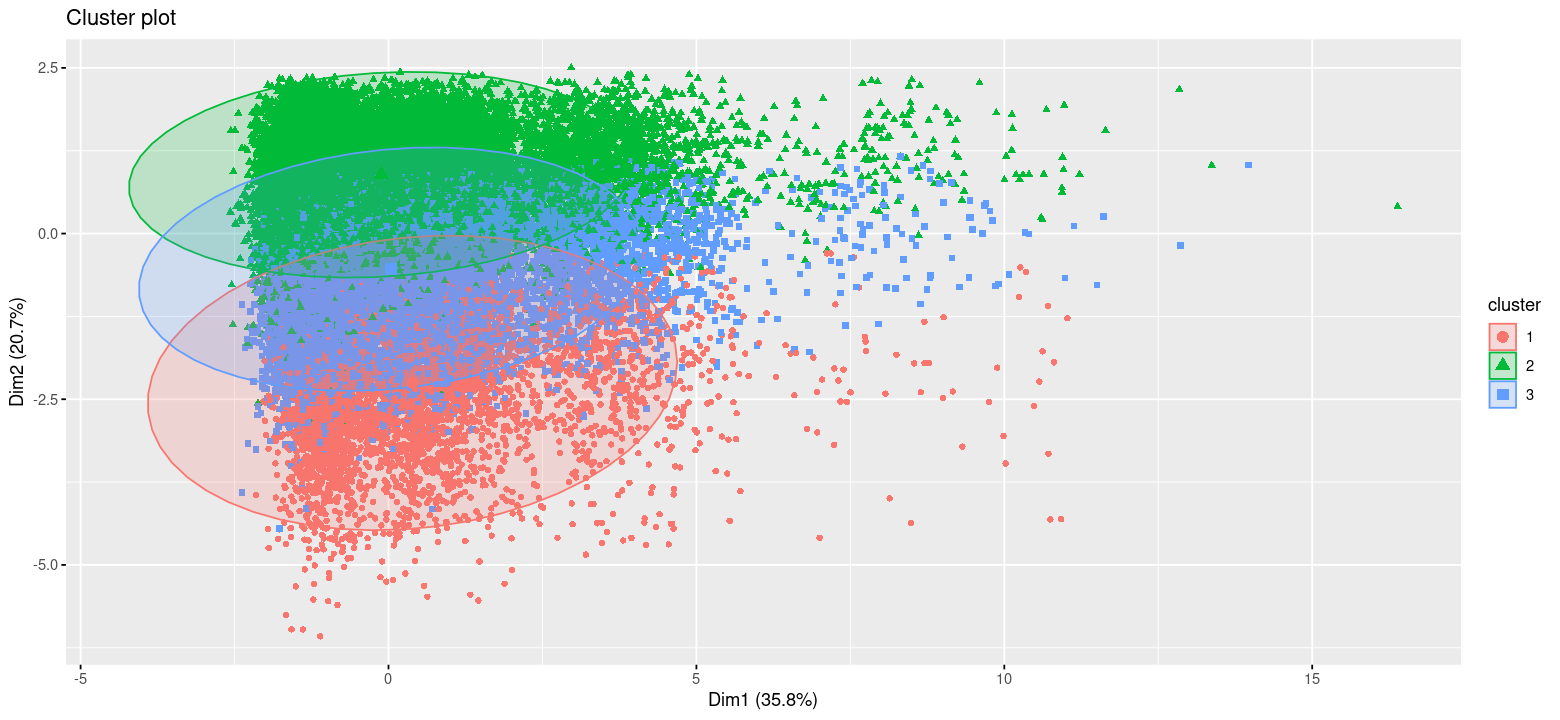

In [160]:
fviz_cluster(reskmeans, data=loan_quanti, ellipse.type="norm", labelsize=8, geom=c("point"))

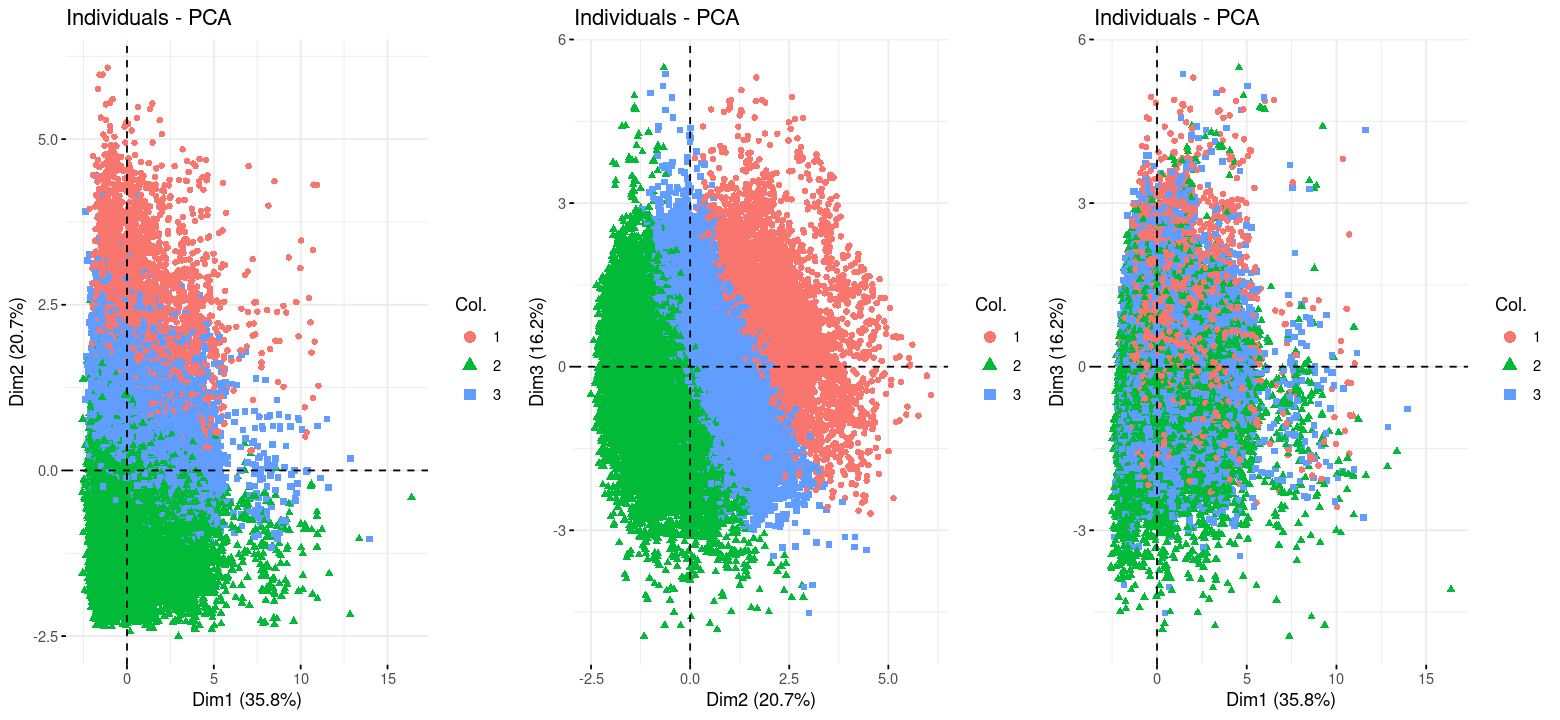

In [161]:
P1 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(1,2))
P2 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(2,3))
P3 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(1,3))
grid.arrange(P1,P2, P3, ncol = 3)

   
        1     2     3
  0  3677 19126 12190
  1  1871  4511  3618


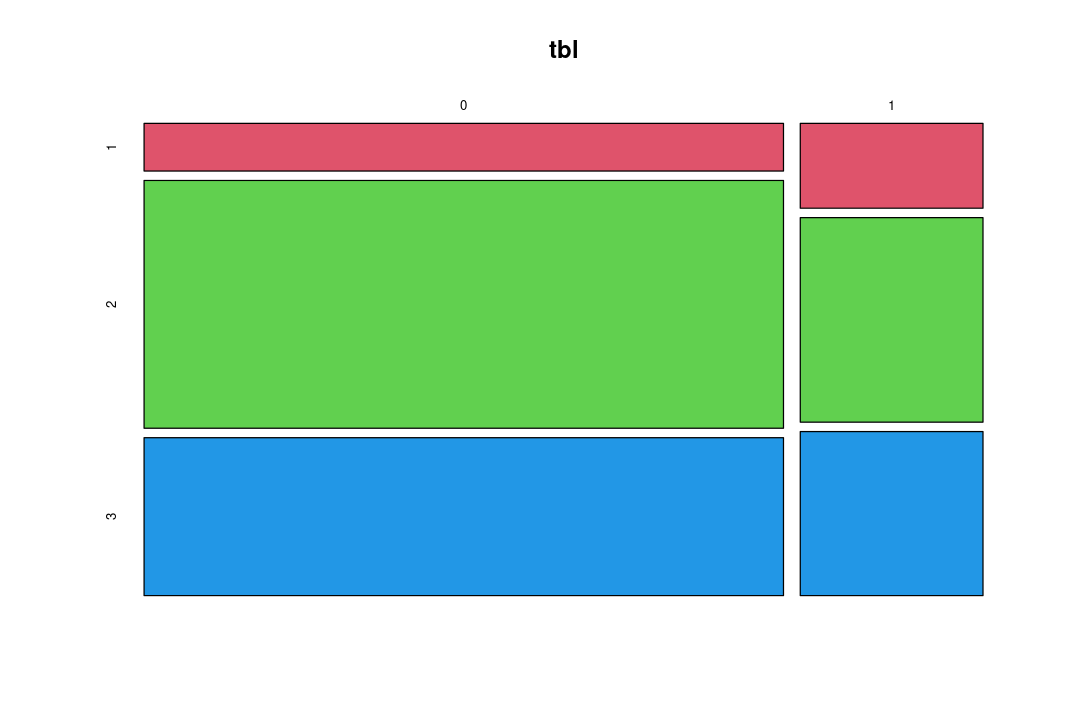

In [162]:
tbl = table(loan$loan_status, reskmeans$cluster)
print(tbl)

options(repr.plot.width = 9, repr.plot.height = 6)
mosaicplot(tbl, color=c(2:4))

# --- #
options(repr.plot.width = 15, repr.plot.height = 6)



In [ ]:
tbl = table(loan$age1, reskmeans$cluster)
print(tbl)

## Gaussian Mixture

In [163]:
resBICall = mclustBIC(loan_quanti, G=2:5)


In [164]:
summary(resBICall)

Best BIC values:
            VVV,5       EVV,5       VVV,4
BIC      -2042918 -2056656.00 -2062841.96
BIC diff        0   -13737.98   -19923.95

In [165]:
resBICall = Mclust(loan_quanti, G=2:5)
fviz_mclust(resBICall, what="BIC")

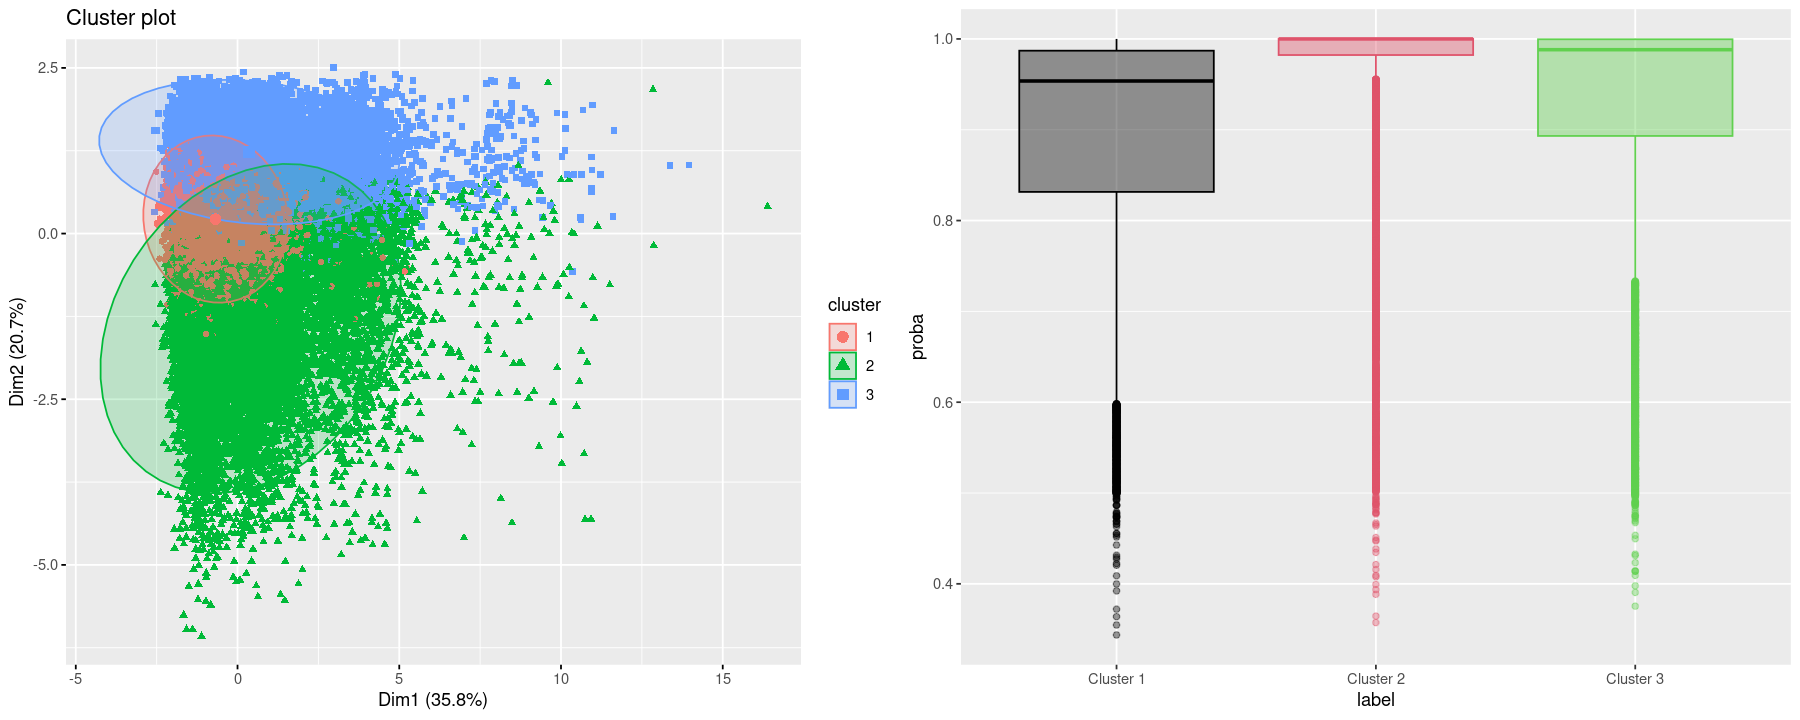

In [166]:
K = 3
gmm = Mclust(loan_quanti, G=K)
p1 = fviz_cluster(gmm, data = loan_quanti, ellipse.type="norm", geom="point")

aux = data.frame(label = paste("Cluster",gmm$classification, sep = " "),
                 proba = apply(gmm$z, 1, max))

p2 = ggplot(aux, aes(x=label, y = proba)) + geom_boxplot(colour = 1:K, fill=1:K, alpha =  0.4)
grid.arrange(p1,p2,ncol = 2)

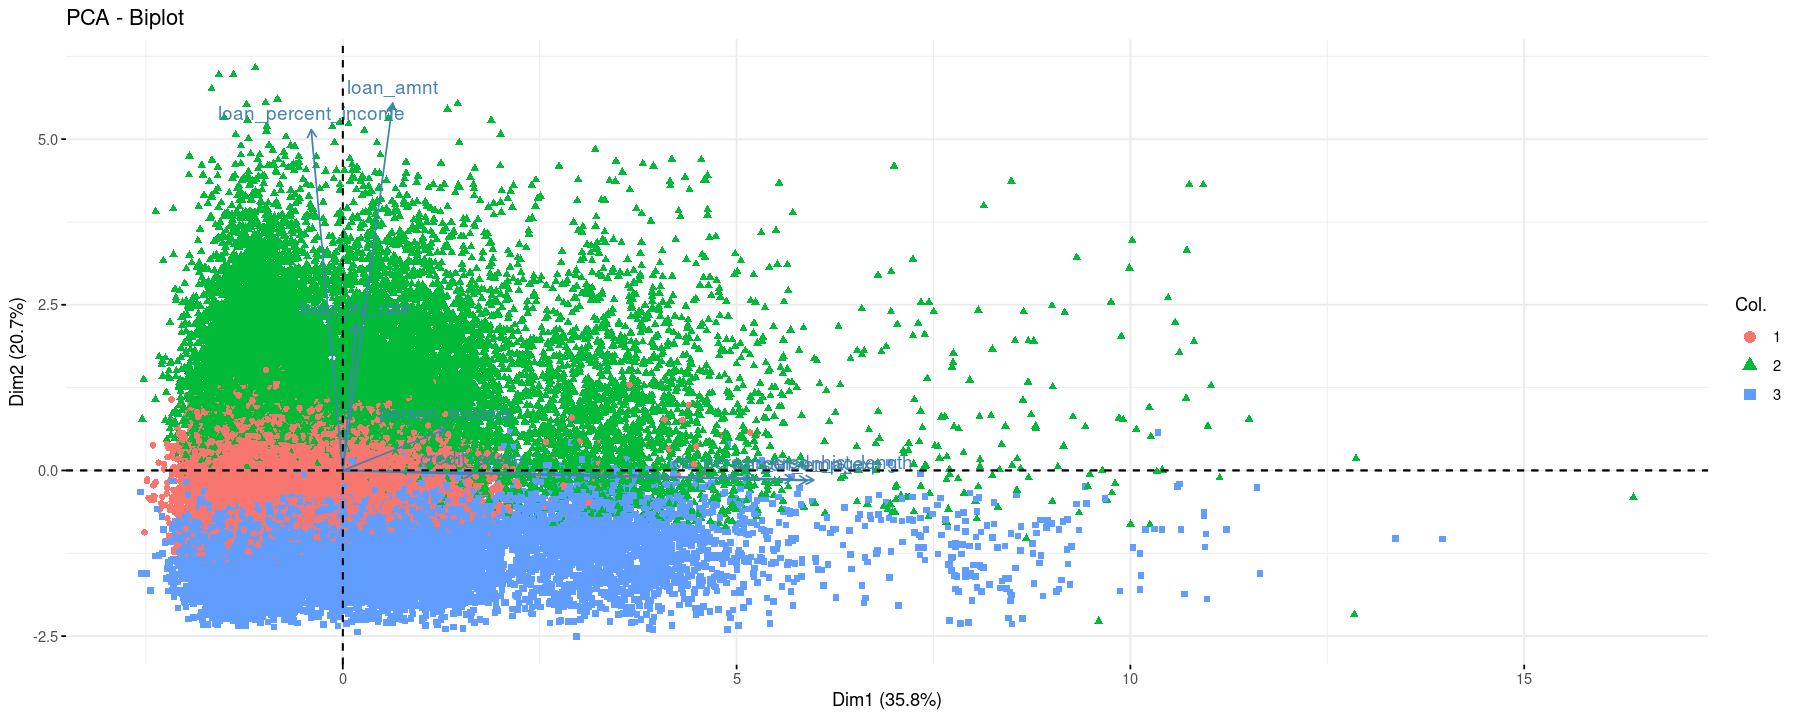

In [167]:
fviz_pca(acp, axes = c(1,2), geom = c("point"), col.ind = as.factor(gmm$classification))

### Spectral clustering

In [ ]:
# Encodage one-hot pour toutes les variables qualitatives
loan_matrix <- model.matrix(~ . -1, data = loan)
loan_matrix <- scale(loan_matrix)

In [ ]:
set.seed(123)
sc_res <- specc(loan_matrix, centers = 3)
fviz_pca(acp, axes = c(1,2), geom = c("point"), col.ind = as.factor(sc_res))

In [ ]:
## LDA

In [ ]:
loan_matrix <- model.matrix(loan_status ~ . -1, data = loan)
lda_model <- lda(loan$loan_status ~ ., data = as.data.frame(loan_matrix))
lda_coords <- predict(lda_model)$x

df_lda <- data.frame(lda_coords, loan_status = loan$loan_status)
ggplot(df_lda, aes(x = LD1, y = LD2, color = loan_status)) +
  geom_point(alpha = 0.5) +
  labs(title = "Projection LDA selon loan_status") +
  theme_minimal()

In [ ]:
loan_matrix <- model.matrix(~ . -1, data = loan)
loan_matrix <- as.data.frame(loan_matrix)

In [ ]:

res.nmf <- nmf(as.matrix(loan_matrix), rank = 2, nrun = 10, seed = 123)

# Visualiser les profils
basis(res.nmf)      # matrice W (individus)
coef(res.nmf)       # matrice H (composantes)